# SuggestiveCAD Exploring Execusion Command for the Creation of Geometric Objects

## Introduction

### Command Set

The command set for Fsion 360 is composed of Sketch and Extrude. Among which sketch is about creating a new curve in the Fusion 360 environment, and extrude is about extruding an existing feature.

#### Sketch

SketchArc

SketchCircle

SketchConicCurve

SketchEllipse

SketchEllipticalArc

SketchFittedSpline

SketchFixedSpline

SketchLine

#### Extrude


### CAD-Autocomplete


## Create A Parser

We parse the command for reconstruction CAD objects according to the Fusion 360 APIs. We first only construct a simple RNN for sequence prediction.

In [1]:
import os
import json
import time
import argparse
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import glob
import pickle

import networkx as nx

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import itertools

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, LSTM, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.2.4-tf
2.1.0


In [2]:
# Global Variables
construction_planes = ["XY", "XZ", "YZ"]
feature_operations = [
            "JoinFeatureOperation",
            "CutFeatureOperation",
            "IntersectFeatureOperation",
            "NewBodyFeatureOperation"
        ]

train_length = 10

In [124]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [125]:
# Hyperparametr: Predict the next words based on the immediate 
# last train_length number of words seen

class CADFile:
    '''Class that helps with parsing Fusion 360 Dataset files'''
    def __init__(self, index, fileid, filedir):
        self.index = index
        with open(filedir) as f:
            self.originaldata = json.load(f)
        
        self.entities = self.originaldata['entities']
        # Construct Dataframe for Debugging
        self.df = pd.DataFrame(data = self.originaldata['sequence']).drop(['smt','step','obj'], axis = 1)
        self.df['entities']=self.df['entity'].apply(lambda x: (self.originaldata['entities'])[x])
        self.df['content']=self.df.apply(self.extract_content, axis = 1)
        #seqdf['constraint']=seqdf.apply(extract_constraint, axis = 1)
        self.df['symbols']=self.df.apply(self.extract_symbol, axis = 1)
        self.impath = fileid+'.png'
        
        # Construct Sequence
        self.sequence = list(''.join(['B']+list(self.df.symbols)+['Z']))
        
        # Construct DAG
        self.extrudedf = (self.df).loc[lambda df: df['type'] == "ExtrudeFeature"]
        self.extrudes = [self.originaldata['entities'][extrude] for extrude in self.extrudedf['entity'].values]
        
        

    def extract_content(self, row):
        if row['type'] == 'Sketch':
            return (self.originaldata['entities'][row['entity']])['curves'][row['curve']]['type']
        else:
            return self.originaldata['entities'][row['entity']]

    def extract_constraint(self, row) -> str:
        if row['type'] == 'Sketch':
            return (self.originaldata['entities'][row['entity']])['constraints']
        else:
            'notapplied'

    def extract_dimensions(self, row):
        if row['type'] == 'Sketch':
            return (self.originaldata['entities'][row['entity']])['dimensions']
        else:
            'notapplied'

    # create a implicit order of symbol's representation of reconstruction process
    def extract_symbol(self, row) -> str:
        commands=[]
        if (self.originaldata['entities'][row['entity']])['type'] == 'Sketch':
            curve = (self.originaldata['entities'][row['entity']])['curves'][row['curve']]
            sketchtype=curve['type']
            if sketchtype=='SketchArc':
                commands+=['A']#+['P']*3
            elif sketchtype=='SketchCircle':
                commands+=['C']
            elif sketchtype=='SketchConicCurve':
                commands+=['O']
            elif sketchtype=='SketchEllipse':
                commands+=['E']
            elif sketchtype=='SketchEllipticalArc':
                commands+=['R']
            elif sketchtype=='SketchFittedSpline':
                commands+=['S']#+['P']*len(curve['control_points'])
            elif sketchtype=='SketchFixedSpline':
                commands+=['F']
            # SketchLine
            else:
                commands+=['L']#+['P']*2
        else:
            commands.append('X')
        return ''.join(commands)
    
    # create a Directed Acyclic Graph representation
    def extract_dag(self):
        planes = {}
        for extrude in self.extrudes:
            operation = extrude["operation"]
            profiles = extrude["profiles"]
            orig_curves = profiles["profile"]
            target_sketch = profiles[0]["sketch"]
            
            ref_plane = self.target_sketch["reference_plane"]
            

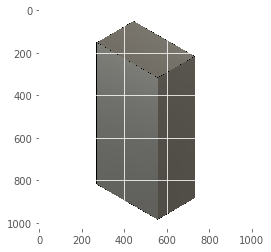

In [126]:
idx = 9

dataset_path = "../../r1.0.0/"

train_sample = test_sample = []
train_test = dataset_path+"train_test.json"
data_path = dataset_path+"reconstruction/"

with open(train_test) as f:
    train_test_split = json.load(f)

train_dir = train_test_split['train'][:80]
test_dir = train_test_split['test'][:20]

example_data = CADFile(0,train_dir[idx], dataset_path+"reconstruction/"+train_dir[idx]+'.json')
symbols = example_data.sequence
img = plt.imread(data_path+example_data.impath)
plt.imshow(img)


In [127]:
def load_fusion_data(train_length, dataset_path):

    train_map = test_map = dict()
    train_df = test_df = []
    train_test = dataset_path+"train_test.json"
    data_path = dataset_path+"reconstruction/"

    with open(train_test) as f:
        train_test_split = json.load(f)

    train_dir = train_test_split['train']
    test_dir = train_test_split['test']
    
    for train_idx, train_file in enumerate(train_dir):
        train_map[train_idx] = train_file
        path = data_path+train_file+'.json'
        train_seq = CADFile(train_idx,train_file,path).sequence
        if(len(train_seq) - 1 < train_length): 
            continue
        element = pd.DataFrame({'index':['object: '+str(train_idx)]*len(train_seq),
                                'id':train_file,'sequence':train_seq})
        #print(element)
        train_df.append(element)
        
    for test_idx, test_file in enumerate(test_dir):
        test_map[test_idx] = test_file
        path = data_path+test_file+'.json'
        test_seq = CADFile(test_idx,test_file,path).sequence
        if(len(test_seq) - 1 < train_length): 
            continue
        test_df.append(pd.DataFrame({'index':['object: '+str(test_idx)]*len(test_seq),
                                     'id':test_file, 'sequence':test_seq}))
        
    return pd.concat(train_df), pd.concat(test_df), train_map, test_map

In [128]:
train_seq, test_seq, train_map, test_map = load_fusion_data(1, dataset_path)

In [129]:
def tokenize_corpus(train_seq, test_seq, train_length):
    # Tokenize the training and test dataset
    commands = sorted(list(set(train_seq['sequence'].values)))
    commands.append('P')
    n_commands = len(commands)

    command2idx = {c: i for i, c in enumerate(commands)}
    idx2command = {i: c for i, c in enumerate(commands)}

    #agg_func = lambda w: [w for w in train_seq["sequence"].values.tolist()]
    train_grouped = train_seq.groupby("index")#.apply(agg_func)
    train_sentences = [s[1]['sequence'].values.tolist() for s in train_grouped]

    test_grouped = test_seq.groupby("index")#.apply(agg_func)
    test_sentences = [s[1]['sequence'].values.tolist() for s in test_grouped]

    max_len = max([len(s) for s in train_sentences+test_sentences])
    min_len = min([len(s) for s in train_sentences+test_sentences])

    print(f'n_commands: {n_commands}, max_len: {max_len}, min_len:{min_len}')

    # Prepare the predictors matrix X, as a list of lists, 
    # where each inner list is a sequence of words mapped 
    # into integers accordly to the word2idx dictionary.
#     X_train = np.array(list(itertools.chain.from_iterable(
#         [[[command2idx[c] for c in s[i:i+train_length]] 
#           for i in range(len(s) - train_length - 1)] 
#           for s in train_sentences])))
#     X_test = np.array(list(itertools.chain.from_iterable(
#         [[[command2idx[c] for c in s[i:i+train_length]] 
#           for i in range(len(s) - train_length - 1)] 
#           for s in test_sentences])))

#     Y_train = np.array(list(itertools.chain.from_iterable(
#         [[[command2idx[c] for c in s[i+train_length:i+train_length+1]] 
#           for i in range(len(s) - train_length - 1)] for s in train_sentences])))
#     Y_test = np.array(list(itertools.chain.from_iterable(
#         [[[command2idx[c] for c in s[i+train_length:i+train_length+1]]
#           for i in range(len(s) - train_length - 1)] for s in test_sentences])))
    
    X_train = []
    X_test = []
    for idx, s in enumerate(train_sentences):
        if len(s) < train_length:
            
            

    # Apply the keras pad_sequences function
    # X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_commands-1)

    Y_train = to_categorical(Y_train, num_classes=n_commands)
    seq_len = Y_train.shape[1]

    Y_test =  to_categorical(Y_test, num_classes=n_commands)
    seq_len = X_train.shape[1]
    
    return X_train, Y_train, X_test, Y_test, seq_len, n_commands, command2idx, idx2command

IndentationError: expected an indented block (<ipython-input-129-8d15fbbe95f0>, line 51)

In [27]:
train_seq.to_csv("train_seq.csv")
test_seq.to_csv("test_seq.csv")

with open('train_map.json', 'w') as outfile:
    json.dump(train_map, outfile)
    
with open('test_map.json', 'w') as outfile:
    json.dump(test_map, outfile)

In [ ]:
train_seq=pd.read_csv("train_seq.csv")
test_seq=pd.read_csv("test_seq.csv")

X_train, Y_train, X_test, Y_test, seq_len, n_commands, command2idx,idx2command = tokenize_corpus(train_seq, test_seq, 10)
print(X_train.shape)

### Building A Simple LSTM for Command Prediction

In [31]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_loss, 'b', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [38]:
dim_embed = 100

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 64
epochs = 10
validation_split = 0.1
verbose = 1

model = Sequential()
model.add(Embedding(input_dim=n_commands, output_dim=dim_embed, input_length = seq_len))
model.add(LSTM(1024, return_sequences = True))
model.add(LSTM(2048, return_sequences = True))
model.add(LSTM(1024))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(n_commands, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 100)           800       
_________________________________________________________________
lstm_15 (LSTM)               (None, 10, 1024)          4608000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 2048)          25174016  
_________________________________________________________________
lstm_17 (LSTM)               (None, 1024)              12587008  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 4104      
Total params: 42,898,728
Trainable params: 42,898,728
Non-trainable params: 0
__________________________________________

In [39]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose = 2)

Train on 58286 samples, validate on 6477 samples
Epoch 1/10
58286/58286 - 32s - loss: 0.6429 - accuracy: 0.7868 - val_loss: 0.6054 - val_accuracy: 0.8002
Epoch 2/10
58286/58286 - 30s - loss: 0.5621 - accuracy: 0.8098 - val_loss: 0.5709 - val_accuracy: 0.8001
Epoch 3/10
58286/58286 - 30s - loss: 0.5402 - accuracy: 0.8168 - val_loss: 0.5833 - val_accuracy: 0.8123
Epoch 4/10
58286/58286 - 30s - loss: 0.5285 - accuracy: 0.8200 - val_loss: 0.5760 - val_accuracy: 0.8099
Epoch 5/10
58286/58286 - 30s - loss: 0.5199 - accuracy: 0.8231 - val_loss: 0.5714 - val_accuracy: 0.8109
Epoch 6/10
58286/58286 - 30s - loss: 0.5118 - accuracy: 0.8257 - val_loss: 0.5758 - val_accuracy: 0.8099
Epoch 7/10
58286/58286 - 30s - loss: 0.5036 - accuracy: 0.8289 - val_loss: 0.5579 - val_accuracy: 0.8110
Epoch 8/10
58286/58286 - 30s - loss: 0.4933 - accuracy: 0.8325 - val_loss: 0.5707 - val_accuracy: 0.8096
Epoch 9/10
58286/58286 - 30s - loss: 0.4823 - accuracy: 0.8351 - val_loss: 0.5685 - val_accuracy: 0.8101
Epoch 

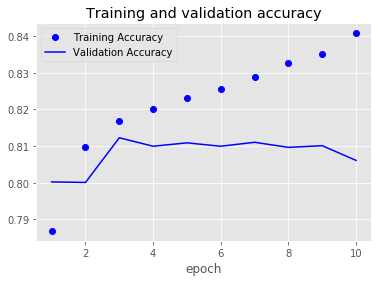

In [40]:
plot_training_history(history)

In [41]:
#store_keras_model(model,'SimpleLSTMNoPoint')
model.save("models/SimpleLSTM.h5")
model = load_model("models/SimpleLSTM.h5")

In [24]:
print(command2idx)
print(idx2command)

{'A': 0, 'C': 1, 'E': 2, 'L': 3, 'S': 4, 'X': 5, 'Z': 7}
{0: 'A', 1: 'C', 2: 'E', 3: 'L', 4: 'S', 5: 'X', 6: 'Z', 7: 'Z'}


In [8]:
# # Validate Prediction on Test Set
# results = model.evaluate(X_test, Y_test, batch_size=batch_size)
# print("test loss, test acc:", results)

In [25]:
print(X_train[0].shape)

(10,)


In [26]:
# Embedding Layer to Encode one-hot feature representation?
# Using Tree LSTM for representing each node data structure
instr= np.array([1,3,4,2,5,7,4,5,6,2]).reshape(1,10)
print(X_train.shape)
outstr = model.predict(instr)
predicted = np.argsort(outstr)
print((list(predicted[0])))

(111861, 10)
[6, 7, 4, 3, 2, 0, 1, 5]


### Data Augumentation by Rebuilding the DAG for each Design

Here we create a DAG representation for each design in the dataset using the command order. Some extrusion commands rely on other sketch commands, and some sketch commands rely on other sketch commands. Therefore, there is an implicit reconstruction order for the dataset based on the dependencies. In the previous approach, we only construct one sequence for each design, but all commands on the same level of topographical order could be permuted, therefore we use this implicit Directed Acyclic Graph representation to augument our dataset.

https://www.sciencedirect.com/science/article/abs/pii/0020019074900015?via%3Dihub

In [9]:
class CADDAGFile:
    '''Class that helps with parsing Fusion 360 Dataset files'''
    def __init__(self, index, fileid, filedir, thresh):
        self.index = index
        self.thresh = thresh
        
        # Load JSON file from disk
        with open(filedir) as f:
            self.originaldata = json.load(f)
        
        self.entities = self.originaldata['entities']
        self.impath = fileid+'.png'
        self.timeline = [times['entity'] for times in self.originaldata['timeline']]
        self.seq = [seqs['entity'] for seqs in self.originaldata["sequence"]]
        
        self.sketches = []
        self.extrudes = []
        self.edges = set()
        
        # dictionary that keeps track of effective curves
        self.profiles = {}
        self.indeg = {}
        self.outdeg = {}
        # similar to profiles, keeps track of symbols for each profile
        # using symbolic representation
        self.symbols={}
        # dictionary that keeps track of reference planes
        self.planes = {}
        
        self.extract_dag()
        self.extract_symbol()
        
        # Construct All Topological Orderings
        self.all_topo_orderings = self.extract_all_topo_ordering()
        self.sequences = [list(itertools.chain.from_iterable([self.symbols[time]
                         if (time in self.sketches)
                         else['X'] for time in order]+[['Z']]))
                        for order in self.all_topo_orderings]

    # create a implicit order of symbol's representation of reconstruction process
    def extract_symbol(self):
        for entity in self.originaldata["sequence"]:
            if entity["type"] =="Sketch":
                sketchid = entity["entity"]
                curveid = entity["curve"]
                curve = self.entities[sketchid]["curves"][curveid]
                sketchtype=curve["type"]
                if sketchtype=='SketchArc':
                    commands='A'
                elif sketchtype=='SketchCircle':
                    commands='C'
                elif sketchtype=='SketchConicCurve':
                    commands='O'
                elif sketchtype=='SketchEllipse':
                    commands='E'
                elif sketchtype=='SketchEllipticalArc':
                    commands='R'
                elif sketchtype=='SketchFittedSpline':
                    commands='S'
                elif sketchtype=='SketchFixedSpline':
                    commands='F'
                # SketchLine
                else:
                    commands='L'
                self.symbols.setdefault(sketchid, []).append(commands)
    
    # create a Directed Acyclic Graph representation
    def extract_dag(self):
        # timeline vs sequence might be tricky
        for times in self.seq:
            entity = self.entities[times]
            if entity["type"] =="ExtrudeFeature":
                self.extrudes.append(times)
                operation = entity["operation"]
                profiles = entity["profiles"]
                ref_sketch = profiles[0]['sketch']
                self.edges.add((ref_sketch, times))
                self.indeg[times] = self.indeg.get(times, 0) + 1
                self.outdeg[ref_sketch] = self.outdeg.get(ref_sketch, 0) + 1
                faces = entity["faces"]
                
                # Construct a dictionary mapping extruded BrepFace to their Origin
                for faceid, values in faces.items():
                    if values["surface_type"]!="PlaneSurfaceType":
                        continue
                    self.planes.setdefault(times, []).append(values["point_on_face"])
                    
            else:
                self.sketches.append(times)
                
                # Traverse the already added sketches and extrudes
                sketchplane = entity["reference_plane"]
                if sketchplane["type"]=="BRepFace":
                    # only traverse existing extrusions to search for the extruded plane.
                    for plane, values in self.planes.items():
                        for value in values:
                            if sketchplane["point_on_face"]==value:
                                self.edges.add((plane, times))
                                
                # Rare case, < 100 sample points, but worth looking into
                if sketchplane["type"]=="Profile":
                    #print(fileid)
                    self.edges.add((sketchplane["sketch"], times))
                    
    def extract_all_topo_ordering(self):
        DG = nx.DiGraph(list(self.edges))
        toposet = set()
        all_topo_orderings = []
        seqiter = iter(nx.all_topological_sorts(DG))
        try:
            for i in range(self.thresh):
                localseq = next(seqiter)
                strseq = ''.join(localseq)
                if strseq not in toposet:
                    all_topo_orderings.append(localseq)
                    toposet.add(strseq)
        except (StopIteration, AssertionError) as e:
            pass
        return list(all_topo_orderings)
        

33967_0741e236_0001.png
number of nodes ['dfa410c8-e2b9-11ea-a27b-54bf646e7e1f', 'dfd1a00a-e2b9-11ea-bb46-54bf646e7e1f', 'dfd26312-e2b9-11ea-a34a-54bf646e7e1f', 'dff7b81c-e2b9-11ea-8ea3-54bf646e7e1f', 'dff87b34-e2b9-11ea-a58a-54bf646e7e1f']
number of edges {('dfd26312-e2b9-11ea-a34a-54bf646e7e1f', 'dff7b81c-e2b9-11ea-8ea3-54bf646e7e1f'), ('dfa410c8-e2b9-11ea-a27b-54bf646e7e1f', 'dfd1a00a-e2b9-11ea-bb46-54bf646e7e1f')}
number of symbolic representation 6
['LLLLLLXCXZ', 'LLLLLLCXXZ', 'LLLLLLCXXZ', 'CXLLLLLLXZ', 'CLLLLLLXXZ', 'CLLLLLLXXZ']


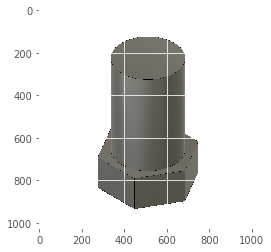

In [123]:
idx = 47

dataset_path = "../../r1.0.0/"

train_sample = test_sample = []
train_test = dataset_path+"train_test.json"
data_path = dataset_path+"reconstruction/"

with open(train_test) as f:
    train_test_split = json.load(f)

train_dir = train_test_split['train'][:800]
test_dir = train_test_split['test'][:200]

example_data = CADDAGFile(0,train_dir[idx],dataset_path+"reconstruction/"+train_dir[idx]+'.json', 1000000)
print(example_data.impath)
img = plt.imread(data_path+example_data.impath)
plt.imshow(img)

symbol2op = {'A':'SketchArc',
             'C':'SketchCircle',
             'O':'SketchConicCurve',
             'E':'SketchEllipse',
             'R':'SketchEllipticalArc',
             'S':'SketchFittedSpline',
            'F':'SketchFixedSpline',
            'L':'SketchLine',
            'X':'Extrude'}

ops = [[symbol2op[symbol]for symbol in seq if symbol in symbol2op] for seq in example_data.sequences]

example_json = example_data.originaldata
print("number of nodes", example_data.timeline)
print("number of edges", example_data.edges)
print("number of symbolic representation", len(example_data.sequences))
print([''.join(seq) for seq in example_data.sequences])

In [88]:
def load_dag_data(train_length, dataset_path, thresh):

    train_map = test_map = dict()
    train_df = []
    test_df = []
    train_test = dataset_path+"train_test.json"
    data_path = dataset_path+"reconstruction/"

    with open(train_test) as f:
        train_test_split = json.load(f)

    train_dir = train_test_split['train']
    test_dir = train_test_split['test']
    
    print(train_dir[0],test_dir[0])
    
    train_idx = 0
    for tid, train_file in enumerate(train_dir):
        train_map[train_idx] = train_file
        path = data_path+train_file+'.json'
        train_seqs = CADDAGFile(train_idx,train_file,path, thresh).sequences
        try:
            if(len(train_seqs[0]) - 1 < train_length): 
                continue
        except IndexError:
            continue
        print("Processing file No."+str(tid), train_file+"Number of permutations: "
             +str(len(train_seqs)))

        for train_seq in train_seqs:
            
            #print(train_seq)
            element = pd.DataFrame({'index':['object: '+str(train_idx)]*len(train_seq),
                                    'id':train_file, 'sequence':train_seq})
            train_df.append(element)
            train_idx +=1
            
    
    test_idx = 0
    for tid, test_file in enumerate(test_dir):
        test_map[test_idx] = test_file
        testpath = data_path+test_file+'.json'
        test_seqs = CADDAGFile(test_idx,test_file,testpath, thresh).sequences
        try:
            if(len(test_seqs[0]) - 1 < train_length): 
                continue
        except IndexError:
            continue
        print("Processing file No."+str(tid), test_file+"Number of permutations: "
             +str(len(test_seqs)))
        for test_seq in test_seqs:
            
            element_test = pd.DataFrame({'index':['object: '+str(test_idx)]*len(test_seq),
                                    'id':test_file, 'sequence':test_seq})
            test_df.append(element_test)
            test_idx+=1
        
    return pd.concat(train_df), pd.concat(test_df), train_map, test_map

In [130]:
dag_thresh = 50

train_seq_dag, test_seq_dag, train_map_dag, test_map_dag = load_dag_data(1, dataset_path, dag_thresh)

train_seq_dag.to_csv("train_seq_dag_50.csv")
test_seq_dag.to_csv("test_seq_dag_50.csv")

# with open('train_map_dag.json', 'w') as outfile:
#     json.dump(train_map_dag, outfile)
    
# with open('test_map_dag.json', 'w') as outfile:
#     json.dump(test_map_dag, outfile)

133248_c7255340_0000 22432_e4a51ee9_0006
Processing file No.0 133248_c7255340_0000Number of permutations: 2
Processing file No.1 51022_47816098_0003Number of permutations: 1
Processing file No.2 127202_42451722_0000Number of permutations: 1
Processing file No.3 55928_1ccd0821_0002Number of permutations: 1
Processing file No.4 34436_ffc43a58_0000Number of permutations: 1
Processing file No.5 89681_0c77b7fc_0006Number of permutations: 1
Processing file No.6 31655_baca05af_0000Number of permutations: 1
Processing file No.7 43931_bb001c04_0004Number of permutations: 1
Processing file No.8 83938_d6cf9eca_0000Number of permutations: 2
Processing file No.9 138954_6b7ae636_0000Number of permutations: 1
Processing file No.10 145540_a4f54d5f_0010Number of permutations: 1
Processing file No.11 29727_7b76b4a1_0000Number of permutations: 50
Processing file No.12 31008_8fa25b35_0005Number of permutations: 50
Processing file No.13 56297_790ecac2_0000Number of permutations: 8
Processing file No.14 111

Processing file No.239 36088_1ea9c8a9_0006Number of permutations: 1
Processing file No.240 33607_c6f31fa6_0004Number of permutations: 1
Processing file No.241 136900_4fe212e6_0010Number of permutations: 1
Processing file No.242 28382_90b7cc0c_0000Number of permutations: 1
Processing file No.243 22254_539990c2_0009Number of permutations: 1
Processing file No.244 77211_d46ae17d_0008Number of permutations: 1
Processing file No.245 51459_874dd272_0000Number of permutations: 1
Processing file No.246 64965_49fab8b9_0001Number of permutations: 6
Processing file No.247 32775_a79b406b_0005Number of permutations: 1
Processing file No.248 89822_0157c8d0_0000Number of permutations: 6
Processing file No.249 98416_af704f6f_0000Number of permutations: 1
Processing file No.250 98960_39ac72ce_0000Number of permutations: 1
Processing file No.251 48907_25974aa4_0002Number of permutations: 10
Processing file No.252 137907_ff5b17ca_0000Number of permutations: 1
Processing file No.253 56047_f7d96d9b_0000Num

Processing file No.477 130022_505982e4_0000Number of permutations: 50
Processing file No.478 37040_ecbcd25e_0035Number of permutations: 1
Processing file No.479 51940_aa0fca73_0012Number of permutations: 1
Processing file No.480 40782_3383cd58_0008Number of permutations: 1
Processing file No.481 113001_c1b164a3_0001Number of permutations: 1
Processing file No.482 22433_9f17ac4c_0003Number of permutations: 6
Processing file No.483 51940_aa0fca73_0016Number of permutations: 1
Processing file No.484 23654_fcb1cd62_0000Number of permutations: 50
Processing file No.485 23876_74957d38_0009Number of permutations: 1
Processing file No.486 80190_f72bfc7b_0000Number of permutations: 1
Processing file No.487 61379_d9f89cb9_0001Number of permutations: 2
Processing file No.488 23706_ef15ef9c_0005Number of permutations: 1
Processing file No.489 34440_af990c77_0001Number of permutations: 1
Processing file No.490 24300_ed2686dc_0010Number of permutations: 1
Processing file No.491 67262_d9978c87_0000Nu

Processing file No.715 44363_b199af8c_0000Number of permutations: 1
Processing file No.716 50409_4a322fbf_0001Number of permutations: 1
Processing file No.717 82169_acef7d14_0001Number of permutations: 1
Processing file No.718 51606_b72fa3d6_0009Number of permutations: 50
Processing file No.719 23881_bec7f38c_0014Number of permutations: 1
Processing file No.720 128996_5943e02c_0000Number of permutations: 1
Processing file No.721 22201_473a3a65_0007Number of permutations: 1
Processing file No.722 24476_568e9ca0_0007Number of permutations: 2
Processing file No.723 24195_9791f5d3_0011Number of permutations: 1
Processing file No.724 88056_e0bff7c9_0000Number of permutations: 1
Processing file No.725 34520_035b5e9a_0002Number of permutations: 2
Processing file No.726 34785_dc3b83fa_0000Number of permutations: 1
Processing file No.727 22534_e899f645_0003Number of permutations: 1
Processing file No.728 124270_b348d782_0000Number of permutations: 1
Processing file No.729 54037_43125db1_0000Num

Processing file No.953 133824_6521bcf0_0001Number of permutations: 2
Processing file No.954 65569_bd890a32_0003Number of permutations: 1
Processing file No.955 119916_18e9ecf9_0000Number of permutations: 50
Processing file No.956 89824_94d89a7c_0000Number of permutations: 1
Processing file No.957 148051_66cb4858_0011Number of permutations: 1
Processing file No.958 141504_becd21e8_0000Number of permutations: 1
Processing file No.959 38196_ea48fa42_0009Number of permutations: 1
Processing file No.960 79423_62db5fc6_0007Number of permutations: 1
Processing file No.961 40061_d07e8764_0008Number of permutations: 6
Processing file No.962 147435_426b700e_0000Number of permutations: 50
Processing file No.963 54374_5c085a74_0014Number of permutations: 2
Processing file No.964 40074_4615c9d1_0016Number of permutations: 1
Processing file No.965 34781_4f8a4759_0009Number of permutations: 1
Processing file No.966 52884_c8150d6e_0006Number of permutations: 1
Processing file No.967 21231_eb9826e5_000

Processing file No.1189 45922_26941172_0010Number of permutations: 1
Processing file No.1190 97733_4ac743c3_0002Number of permutations: 1
Processing file No.1191 40705_5ff43505_0025Number of permutations: 2
Processing file No.1192 81972_a6710ac4_0001Number of permutations: 6
Processing file No.1193 30667_2511afcb_0002Number of permutations: 1
Processing file No.1194 29726_73b01e1f_0000Number of permutations: 50
Processing file No.1195 41907_7bcecdb1_0003Number of permutations: 1
Processing file No.1196 50409_4a322fbf_0006Number of permutations: 1
Processing file No.1197 107386_101aca4b_0000Number of permutations: 1
Processing file No.1198 55611_69142616_0005Number of permutations: 1
Processing file No.1199 148051_e7ab8ae7_0011Number of permutations: 1
Processing file No.1200 141409_2ea31955_0000Number of permutations: 24
Processing file No.1201 146617_2c247f85_0017Number of permutations: 1
Processing file No.1202 25216_ff3bf7e2_0003Number of permutations: 1
Processing file No.1203 5528

Processing file No.1425 133439_0ddc18c5_0000Number of permutations: 6
Processing file No.1426 132527_404df1cf_0000Number of permutations: 1
Processing file No.1427 38353_aabe3d89_0006Number of permutations: 1
Processing file No.1428 135278_8675dea7_0000Number of permutations: 6
Processing file No.1429 137846_46d17568_0000Number of permutations: 1
Processing file No.1430 32220_1fd19c5e_0025Number of permutations: 1
Processing file No.1431 131568_0e01803b_0000Number of permutations: 20
Processing file No.1432 108855_86bf65d0_0015Number of permutations: 1
Processing file No.1433 44522_a7c79550_0003Number of permutations: 1
Processing file No.1434 85195_c6ef0067_0006Number of permutations: 1
Processing file No.1435 136206_b333b31e_0000Number of permutations: 1
Processing file No.1436 134924_4c5e911a_0000Number of permutations: 1
Processing file No.1437 132212_4d7d45f6_0000Number of permutations: 1
Processing file No.1438 130975_dfe64cd6_0000Number of permutations: 1
Processing file No.1439

Processing file No.1660 48907_25974aa4_0008Number of permutations: 1
Processing file No.1661 51942_f6e66631_0009Number of permutations: 1
Processing file No.1662 41859_173a686e_0005Number of permutations: 1
Processing file No.1663 113698_dcf18f66_0022Number of permutations: 50
Processing file No.1664 41508_534c7804_0000Number of permutations: 1
Processing file No.1665 85093_6c657024_0000Number of permutations: 1
Processing file No.1666 23770_f35c1c3b_0008Number of permutations: 1
Processing file No.1667 26086_bf892d7f_0023Number of permutations: 1
Processing file No.1668 21235_01764fc7_0012Number of permutations: 1
Processing file No.1669 41010_212b5129_0011Number of permutations: 1
Processing file No.1670 41010_212b5129_0015Number of permutations: 1
Processing file No.1671 55769_a112414f_0000Number of permutations: 1
Processing file No.1672 30905_511b96bf_0004Number of permutations: 50
Processing file No.1673 136653_11d77223_0000Number of permutations: 1
Processing file No.1674 51595_

Processing file No.1896 50785_223bc784_0002Number of permutations: 6
Processing file No.1897 146545_f266050f_0002Number of permutations: 1
Processing file No.1898 31962_e5291336_0048Number of permutations: 1
Processing file No.1899 51913_1fa125b4_0008Number of permutations: 1
Processing file No.1900 25399_5e678d71_0000Number of permutations: 1
Processing file No.1901 41010_212b5129_0003Number of permutations: 1
Processing file No.1902 143754_92a6452a_0003Number of permutations: 1
Processing file No.1903 21894_93f0d052_0001Number of permutations: 1
Processing file No.1904 136994_22d5d740_0000Number of permutations: 1
Processing file No.1905 79981_7148f1e3_0000Number of permutations: 1
Processing file No.1906 106094_e167f3da_0000Number of permutations: 1
Processing file No.1907 42586_517832f9_0013Number of permutations: 1
Processing file No.1908 30729_b4d83b07_0010Number of permutations: 1
Processing file No.1909 55017_d18176a6_0000Number of permutations: 2
Processing file No.1910 55110_

Processing file No.2132 41985_e9d6af98_0000Number of permutations: 1
Processing file No.2133 22463_c48bb23e_0004Number of permutations: 1
Processing file No.2134 37605_e35cc4df_0011Number of permutations: 1
Processing file No.2135 79885_330109bd_0000Number of permutations: 1
Processing file No.2136 72073_e9d96404_0002Number of permutations: 1
Processing file No.2137 126844_cb39007e_0000Number of permutations: 50
Processing file No.2138 30400_8824ce97_0004Number of permutations: 1
Processing file No.2139 41737_7a3bf600_0000Number of permutations: 1
Processing file No.2140 23422_f214bd4d_0004Number of permutations: 2
Processing file No.2141 55611_69142616_0006Number of permutations: 1
Processing file No.2142 56344_3a89f085_0027Number of permutations: 1
Processing file No.2143 52985_475fe7b2_0019Number of permutations: 1
Processing file No.2144 65569_bd890a32_0006Number of permutations: 1
Processing file No.2145 138499_e52099a3_0000Number of permutations: 6
Processing file No.2146 41234_7

Processing file No.2368 146617_2c247f85_0026Number of permutations: 1
Processing file No.2369 123927_98bb427e_0000Number of permutations: 4
Processing file No.2370 23642_cd2f2029_0000Number of permutations: 50
Processing file No.2371 115628_ae863657_0000Number of permutations: 1
Processing file No.2372 41654_e75f89df_0000Number of permutations: 1
Processing file No.2373 132946_aaef771a_0002Number of permutations: 1
Processing file No.2374 70585_cc4f9350_0000Number of permutations: 1
Processing file No.2375 22202_c9c16395_0008Number of permutations: 1
Processing file No.2376 61198_0c99f50a_0005Number of permutations: 1
Processing file No.2377 53075_6438cc56_0011Number of permutations: 1
Processing file No.2378 55634_3b61fa4d_0004Number of permutations: 1
Processing file No.2379 137646_14bca880_0002Number of permutations: 20
Processing file No.2380 78880_ed3c684d_0001Number of permutations: 1
Processing file No.2381 23449_3f3d53b6_0000Number of permutations: 1
Processing file No.2382 559

Processing file No.2604 145368_8e40c6f0_0001Number of permutations: 6
Processing file No.2605 37517_f894f8bd_0004Number of permutations: 50
Processing file No.2606 143311_0492c041_0000Number of permutations: 50
Processing file No.2607 24051_4852a192_0002Number of permutations: 2
Processing file No.2608 52884_c8150d6e_0007Number of permutations: 6
Processing file No.2609 131894_4af6c952_0001Number of permutations: 1
Processing file No.2610 72714_066283c4_0000Number of permutations: 50
Processing file No.2611 53216_2857e8ac_0000Number of permutations: 6
Processing file No.2612 30419_d55a0a22_0003Number of permutations: 1
Processing file No.2613 146317_26f65f2a_0000Number of permutations: 1
Processing file No.2614 31360_a1accb4b_0005Number of permutations: 1
Processing file No.2615 55715_525d1d3e_0015Number of permutations: 1
Processing file No.2616 55574_19c6c72e_0000Number of permutations: 1
Processing file No.2617 120371_433ba1ca_0002Number of permutations: 1
Processing file No.2618 51

Processing file No.2840 22776_facf9bcf_0000Number of permutations: 1
Processing file No.2841 28300_b3a6ab79_0002Number of permutations: 1
Processing file No.2842 49613_1b97c07b_0011Number of permutations: 1
Processing file No.2843 48724_70685a9d_0007Number of permutations: 1
Processing file No.2844 55387_2c3bab51_0000Number of permutations: 1
Processing file No.2845 41680_49185107_0006Number of permutations: 1
Processing file No.2846 35145_a3d7363c_0017Number of permutations: 50
Processing file No.2847 53470_39f2e9dc_0004Number of permutations: 1
Processing file No.2848 36413_fb06800c_0008Number of permutations: 1
Processing file No.2849 41125_711db4bf_0009Number of permutations: 50
Processing file No.2850 24284_3710e946_0005Number of permutations: 15
Processing file No.2851 57889_662c9748_0000Number of permutations: 50
Processing file No.2852 30417_0010bc7c_0018Number of permutations: 1
Processing file No.2853 125090_305834cf_0000Number of permutations: 6
Processing file No.2854 55372

Processing file No.3076 140400_0aab1cd3_0000Number of permutations: 1
Processing file No.3077 138236_9c854791_0000Number of permutations: 1
Processing file No.3078 41778_3d8cc892_0008Number of permutations: 1
Processing file No.3079 41501_b627682a_0014Number of permutations: 1
Processing file No.3080 30400_8824ce97_0022Number of permutations: 6
Processing file No.3081 50379_ebec8fae_0000Number of permutations: 1
Processing file No.3082 133402_47273d61_0019Number of permutations: 1
Processing file No.3083 41978_4adb96a6_0000Number of permutations: 1
Processing file No.3084 99282_f545b74d_0002Number of permutations: 1
Processing file No.3085 128043_96b40cb2_0000Number of permutations: 2
Processing file No.3086 60567_4422df95_0000Number of permutations: 1
Processing file No.3087 21941_1a683ec2_0004Number of permutations: 1
Processing file No.3088 119886_382e5a3f_0000Number of permutations: 1
Processing file No.3089 24869_5c729cf1_0004Number of permutations: 1
Processing file No.3090 93963

Processing file No.3312 21941_1a683ec2_0014Number of permutations: 1
Processing file No.3313 41907_7bcecdb1_0006Number of permutations: 1
Processing file No.3314 38288_740bfe5a_0001Number of permutations: 50
Processing file No.3315 82875_02bdc953_0000Number of permutations: 50
Processing file No.3316 34770_6bba5bd4_0010Number of permutations: 1
Processing file No.3317 36918_2dee90be_0005Number of permutations: 1
Processing file No.3318 48907_25974aa4_0003Number of permutations: 1
Processing file No.3319 45359_1768ab3f_0017Number of permutations: 1
Processing file No.3320 34540_86189f81_0000Number of permutations: 1
Processing file No.3321 27839_4a077326_0001Number of permutations: 1
Processing file No.3322 94479_f401cd52_0000Number of permutations: 2
Processing file No.3323 67578_a806a2cf_0000Number of permutations: 6
Processing file No.3324 51940_aa0fca73_0023Number of permutations: 1
Processing file No.3325 50900_0326428a_0012Number of permutations: 1
Processing file No.3326 27694_78

Processing file No.3548 22010_95d37f0e_0003Number of permutations: 1
Processing file No.3549 55342_4090e441_0000Number of permutations: 2
Processing file No.3550 135460_6471e973_0001Number of permutations: 1
Processing file No.3551 54597_893331b6_0000Number of permutations: 1
Processing file No.3552 44206_ff45fbf0_0006Number of permutations: 1
Processing file No.3553 31651_75411843_0000Number of permutations: 1
Processing file No.3554 21339_4c044144_0000Number of permutations: 2
Processing file No.3555 148083_5be191c8_0001Number of permutations: 1
Processing file No.3556 24372_03b260fe_0002Number of permutations: 1
Processing file No.3557 111411_47094743_0002Number of permutations: 1
Processing file No.3558 32219_e5edc7ce_0031Number of permutations: 28
Processing file No.3559 53470_39f2e9dc_0001Number of permutations: 1
Processing file No.3560 134602_7dd4fb67_0000Number of permutations: 1
Processing file No.3561 132863_90d729e2_0003Number of permutations: 1
Processing file No.3562 3895

Processing file No.3783 34785_dc3b83fa_0035Number of permutations: 1
Processing file No.3784 25168_05818e21_0003Number of permutations: 2
Processing file No.3785 55715_525d1d3e_0014Number of permutations: 1
Processing file No.3786 101202_01069b8f_0000Number of permutations: 1
Processing file No.3787 119921_5621fcb4_0000Number of permutations: 1
Processing file No.3788 133402_47273d61_0003Number of permutations: 1
Processing file No.3789 55346_5e81d5e1_0000Number of permutations: 2
Processing file No.3790 50410_f8f03667_0004Number of permutations: 1
Processing file No.3791 23881_bec7f38c_0012Number of permutations: 1
Processing file No.3792 77211_d46ae17d_0002Number of permutations: 1
Processing file No.3793 22687_6f36672c_0000Number of permutations: 1
Processing file No.3794 21940_6c2dac17_0000Number of permutations: 1
Processing file No.3795 54383_13d47b0e_0001Number of permutations: 1
Processing file No.3796 43934_912ff891_0015Number of permutations: 6
Processing file No.3797 45922_2

Processing file No.4018 94410_d32e7520_0001Number of permutations: 1
Processing file No.4019 33224_9751e452_0001Number of permutations: 1
Processing file No.4020 30379_f1d5e193_0005Number of permutations: 1
Processing file No.4021 53075_6438cc56_0003Number of permutations: 1
Processing file No.4022 55051_83f272e3_0000Number of permutations: 50
Processing file No.4023 51567_5f9bb333_0013Number of permutations: 1
Processing file No.4024 36163_04339590_0000Number of permutations: 6
Processing file No.4025 146131_6ddecf51_0000Number of permutations: 2
Processing file No.4026 21900_760d2078_0000Number of permutations: 1
Processing file No.4027 41759_e29b38cb_0000Number of permutations: 50
Processing file No.4028 100893_3ffa90e7_0000Number of permutations: 1
Processing file No.4029 114260_d7eb6523_0000Number of permutations: 1
Processing file No.4030 134027_a6a95d00_0000Number of permutations: 1
Processing file No.4031 43934_912ff891_0005Number of permutations: 1
Processing file No.4032 3066

Processing file No.4254 21908_385686ec_0034Number of permutations: 1
Processing file No.4255 26768_c4df841f_0018Number of permutations: 1
Processing file No.4256 143312_655bf203_0000Number of permutations: 50
Processing file No.4257 45922_26941172_0002Number of permutations: 1
Processing file No.4258 24302_2bcddd22_0002Number of permutations: 1
Processing file No.4259 21900_760d2078_0003Number of permutations: 1
Processing file No.4260 55533_a261f37b_0000Number of permutations: 1
Processing file No.4261 138599_fe19d5c7_0000Number of permutations: 1
Processing file No.4262 25199_39e3c0d3_0004Number of permutations: 1
Processing file No.4263 41227_90e1c07c_0015Number of permutations: 1
Processing file No.4264 41117_1b3271f2_0007Number of permutations: 50
Processing file No.4265 73388_10a40b49_0010Number of permutations: 1
Processing file No.4266 27682_04277f62_0011Number of permutations: 28
Processing file No.4267 79693_9396219b_0001Number of permutations: 6
Processing file No.4268 53714

Processing file No.4490 55114_7bf17f6a_0001Number of permutations: 1
Processing file No.4491 56459_7b640aed_0013Number of permutations: 15
Processing file No.4492 22025_b77024b9_0014Number of permutations: 30
Processing file No.4493 106645_558b1d4b_0000Number of permutations: 4
Processing file No.4494 51877_0032e502_0009Number of permutations: 1
Processing file No.4495 49703_b92021be_0016Number of permutations: 2
Processing file No.4496 23661_11755bff_0000Number of permutations: 50
Processing file No.4497 148098_33ec30c9_0008Number of permutations: 1
Processing file No.4498 62111_9ba5436e_0000Number of permutations: 1
Processing file No.4499 27839_4a077326_0002Number of permutations: 1
Processing file No.4500 49016_cd1b47bf_0002Number of permutations: 1
Processing file No.4501 93197_ce30c6aa_0000Number of permutations: 1
Processing file No.4502 41986_26275a06_0000Number of permutations: 1
Processing file No.4503 23493_57512264_0008Number of permutations: 1
Processing file No.4504 13874

Processing file No.4726 40145_9854f000_0000Number of permutations: 50
Processing file No.4727 21642_b79d233e_0011Number of permutations: 1
Processing file No.4728 60767_0746a46e_0000Number of permutations: 1
Processing file No.4729 83378_2dc861a1_0002Number of permutations: 1
Processing file No.4730 22624_7af10d7d_0006Number of permutations: 1
Processing file No.4731 118440_90bbb605_0003Number of permutations: 1
Processing file No.4732 23206_b99a5251_0048Number of permutations: 1
Processing file No.4733 60762_ffc5da86_0000Number of permutations: 1
Processing file No.4734 30974_a9e13c20_0001Number of permutations: 6
Processing file No.4735 32074_105fccde_0018Number of permutations: 1
Processing file No.4736 34440_af990c77_0009Number of permutations: 1
Processing file No.4737 146544_67c41937_0000Number of permutations: 1
Processing file No.4738 27577_8520e14a_0003Number of permutations: 1
Processing file No.4739 123770_de9989d1_0001Number of permutations: 1
Processing file No.4740 30690_

Processing file No.4962 87466_a6bedea0_0000Number of permutations: 1
Processing file No.4963 40057_df2a1de5_0000Number of permutations: 1
Processing file No.4964 148051_a453e5db_0002Number of permutations: 1
Processing file No.4965 40519_55a097c6_0007Number of permutations: 1
Processing file No.4966 142800_fc51c220_0000Number of permutations: 2
Processing file No.4967 22391_023436bc_0000Number of permutations: 1
Processing file No.4968 80493_74f06ac0_0000Number of permutations: 1
Processing file No.4969 87358_854d47fe_0005Number of permutations: 50
Processing file No.4970 53730_62d1957d_0013Number of permutations: 1
Processing file No.4971 74050_623ff55e_0000Number of permutations: 50
Processing file No.4972 32960_0eaa1de8_0012Number of permutations: 50
Processing file No.4973 30447_4ed3b778_0015Number of permutations: 2
Processing file No.4974 41902_43d78d0f_0006Number of permutations: 1
Processing file No.4975 24904_6a007751_0000Number of permutations: 6
Processing file No.4976 13260

Processing file No.5198 29737_245fd8bb_0000Number of permutations: 1
Processing file No.5199 148051_ad8f6d60_0002Number of permutations: 1
Processing file No.5200 24331_fb99e8e6_0003Number of permutations: 1
Processing file No.5201 26086_bf892d7f_0017Number of permutations: 1
Processing file No.5202 73762_8c704690_0001Number of permutations: 50
Processing file No.5203 41978_b9f032be_0000Number of permutations: 1
Processing file No.5204 43529_4804941b_0015Number of permutations: 1
Processing file No.5205 34769_44655d03_0003Number of permutations: 1
Processing file No.5206 45235_14713966_0004Number of permutations: 1
Processing file No.5207 51940_aa0fca73_0011Number of permutations: 1
Processing file No.5208 24146_08d7c016_0003Number of permutations: 1
Processing file No.5209 51863_0b8751d1_0003Number of permutations: 1
Processing file No.5210 52557_e6a00b06_0006Number of permutations: 1
Processing file No.5211 42329_df7f540f_0077Number of permutations: 1
Processing file No.5212 60728_99

Processing file No.5434 90838_c2246452_0004Number of permutations: 1
Processing file No.5435 130540_e8c5e51b_0004Number of permutations: 1
Processing file No.5436 135094_15befe88_0001Number of permutations: 1
Processing file No.5437 69255_6e76c12f_0000Number of permutations: 6
Processing file No.5438 67262_d9978c87_0002Number of permutations: 1
Processing file No.5439 30028_530eb242_0000Number of permutations: 1
Processing file No.5440 91391_c2de97c9_0000Number of permutations: 1
Processing file No.5441 146617_2c247f85_0024Number of permutations: 1
Processing file No.5442 28664_2958a53a_0000Number of permutations: 6
Processing file No.5443 127453_23b625e6_0005Number of permutations: 1
Processing file No.5444 41902_43d78d0f_0023Number of permutations: 1
Processing file No.5445 21847_b2de7eb8_0015Number of permutations: 6
Processing file No.5446 25203_92cee759_0009Number of permutations: 1
Processing file No.5447 109880_2490ab60_0001Number of permutations: 2
Processing file No.5448 21237

Processing file No.5670 84025_ec3401ea_0017Number of permutations: 1
Processing file No.5671 44021_f141414b_0001Number of permutations: 1
Processing file No.5672 52352_adac16c3_0024Number of permutations: 1
Processing file No.5673 27577_8520e14a_0011Number of permutations: 1
Processing file No.5674 60972_b4c697a4_0000Number of permutations: 50
Processing file No.5675 138138_c62f4894_0000Number of permutations: 1
Processing file No.5676 133402_47273d61_0007Number of permutations: 1
Processing file No.5677 53848_7c64ed9f_0003Number of permutations: 1
Processing file No.5678 42586_517832f9_0005Number of permutations: 1
Processing file No.5679 40491_ac67bf4c_0000Number of permutations: 1
Processing file No.5680 52660_3593651a_0000Number of permutations: 2
Processing file No.5681 25839_fac364bf_0000Number of permutations: 1
Processing file No.5682 146849_d0676b7e_0005Number of permutations: 1
Processing file No.5683 134044_8027716b_0000Number of permutations: 1
Processing file No.5684 24405

Processing file No.5906 43928_6ca53538_0003Number of permutations: 1
Processing file No.5907 39306_ee445998_0017Number of permutations: 1
Processing file No.5908 132706_7f4c63c2_0000Number of permutations: 1
Processing file No.5909 65858_61e9b51a_0013Number of permutations: 1
Processing file No.5910 50778_c57149b9_0003Number of permutations: 1
Processing file No.5911 146159_f3f80701_0000Number of permutations: 15
Processing file No.5912 128043_a1b3b620_0000Number of permutations: 1
Processing file No.5913 148051_66cb4858_0033Number of permutations: 1
Processing file No.5914 138947_0778db40_0002Number of permutations: 1
Processing file No.5915 51864_39932fe9_0011Number of permutations: 1
Processing file No.5916 24372_03b260fe_0020Number of permutations: 1
Processing file No.5917 112181_d498e10b_0000Number of permutations: 1
Processing file No.5918 31962_e5291336_0045Number of permutations: 1
Processing file No.5919 138423_553700e1_0007Number of permutations: 1
Processing file No.5920 11

Processing file No.6142 21644_aa203dc5_0009Number of permutations: 1
Processing file No.6143 22447_4062c6cb_0009Number of permutations: 1
Processing file No.6144 55842_23976c67_0000Number of permutations: 1
Processing file No.6145 41518_e3d1e89c_0000Number of permutations: 1
Processing file No.6146 113856_e7484fa7_0000Number of permutations: 6
Processing file No.6147 145368_8e40c6f0_0000Number of permutations: 6
Processing file No.6148 128996_ef7e7c3d_0000Number of permutations: 1
Processing file No.6149 52024_97da327b_0008Number of permutations: 1
Processing file No.6150 35580_2ab34839_0008Number of permutations: 1
Processing file No.6151 127646_b88ed13f_0019Number of permutations: 2
Processing file No.6152 51109_97b211c3_0009Number of permutations: 1
Processing file No.6153 55216_d28562a7_0000Number of permutations: 1
Processing file No.6154 30905_511b96bf_0002Number of permutations: 50
Processing file No.6155 55024_4cf14b6f_0000Number of permutations: 1
Processing file No.6156 39390

Processing file No.6379 43928_6ca53538_0000Number of permutations: 1
Processing file No.6380 32160_661a301e_0000Number of permutations: 50
Processing file No.6381 22276_69c5036b_0014Number of permutations: 1
Processing file No.6382 21671_5a83e012_0000Number of permutations: 20
Processing file No.6383 25380_17436b5e_0001Number of permutations: 2
Processing file No.6384 39406_55dd02e2_0009Number of permutations: 1
Processing file No.6385 41234_74275eb0_0002Number of permutations: 15
Processing file No.6386 92034_24dd7722_0000Number of permutations: 1
Processing file No.6387 53458_1aff9fae_0000Number of permutations: 1
Processing file No.6388 55485_713ba383_0000Number of permutations: 50
Processing file No.6389 83338_b9bb889f_0000Number of permutations: 1
Processing file No.6390 56430_4f35ba2f_0017Number of permutations: 6
Processing file No.6391 55395_c160dca4_0000Number of permutations: 1
Processing file No.6392 138915_28fbd2f7_0000Number of permutations: 6
Processing file No.6393 13256

Processing file No.6615 23746_f18a7a6d_0000Number of permutations: 50
Processing file No.6616 143754_92a6452a_0004Number of permutations: 1
Processing file No.6617 53927_ef5208b9_0004Number of permutations: 50
Processing file No.6618 41982_f75ceb8f_0002Number of permutations: 1
Processing file No.6619 105278_909f3813_0000Number of permutations: 1
Processing file No.6620 55351_303fec3a_0000Number of permutations: 1
Processing file No.6621 40072_b44084ae_0005Number of permutations: 15
Processing file No.6622 35143_6bdef095_0001Number of permutations: 1
Processing file No.6623 40061_d07e8764_0007Number of permutations: 1
Processing file No.6624 57739_319bb7e2_0000Number of permutations: 1
Processing file No.6625 52365_274736ef_0004Number of permutations: 1
Processing file No.6626 41737_af56d74d_0000Number of permutations: 1
Processing file No.6627 70505_e2c7244b_0000Number of permutations: 1
Processing file No.6628 24890_5f8a67df_0012Number of permutations: 1
Processing file No.6629 21557

Processing file No.6851 49016_cd1b47bf_0020Number of permutations: 1
Processing file No.6852 33147_d7173b68_0002Number of permutations: 1
Processing file No.6853 22756_fc3fdda5_0020Number of permutations: 1
Processing file No.6854 30417_0010bc7c_0009Number of permutations: 1
Processing file No.6855 55636_6180bfce_0002Number of permutations: 1
Processing file No.6856 41229_16283ae1_0004Number of permutations: 1
Processing file No.6857 55707_c78416ed_0022Number of permutations: 1
Processing file No.6858 34568_fbe47bf9_0003Number of permutations: 1
Processing file No.6859 55611_69142616_0013Number of permutations: 1
Processing file No.6860 109096_01748cff_0002Number of permutations: 1
Processing file No.6861 46085_804745ef_0000Number of permutations: 6
Processing file No.6862 40061_d07e8764_0022Number of permutations: 2
Processing file No.6863 30905_511b96bf_0006Number of permutations: 1
Processing file No.6864 140700_644ef199_0000Number of permutations: 1
Processing file No.6865 40999_ca

Processing file No.191 34222_5121da73_0000Number of permutations: 6
Processing file No.192 145487_b3a696c4_0000Number of permutations: 1
Processing file No.193 48724_70685a9d_0008Number of permutations: 1
Processing file No.194 135092_c3610d5c_0006Number of permutations: 6
Processing file No.195 41649_4ed08803_0000Number of permutations: 1
Processing file No.196 21695_1f33863f_0000Number of permutations: 1
Processing file No.197 49413_4e7d47f7_0000Number of permutations: 1
Processing file No.198 120885_cf1949dd_0000Number of permutations: 50
Processing file No.199 42546_f0251e1f_0000Number of permutations: 1
Processing file No.200 40519_55a097c6_0003Number of permutations: 1
Processing file No.201 40514_bb61631d_0017Number of permutations: 1
Processing file No.202 56313_a8bdce5e_0000Number of permutations: 2
Processing file No.203 20342_c140780b_0000Number of permutations: 1
Processing file No.204 38198_7c60c095_0002Number of permutations: 1
Processing file No.205 24267_8a216138_0001Nu

Processing file No.429 137232_ffc1b215_0000Number of permutations: 1
Processing file No.430 32220_1fd19c5e_0000Number of permutations: 1
Processing file No.431 21899_d55d6c08_0024Number of permutations: 1
Processing file No.432 107055_0500fdd1_0015Number of permutations: 50
Processing file No.433 30445_791b6800_0011Number of permutations: 1
Processing file No.434 43010_31eceafd_0004Number of permutations: 1
Processing file No.435 90615_6b438630_0000Number of permutations: 50
Processing file No.436 119894_8b172e77_0000Number of permutations: 1
Processing file No.437 39109_816b707e_0013Number of permutations: 24
Processing file No.438 42005_bb4162aa_0000Number of permutations: 1
Processing file No.439 38740_c9ed5246_0004Number of permutations: 2
Processing file No.440 55031_57f7bdba_0000Number of permutations: 1
Processing file No.441 53470_39f2e9dc_0002Number of permutations: 15
Processing file No.442 22341_0f9c52ed_0004Number of permutations: 1
Processing file No.443 110871_4b62f82f_00

Processing file No.667 143293_fc5b0ff7_0026Number of permutations: 1
Processing file No.668 25199_d7aff7a5_0014Number of permutations: 1
Processing file No.669 22010_95d37f0e_0001Number of permutations: 1
Processing file No.670 24409_62adef9c_0000Number of permutations: 1
Processing file No.671 42333_53c85dac_0008Number of permutations: 1
Processing file No.672 42329_df7f540f_0056Number of permutations: 1
Processing file No.673 41973_0e5cd44c_0008Number of permutations: 1
Processing file No.674 109225_9f3d5432_0000Number of permutations: 1
Processing file No.675 32049_632b3378_0002Number of permutations: 1
Processing file No.676 131816_9dc8a682_0002Number of permutations: 1
Processing file No.677 29114_80c15ce0_0000Number of permutations: 6
Processing file No.678 146170_5c8504dd_0000Number of permutations: 1
Processing file No.679 41941_79d46bb4_0006Number of permutations: 1
Processing file No.680 145643_0b6cfcf1_0000Number of permutations: 1
Processing file No.681 25416_bd13dfb0_0000N

Processing file No.905 128656_22e204c6_0003Number of permutations: 1
Processing file No.906 22124_6f71410e_0003Number of permutations: 1
Processing file No.907 26768_c4df841f_0006Number of permutations: 2
Processing file No.908 30400_8824ce97_0013Number of permutations: 1
Processing file No.909 42429_78ffab1b_0000Number of permutations: 2
Processing file No.910 116416_b2565d0a_0012Number of permutations: 1
Processing file No.911 140600_a065e504_0009Number of permutations: 1
Processing file No.912 30904_54099e05_0002Number of permutations: 1
Processing file No.913 133768_6787114d_0029Number of permutations: 1
Processing file No.914 34063_0ca1585e_0002Number of permutations: 6
Processing file No.915 45922_26941172_0005Number of permutations: 1
Processing file No.916 22340_ec24cd79_0011Number of permutations: 1
Processing file No.917 113001_c1b164a3_0006Number of permutations: 20
Processing file No.918 41229_16283ae1_0018Number of permutations: 1
Processing file No.919 23247_bcd1e84f_0005

Processing file No.1142 41501_b627682a_0028Number of permutations: 1
Processing file No.1143 73388_10a40b49_0012Number of permutations: 1
Processing file No.1144 136716_076bbbb3_0006Number of permutations: 1
Processing file No.1145 24890_5f8a67df_0011Number of permutations: 2
Processing file No.1146 136821_0f4b88d0_0007Number of permutations: 1
Processing file No.1147 24896_58b4730f_0017Number of permutations: 2
Processing file No.1148 138117_188eed23_0000Number of permutations: 1
Processing file No.1149 135001_e76e4574_0000Number of permutations: 6
Processing file No.1150 148051_66cb4858_0040Number of permutations: 1
Processing file No.1151 80911_b01bc2a7_0000Number of permutations: 1
Processing file No.1152 76298_af8ea172_0011Number of permutations: 6
Processing file No.1153 41010_212b5129_0012Number of permutations: 1
Processing file No.1154 92552_38c9173a_0000Number of permutations: 1
Processing file No.1155 136593_1772a66f_0000Number of permutations: 1
Processing file No.1156 2373

Processing file No.1378 110138_19df5c5e_0012Number of permutations: 1
Processing file No.1379 27688_65b3c0dc_0004Number of permutations: 1
Processing file No.1380 54360_db08c779_0014Number of permutations: 1
Processing file No.1381 130664_090d6ddd_0000Number of permutations: 1
Processing file No.1382 24032_d6172503_0029Number of permutations: 1
Processing file No.1383 41125_711db4bf_0030Number of permutations: 2
Processing file No.1384 34227_48203345_0008Number of permutations: 1
Processing file No.1385 103284_e25015aa_0003Number of permutations: 1
Processing file No.1386 41227_90e1c07c_0012Number of permutations: 1
Processing file No.1387 25559_893f0c7c_0004Number of permutations: 1
Processing file No.1388 22742_3c107495_0008Number of permutations: 6
Processing file No.1389 41757_c1173a7e_0005Number of permutations: 1
Processing file No.1390 74148_8ce0be94_0000Number of permutations: 1
Processing file No.1391 23476_705b76d1_0000Number of permutations: 4
Processing file No.1392 44920_7

Processing file No.1614 22228_1c82530b_0009Number of permutations: 1
Processing file No.1615 118127_40704f5d_0001Number of permutations: 1
Processing file No.1616 31463_c4c75dd7_0002Number of permutations: 1
Processing file No.1617 55378_c922404e_0000Number of permutations: 50
Processing file No.1618 51883_d97df863_0011Number of permutations: 1
Processing file No.1619 41764_6707e462_0000Number of permutations: 1
Processing file No.1620 148098_33ec30c9_0006Number of permutations: 1
Processing file No.1621 22320_e9f9e6ae_0011Number of permutations: 2
Processing file No.1622 102314_91648bfc_0000Number of permutations: 1
Processing file No.1623 50777_2934de55_0011Number of permutations: 1
Processing file No.1624 98300_5afcf0f2_0000Number of permutations: 6
Processing file No.1625 91537_04ffbad0_0000Number of permutations: 1
Processing file No.1626 137448_0f2fd70e_0000Number of permutations: 1
Processing file No.1627 30904_54099e05_0016Number of permutations: 1
Processing file No.1628 40072

In [132]:
train_seq_dag

index                    id sequence
0       object: 0  133248_c7255340_0000        L
1       object: 0  133248_c7255340_0000        L
2       object: 0  133248_c7255340_0000        L
3       object: 0  133248_c7255340_0000        L
4       object: 0  133248_c7255340_0000        L
..            ...                   ...      ...
3   object: 37324   86186_a116ac82_0000        L
4   object: 37324   86186_a116ac82_0000        L
5   object: 37324   86186_a116ac82_0000        L
6   object: 37324   86186_a116ac82_0000        X
7   object: 37324   86186_a116ac82_0000        Z

[1728100 rows x 3 columns]

In [133]:
test_seq_dag

index                    id sequence
0      object: 0   22432_e4a51ee9_0006        L
1      object: 0   22432_e4a51ee9_0006        L
2      object: 0   22432_e4a51ee9_0006        L
3      object: 0   22432_e4a51ee9_0006        L
4      object: 0   22432_e4a51ee9_0006        L
..           ...                   ...      ...
29  object: 9544  144433_e54699d3_0000        C
30  object: 9544  144433_e54699d3_0000        C
31  object: 9544  144433_e54699d3_0000        X
32  object: 9544  144433_e54699d3_0000        X
33  object: 9544  144433_e54699d3_0000        Z

[466429 rows x 3 columns]

In [92]:
train_seq_dag = pd.read_csv("train_seq_dag_50.csv")
test_seq_dag = pd.read_csv("test_seq_dag_50.csv")

In [17]:
sum(pd.DataFrame(train_seq_dag.groupby('id').sum())['Unnamed: 0'])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Archolic\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexes\base.py", line 2889, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 97, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Unnamed: 0'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-8da2b47916bb>", line 1, in <module>
    sum(pd.DataFrame(train_seq_dag.groupby('

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Archolic\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexes\base.py", line 2889, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 97, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Unnamed: 0'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-8da2b47916bb>", line 1, in <module>
    sum(pd.DataFrame(train_seq_dag.groupby('

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Archolic\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexes\base.py", line 2889, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 97, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Unnamed: 0'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-8da2b47916bb>", line 1, in <module>
    sum(pd.DataFrame(train_seq_dag.groupby('

TypeError: can only concatenate str (not "list") to str

In [134]:
dag_train_len = 10
X_train_dag, Y_train_dag, X_test_dag, Y_test_dag, seq_len_dag, n_commands_dag,_,_ = tokenize_corpus(train_seq_dag, test_seq_dag, dag_train_len)
print(X_train_dag.shape, X_test_dag.shape)

n_commands: 8, max_len: 835, min_len:3
(1339272, 10) (366877, 10)


In [94]:
pickle.dump(X_train_dag, open( "dag_xtrain.pickle", "wb" ) )
pickle.dump(Y_train_dag, open( "dag_ytrain.pickle", "wb" ) )

In [135]:
dim_embed_dag = 100

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

dag_batch_size = 64
dag_epochs = 10
dag_validation_split = 0.3
dag_verbose = 2

dag_model = Sequential()
dag_model.add(Embedding(input_dim=n_commands_dag, output_dim=dim_embed_dag, input_length = dag_train_len))
dag_model.add(LSTM(512, return_sequences = True))
dag_model.add(LSTM(1024, return_sequences = True))
dag_model.add(LSTM(512))
dag_model.add(Dense(156, activation = 'relu'))
dag_model.add(Dense(n_commands_dag, activation='softmax'))

# callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy', min_delta=0.5, patience=3, verbose=0,
#     mode='auto', baseline=None, restore_best_weights=False
# )

dag_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dag_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 10, 100)           800       
_________________________________________________________________
lstm_42 (LSTM)               (None, 10, 512)           1255424   
_________________________________________________________________
lstm_43 (LSTM)               (None, 10, 1024)          6295552   
_________________________________________________________________
lstm_44 (LSTM)               (None, 512)               3147776   
_________________________________________________________________
dense_26 (Dense)             (None, 156)               80028     
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 1256      
Total params: 10,780,836
Trainable params: 10,780,836
Non-trainable params: 0
_________________________________________

In [136]:
dag_history = dag_model.fit(X_train_dag, Y_train_dag, batch_size=dag_batch_size, epochs=dag_epochs, 
                    validation_split=dag_validation_split, verbose = 1)

Train on 937490 samples, validate on 401782 samples
Epoch 1/10


 56000/937490 [>.............................] - ETA: 6:48:45 - loss: 2.0800 - accuracy: 0.0000e+0 - ETA: 1:24:27 - loss: 2.2536 - accuracy: 0.3750    - ETA: 48:30 - loss: 1.9675 - accuracy: 0.3785  - ETA: 34:31 - loss: 1.8421 - accuracy: 0.459 - ETA: 27:07 - loss: 1.7001 - accuracy: 0.495 - ETA: 22:31 - loss: 1.5895 - accuracy: 0.526 - ETA: 18:45 - loss: 1.4830 - accuracy: 0.548 - ETA: 16:11 - loss: 1.4107 - accuracy: 0.566 - ETA: 14:19 - loss: 1.3698 - accuracy: 0.572 - ETA: 12:55 - loss: 1.3272 - accuracy: 0.579 - ETA: 11:49 - loss: 1.3000 - accuracy: 0.585 - ETA: 10:56 - loss: 1.2736 - accuracy: 0.592 - ETA: 10:13 - loss: 1.2441 - accuracy: 0.601 - ETA: 9:36 - loss: 1.2251 - accuracy: 0.606 - ETA: 9:05 - loss: 1.2008 - accuracy: 0.61 - ETA: 8:39 - loss: 1.1854 - accuracy: 0.61 - ETA: 8:16 - loss: 1.1704 - accuracy: 0.62 - ETA: 7:56 - loss: 1.1489 - accuracy: 0.62 - ETA: 7:38 - loss: 1.1360 - accuracy: 0.63 - ETA: 7:22 - loss: 1.1217 - accuracy: 0.63 - ETA: 7:08 - loss: 1.1137 - acc

216832/937490 [=====>........................] - ETA: 2:35 - loss: 0.7121 - accuracy: 0.73 - ETA: 2:35 - loss: 0.7119 - accuracy: 0.73 - ETA: 2:35 - loss: 0.7119 - accuracy: 0.73 - ETA: 2:34 - loss: 0.7118 - accuracy: 0.73 - ETA: 2:34 - loss: 0.7115 - accuracy: 0.73 - ETA: 2:34 - loss: 0.7111 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7110 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7108 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7109 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7109 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7108 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7108 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7106 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7105 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7105 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7103 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7101 - accuracy: 0.74 - ETA: 2:34 - loss: 0.7101 - accuracy: 0.74 - ETA: 2:33 - loss: 0.7100 - accuracy: 0.74 - ETA: 2:33 - loss: 0.7099 - accuracy: 0.74 - ETA: 2:33 - loss: 0.7097 - accuracy: 0.74 - ETA: 2:33 - loss: 0.7096 - 

268032/937490 [=======>......................] - ETA: 2:22 - loss: 0.6919 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6918 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6917 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6918 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6916 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6914 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6914 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6913 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6911 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6910 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6909 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6909 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6908 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6907 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6907 - accuracy: 0.74 - ETA: 2:22 - loss: 0.6907 - accuracy: 0.74 - ETA: 2:21 - loss: 0.6907 - accuracy: 0.74 - ETA: 2:21 - loss: 0.6907 - accuracy: 0.74 - ETA: 2:21 - loss: 0.6906 - accuracy: 0.74 - ETA: 2:21 - loss: 0.6903 - accuracy: 0.74 - ETA: 2:21 - loss: 0.6903 - accuracy: 0.74 - ETA: 2:21 - loss: 0.6902 - 

320256/937490 [=========>....................] - ETA: 2:12 - loss: 0.6741 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6741 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6739 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6739 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6739 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6738 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6737 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6736 - accuracy: 0.75 - ETA: 2:12 - loss: 0.6735 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6734 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6733 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6731 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6730 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6729 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6728 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6727 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6726 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6724 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6724 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6722 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6721 - accuracy: 0.75 - ETA: 2:11 - loss: 0.6720 - 

372224/937490 [==========>...................] - ETA: 2:01 - loss: 0.6581 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6581 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6580 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6579 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6579 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6578 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6578 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6577 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6576 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6576 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6576 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6574 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6573 - accuracy: 0.76 - ETA: 2:01 - loss: 0.6572 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6571 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6570 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6570 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6569 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6568 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6567 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6566 - accuracy: 0.76 - ETA: 2:00 - loss: 0.6565 - 

423360/937490 [============>.................] - ETA: 1:51 - loss: 0.6438 - accuracy: 0.76 - ETA: 1:51 - loss: 0.6438 - accuracy: 0.76 - ETA: 1:51 - loss: 0.6437 - accuracy: 0.76 - ETA: 1:51 - loss: 0.6437 - accuracy: 0.76 - ETA: 1:51 - loss: 0.6436 - accuracy: 0.76 - ETA: 1:51 - loss: 0.6435 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6434 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6433 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6432 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6431 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6430 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6430 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6429 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6427 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6426 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6425 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6424 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6423 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6422 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6422 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6422 - accuracy: 0.76 - ETA: 1:50 - loss: 0.6421 - 

475584/937490 [==============>...............] - ETA: 1:41 - loss: 0.6309 - accuracy: 0.77 - ETA: 1:41 - loss: 0.6307 - accuracy: 0.77 - ETA: 1:41 - loss: 0.6307 - accuracy: 0.77 - ETA: 1:41 - loss: 0.6306 - accuracy: 0.77 - ETA: 1:41 - loss: 0.6305 - accuracy: 0.77 - ETA: 1:41 - loss: 0.6305 - accuracy: 0.77 - ETA: 1:41 - loss: 0.6304 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6304 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6303 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6303 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6303 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6302 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6301 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6301 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6300 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6299 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6299 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6298 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6297 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6297 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6296 - accuracy: 0.77 - ETA: 1:40 - loss: 0.6295 - 

526848/937490 [===============>..............] - ETA: 1:30 - loss: 0.6186 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6185 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6184 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6183 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6183 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6182 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6182 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6181 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6181 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6180 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6180 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6179 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6179 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6178 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6178 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6177 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6176 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6176 - accuracy: 0.77 - ETA: 1:30 - loss: 0.6175 - accuracy: 0.77 - ETA: 1:29 - loss: 0.6175 - accuracy: 0.77 - ETA: 1:29 - loss: 0.6174 - accuracy: 0.77 - ETA: 1:29 - loss: 0.6173 - 

578240/937490 [=================>............] - ETA: 1:20 - loss: 0.6080 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6080 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6080 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6079 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6079 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6078 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6078 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6078 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6077 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6076 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6076 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6076 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6075 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6075 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6074 - accuracy: 0.77 - ETA: 1:20 - loss: 0.6073 - accuracy: 0.77 - ETA: 1:19 - loss: 0.6072 - accuracy: 0.77 - ETA: 1:19 - loss: 0.6071 - accuracy: 0.77 - ETA: 1:19 - loss: 0.6071 - accuracy: 0.77 - ETA: 1:19 - loss: 0.6070 - accuracy: 0.77 - ETA: 1:19 - loss: 0.6069 - accuracy: 0.77 - ETA: 1:19 - loss: 0.6068 - 

629504/937490 [===================>..........] - ETA: 1:10 - loss: 0.5985 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5984 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5984 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5983 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5983 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5982 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5982 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5981 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5981 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5980 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5979 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5979 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5979 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5978 - accuracy: 0.78 - ETA: 1:10 - loss: 0.5978 - accuracy: 0.78 - ETA: 1:09 - loss: 0.5978 - accuracy: 0.78 - ETA: 1:09 - loss: 0.5977 - accuracy: 0.78 - ETA: 1:09 - loss: 0.5976 - accuracy: 0.78 - ETA: 1:09 - loss: 0.5976 - accuracy: 0.78 - ETA: 1:09 - loss: 0.5975 - accuracy: 0.78 - ETA: 1:09 - loss: 0.5975 - accuracy: 0.78 - ETA: 1:09 - loss: 0.5974 - 

683136/937490 [====================>.........] - ETA: 1:00 - loss: 0.5899 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5899 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5898 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5897 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5897 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5896 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5895 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5895 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5895 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5894 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5894 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5894 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5893 - accuracy: 0.78 - ETA: 1:00 - loss: 0.5893 - accuracy: 0.78 - ETA: 59s - loss: 0.5892 - accuracy: 0.7854 - ETA: 59s - loss: 0.5892 - accuracy: 0.785 - ETA: 59s - loss: 0.5891 - accuracy: 0.785 - ETA: 59s - loss: 0.5890 - accuracy: 0.785 - ETA: 59s - loss: 0.5890 - accuracy: 0.785 - ETA: 59s - loss: 0.5889 - accuracy: 0.785 - ETA: 59s - loss: 0.5889 - accuracy: 0.785 - ETA: 59s - loss: 0.5888 - 

736256/937490 [======================>.......] - ETA: 50s - loss: 0.5818 - accuracy: 0.788 - ETA: 49s - loss: 0.5818 - accuracy: 0.788 - ETA: 49s - loss: 0.5818 - accuracy: 0.788 - ETA: 49s - loss: 0.5817 - accuracy: 0.788 - ETA: 49s - loss: 0.5817 - accuracy: 0.788 - ETA: 49s - loss: 0.5816 - accuracy: 0.788 - ETA: 49s - loss: 0.5816 - accuracy: 0.788 - ETA: 49s - loss: 0.5815 - accuracy: 0.788 - ETA: 49s - loss: 0.5815 - accuracy: 0.788 - ETA: 49s - loss: 0.5815 - accuracy: 0.788 - ETA: 49s - loss: 0.5814 - accuracy: 0.788 - ETA: 49s - loss: 0.5814 - accuracy: 0.788 - ETA: 49s - loss: 0.5813 - accuracy: 0.788 - ETA: 49s - loss: 0.5813 - accuracy: 0.788 - ETA: 49s - loss: 0.5813 - accuracy: 0.788 - ETA: 49s - loss: 0.5813 - accuracy: 0.788 - ETA: 49s - loss: 0.5813 - accuracy: 0.788 - ETA: 49s - loss: 0.5812 - accuracy: 0.788 - ETA: 49s - loss: 0.5812 - accuracy: 0.788 - ETA: 48s - loss: 0.5812 - accuracy: 0.788 - ETA: 48s - loss: 0.5811 - accuracy: 0.788 - ETA: 48s - loss: 0.5811 - a

789504/937490 [========================>.....] - ETA: 39s - loss: 0.5753 - accuracy: 0.790 - ETA: 39s - loss: 0.5753 - accuracy: 0.790 - ETA: 39s - loss: 0.5752 - accuracy: 0.790 - ETA: 39s - loss: 0.5752 - accuracy: 0.790 - ETA: 39s - loss: 0.5752 - accuracy: 0.790 - ETA: 39s - loss: 0.5751 - accuracy: 0.790 - ETA: 39s - loss: 0.5751 - accuracy: 0.790 - ETA: 39s - loss: 0.5751 - accuracy: 0.790 - ETA: 39s - loss: 0.5751 - accuracy: 0.790 - ETA: 39s - loss: 0.5751 - accuracy: 0.790 - ETA: 38s - loss: 0.5750 - accuracy: 0.790 - ETA: 38s - loss: 0.5750 - accuracy: 0.790 - ETA: 38s - loss: 0.5749 - accuracy: 0.790 - ETA: 38s - loss: 0.5749 - accuracy: 0.790 - ETA: 38s - loss: 0.5748 - accuracy: 0.790 - ETA: 38s - loss: 0.5748 - accuracy: 0.790 - ETA: 38s - loss: 0.5748 - accuracy: 0.790 - ETA: 38s - loss: 0.5748 - accuracy: 0.790 - ETA: 38s - loss: 0.5747 - accuracy: 0.790 - ETA: 38s - loss: 0.5747 - accuracy: 0.790 - ETA: 38s - loss: 0.5746 - accuracy: 0.790 - ETA: 38s - loss: 0.5746 - a

841408/937490 [=========================>....] - ETA: 28s - loss: 0.5689 - accuracy: 0.792 - ETA: 28s - loss: 0.5689 - accuracy: 0.792 - ETA: 28s - loss: 0.5689 - accuracy: 0.792 - ETA: 28s - loss: 0.5689 - accuracy: 0.792 - ETA: 28s - loss: 0.5688 - accuracy: 0.792 - ETA: 28s - loss: 0.5688 - accuracy: 0.792 - ETA: 28s - loss: 0.5688 - accuracy: 0.792 - ETA: 28s - loss: 0.5688 - accuracy: 0.792 - ETA: 28s - loss: 0.5687 - accuracy: 0.792 - ETA: 28s - loss: 0.5687 - accuracy: 0.792 - ETA: 28s - loss: 0.5686 - accuracy: 0.792 - ETA: 28s - loss: 0.5686 - accuracy: 0.792 - ETA: 28s - loss: 0.5686 - accuracy: 0.792 - ETA: 28s - loss: 0.5685 - accuracy: 0.792 - ETA: 28s - loss: 0.5685 - accuracy: 0.792 - ETA: 28s - loss: 0.5684 - accuracy: 0.792 - ETA: 28s - loss: 0.5684 - accuracy: 0.792 - ETA: 28s - loss: 0.5683 - accuracy: 0.793 - ETA: 27s - loss: 0.5683 - accuracy: 0.793 - ETA: 27s - loss: 0.5682 - accuracy: 0.793 - ETA: 27s - loss: 0.5682 - accuracy: 0.793 - ETA: 27s - loss: 0.5682 - a

895232/937490 [===========================>..] - ETA: 18s - loss: 0.5632 - accuracy: 0.794 - ETA: 18s - loss: 0.5632 - accuracy: 0.794 - ETA: 18s - loss: 0.5631 - accuracy: 0.794 - ETA: 18s - loss: 0.5631 - accuracy: 0.794 - ETA: 18s - loss: 0.5631 - accuracy: 0.794 - ETA: 18s - loss: 0.5631 - accuracy: 0.794 - ETA: 18s - loss: 0.5630 - accuracy: 0.794 - ETA: 18s - loss: 0.5630 - accuracy: 0.794 - ETA: 18s - loss: 0.5630 - accuracy: 0.794 - ETA: 18s - loss: 0.5629 - accuracy: 0.794 - ETA: 18s - loss: 0.5629 - accuracy: 0.794 - ETA: 18s - loss: 0.5629 - accuracy: 0.794 - ETA: 18s - loss: 0.5628 - accuracy: 0.794 - ETA: 18s - loss: 0.5628 - accuracy: 0.794 - ETA: 17s - loss: 0.5627 - accuracy: 0.794 - ETA: 17s - loss: 0.5627 - accuracy: 0.794 - ETA: 17s - loss: 0.5627 - accuracy: 0.794 - ETA: 17s - loss: 0.5626 - accuracy: 0.794 - ETA: 17s - loss: 0.5626 - accuracy: 0.794 - ETA: 17s - loss: 0.5626 - accuracy: 0.794 - ETA: 17s - loss: 0.5626 - accuracy: 0.794 - ETA: 17s - loss: 0.5626 - a

937490/937490 [==============================] - ETA: 8s - loss: 0.5580 - accuracy: 0.79 - ETA: 8s - loss: 0.5580 - accuracy: 0.79 - ETA: 8s - loss: 0.5580 - accuracy: 0.79 - ETA: 8s - loss: 0.5580 - accuracy: 0.79 - ETA: 7s - loss: 0.5579 - accuracy: 0.79 - ETA: 7s - loss: 0.5579 - accuracy: 0.79 - ETA: 7s - loss: 0.5579 - accuracy: 0.79 - ETA: 7s - loss: 0.5579 - accuracy: 0.79 - ETA: 7s - loss: 0.5578 - accuracy: 0.79 - ETA: 7s - loss: 0.5578 - accuracy: 0.79 - ETA: 7s - loss: 0.5578 - accuracy: 0.79 - ETA: 7s - loss: 0.5577 - accuracy: 0.79 - ETA: 7s - loss: 0.5577 - accuracy: 0.79 - ETA: 7s - loss: 0.5577 - accuracy: 0.79 - ETA: 7s - loss: 0.5576 - accuracy: 0.79 - ETA: 7s - loss: 0.5576 - accuracy: 0.79 - ETA: 7s - loss: 0.5576 - accuracy: 0.79 - ETA: 7s - loss: 0.5575 - accuracy: 0.79 - ETA: 7s - loss: 0.5575 - accuracy: 0.79 - ETA: 7s - loss: 0.5575 - accuracy: 0.79 - ETA: 7s - loss: 0.5574 - accuracy: 0.79 - ETA: 7s - loss: 0.5574 - accuracy: 0.79 - ETA: 6s - loss: 0.5573 - ac

 50880/937490 [>.............................] - ETA: 3:39 - loss: 0.4351 - accuracy: 0.82 - ETA: 3:23 - loss: 0.4966 - accuracy: 0.81 - ETA: 3:16 - loss: 0.4559 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4547 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4638 - accuracy: 0.83 - ETA: 3:12 - loss: 0.4757 - accuracy: 0.82 - ETA: 3:11 - loss: 0.4678 - accuracy: 0.82 - ETA: 3:10 - loss: 0.4732 - accuracy: 0.83 - ETA: 3:10 - loss: 0.4787 - accuracy: 0.83 - ETA: 3:10 - loss: 0.4796 - accuracy: 0.82 - ETA: 3:08 - loss: 0.4699 - accuracy: 0.83 - ETA: 3:08 - loss: 0.4653 - accuracy: 0.83 - ETA: 3:07 - loss: 0.4665 - accuracy: 0.83 - ETA: 3:06 - loss: 0.4614 - accuracy: 0.83 - ETA: 3:05 - loss: 0.4664 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4666 - accuracy: 0.83 - ETA: 3:03 - loss: 0.4638 - accuracy: 0.83 - ETA: 3:03 - loss: 0.4654 - accuracy: 0.83 - ETA: 3:03 - loss: 0.4680 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4692 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4711 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4721 - 

210240/937490 [=====>........................] - ETA: 2:32 - loss: 0.4671 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4674 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4672 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4672 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4671 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4672 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4672 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4672 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4670 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4671 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:32 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:31 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:31 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:31 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:31 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:31 - loss: 0.4673 - accuracy: 0.82 - ETA: 2:31 - loss: 0.4672 - 

266880/937490 [=======>......................] - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4641 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4641 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4641 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4640 - accuracy: 0.82 - ETA: 2:20 - loss: 0.4641 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4642 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4642 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4643 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4642 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4642 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4642 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4642 - accuracy: 0.82 - ETA: 2:19 - loss: 0.4641 - 

322624/937490 [=========>....................] - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4639 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:07 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:07 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:07 - loss: 0.4638 - accuracy: 0.82 - ETA: 2:07 - loss: 0.4637 - 

375616/937490 [===========>..................] - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4631 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4631 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4631 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4631 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4630 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4629 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4629 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4629 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4629 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4628 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4629 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4628 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4629 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4630 - 

425984/937490 [============>.................] - ETA: 1:47 - loss: 0.4622 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4622 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4621 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4621 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4621 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4621 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4621 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4621 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4619 - accuracy: 0.82 - ETA: 1:47 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:46 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:46 - loss: 0.4620 - accuracy: 0.82 - ETA: 1:46 - loss: 0.4619 - accuracy: 0.82 - ETA: 1:46 - loss: 0.4619 - 

476608/937490 [==============>...............] - ETA: 1:38 - loss: 0.4616 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4616 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4616 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4616 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4616 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4615 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4616 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4616 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4615 - accuracy: 0.82 - ETA: 1:38 - loss: 0.4615 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4615 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4614 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4614 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4614 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4614 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4613 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4613 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4613 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4613 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:37 - loss: 0.4612 - 

526400/937490 [===============>..............] - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:28 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:27 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:27 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:27 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:27 - loss: 0.4612 - 

578304/937490 [=================>............] - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4611 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:18 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:18 - loss: 0.4612 - 

628544/937490 [===================>..........] - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:09 - loss: 0.4612 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - accuracy: 0.82 - ETA: 1:08 - loss: 0.4611 - 

680064/937490 [====================>.........] - ETA: 1:00 - loss: 0.4608 - accuracy: 0.83 - ETA: 59s - loss: 0.4608 - accuracy: 0.8300 - ETA: 59s - loss: 0.4608 - accuracy: 0.830 - ETA: 59s - loss: 0.4608 - accuracy: 0.830 - ETA: 59s - loss: 0.4608 - accuracy: 0.830 - ETA: 59s - loss: 0.4608 - accuracy: 0.830 - ETA: 59s - loss: 0.4608 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4607 - accuracy: 0.830 - ETA: 59s - loss: 0.4606 - accuracy: 0.830 - ETA: 59s - loss: 0.4606 - accuracy: 0.830 - ETA: 59s - loss: 0.4606 - accuracy: 0.830 - ETA: 58s - loss: 0.4606 - accuracy: 0.830 - ETA: 58s - loss: 0.4606 - accuracy: 0.830 - ETA: 58s - loss: 0.4606 - 

731776/937490 [======================>.......] - ETA: 50s - loss: 0.4602 - accuracy: 0.830 - ETA: 50s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4601 - accuracy: 0.830 - ETA: 49s - loss: 0.4601 - accuracy: 0.830 - ETA: 49s - loss: 0.4601 - accuracy: 0.830 - ETA: 49s - loss: 0.4601 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - accuracy: 0.830 - ETA: 49s - loss: 0.4602 - a

782848/937490 [========================>.....] - ETA: 40s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 39s - loss: 0.4596 - accuracy: 0.830 - ETA: 38s - loss: 0.4596 - accuracy: 0.830 - ETA: 38s - loss: 0.4596 - accuracy: 0.830 - ETA: 38s - loss: 0.4596 - accuracy: 0.830 - ETA: 38s - loss: 0.4596 - accuracy: 0.830 - ETA: 38s - loss: 0.4596 - a

837056/937490 [=========================>....] - ETA: 30s - loss: 0.4592 - accuracy: 0.830 - ETA: 30s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4592 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 29s - loss: 0.4592 - accuracy: 0.830 - ETA: 29s - loss: 0.4591 - accuracy: 0.830 - ETA: 28s - loss: 0.4591 - accuracy: 0.830 - ETA: 28s - loss: 0.4591 - accuracy: 0.830 - ETA: 28s - loss: 0.4591 - a

888832/937490 [===========================>..] - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 19s - loss: 0.4587 - accuracy: 0.830 - ETA: 18s - loss: 0.4587 - accuracy: 0.830 - ETA: 18s - loss: 0.4587 - accuracy: 0.830 - ETA: 18s - loss: 0.4587 - accuracy: 0.830 - ETA: 18s - loss: 0.4587 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - accuracy: 0.830 - ETA: 18s - loss: 0.4586 - a

937490/937490 [==============================] - ETA: 9s - loss: 0.4581 - accuracy: 0.83 - ETA: 9s - loss: 0.4581 - accuracy: 0.83 - ETA: 9s - loss: 0.4581 - accuracy: 0.83 - ETA: 9s - loss: 0.4581 - accuracy: 0.83 - ETA: 9s - loss: 0.4581 - accuracy: 0.83 - ETA: 9s - loss: 0.4581 - accuracy: 0.83 - ETA: 9s - loss: 0.4582 - accuracy: 0.83 - ETA: 9s - loss: 0.4581 - accuracy: 0.83 - ETA: 8s - loss: 0.4581 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4581 - accuracy: 0.83 - ETA: 8s - loss: 0.4581 - accuracy: 0.83 - ETA: 8s - loss: 0.4581 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4581 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4582 - accuracy: 0.83 - ETA: 8s - loss: 0.4581 - ac

 49280/937490 [>.............................] - ETA: 3:39 - loss: 0.4189 - accuracy: 0.84 - ETA: 3:22 - loss: 0.4304 - accuracy: 0.85 - ETA: 3:20 - loss: 0.4802 - accuracy: 0.81 - ETA: 3:19 - loss: 0.4662 - accuracy: 0.82 - ETA: 3:17 - loss: 0.4449 - accuracy: 0.83 - ETA: 3:16 - loss: 0.4378 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4390 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4343 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4385 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4397 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4440 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4482 - accuracy: 0.83 - ETA: 3:14 - loss: 0.4504 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4571 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4563 - accuracy: 0.83 - ETA: 3:14 - loss: 0.4569 - accuracy: 0.83 - ETA: 3:14 - loss: 0.4523 - accuracy: 0.83 - ETA: 3:14 - loss: 0.4482 - accuracy: 0.83 - ETA: 3:14 - loss: 0.4483 - accuracy: 0.83 - ETA: 3:14 - loss: 0.4458 - accuracy: 0.83 - ETA: 3:14 - loss: 0.4453 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4453 - 

199744/937490 [=====>........................] - ETA: 2:37 - loss: 0.4420 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4421 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4422 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4425 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4424 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4424 - 

249280/937490 [======>.......................] - ETA: 2:27 - loss: 0.4447 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4448 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4448 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4448 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4447 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4448 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4449 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4449 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4451 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4451 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4451 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4449 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4449 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4450 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4450 - 

298112/937490 [========>.....................] - ETA: 2:17 - loss: 0.4457 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4457 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4457 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4459 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4459 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:17 - loss: 0.4458 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4459 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4460 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4460 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4460 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4460 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4460 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4460 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4461 - 

347200/937490 [==========>...................] - ETA: 2:08 - loss: 0.4466 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4466 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4464 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4464 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4464 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4464 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4464 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4464 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4465 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4466 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4466 - 

396608/937490 [===========>..................] - ETA: 1:58 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4461 - 

445696/937490 [=============>................] - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4464 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4464 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4463 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4463 - 

494912/937490 [==============>...............] - ETA: 1:39 - loss: 0.4462 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4459 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4459 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4460 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4461 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4461 - 

544256/937490 [================>.............] - ETA: 1:29 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4457 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4459 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4459 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4458 - 

594048/937490 [==================>...........] - ETA: 1:19 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4452 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4454 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4454 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4454 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4454 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4454 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4453 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4453 - 

644416/937490 [===================>..........] - ETA: 1:09 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4449 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4449 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4449 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4450 - 

697024/937490 [=====================>........] - ETA: 58s - loss: 0.4448 - accuracy: 0.834 - ETA: 58s - loss: 0.4448 - accuracy: 0.834 - ETA: 58s - loss: 0.4448 - accuracy: 0.834 - ETA: 58s - loss: 0.4448 - accuracy: 0.834 - ETA: 58s - loss: 0.4448 - accuracy: 0.834 - ETA: 58s - loss: 0.4448 - accuracy: 0.834 - ETA: 58s - loss: 0.4447 - accuracy: 0.834 - ETA: 58s - loss: 0.4447 - accuracy: 0.834 - ETA: 58s - loss: 0.4447 - accuracy: 0.834 - ETA: 58s - loss: 0.4447 - accuracy: 0.834 - ETA: 58s - loss: 0.4447 - accuracy: 0.834 - ETA: 58s - loss: 0.4446 - accuracy: 0.834 - ETA: 58s - loss: 0.4446 - accuracy: 0.834 - ETA: 58s - loss: 0.4446 - accuracy: 0.834 - ETA: 58s - loss: 0.4446 - accuracy: 0.834 - ETA: 58s - loss: 0.4446 - accuracy: 0.834 - ETA: 57s - loss: 0.4446 - accuracy: 0.834 - ETA: 57s - loss: 0.4446 - accuracy: 0.834 - ETA: 57s - loss: 0.4446 - accuracy: 0.834 - ETA: 57s - loss: 0.4445 - accuracy: 0.834 - ETA: 57s - loss: 0.4445 - accuracy: 0.834 - ETA: 57s - loss: 0.4446 - a

748672/937490 [======================>.......] - ETA: 48s - loss: 0.4441 - accuracy: 0.834 - ETA: 48s - loss: 0.4441 - accuracy: 0.834 - ETA: 48s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4441 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4443 - accuracy: 0.834 - ETA: 47s - loss: 0.4443 - accuracy: 0.834 - ETA: 47s - loss: 0.4443 - accuracy: 0.834 - ETA: 47s - loss: 0.4443 - accuracy: 0.834 - ETA: 47s - loss: 0.4442 - accuracy: 0.834 - ETA: 47s - loss: 0.4443 - accuracy: 0.834 - ETA: 47s - loss: 0.4443 - accuracy: 0.834 - ETA: 47s - loss: 0.4443 - accuracy: 0.834 - ETA: 46s - loss: 0.4443 - accuracy: 0.834 - ETA: 46s - loss: 0.4443 - a

797888/937490 [========================>.....] - ETA: 37s - loss: 0.4444 - accuracy: 0.834 - ETA: 37s - loss: 0.4444 - accuracy: 0.834 - ETA: 37s - loss: 0.4444 - accuracy: 0.834 - ETA: 37s - loss: 0.4444 - accuracy: 0.834 - ETA: 37s - loss: 0.4443 - accuracy: 0.834 - ETA: 37s - loss: 0.4443 - accuracy: 0.834 - ETA: 37s - loss: 0.4443 - accuracy: 0.834 - ETA: 37s - loss: 0.4443 - accuracy: 0.834 - ETA: 37s - loss: 0.4443 - accuracy: 0.834 - ETA: 37s - loss: 0.4443 - accuracy: 0.834 - ETA: 37s - loss: 0.4443 - accuracy: 0.834 - ETA: 37s - loss: 0.4444 - accuracy: 0.834 - ETA: 37s - loss: 0.4444 - accuracy: 0.834 - ETA: 37s - loss: 0.4444 - accuracy: 0.834 - ETA: 36s - loss: 0.4444 - accuracy: 0.834 - ETA: 36s - loss: 0.4444 - accuracy: 0.834 - ETA: 36s - loss: 0.4444 - accuracy: 0.834 - ETA: 36s - loss: 0.4443 - accuracy: 0.834 - ETA: 36s - loss: 0.4443 - accuracy: 0.834 - ETA: 36s - loss: 0.4444 - accuracy: 0.834 - ETA: 36s - loss: 0.4443 - accuracy: 0.834 - ETA: 36s - loss: 0.4443 - a

848576/937490 [==========================>...] - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4446 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4447 - accuracy: 0.834 - ETA: 27s - loss: 0.4448 - accuracy: 0.834 - ETA: 27s - loss: 0.4448 - accuracy: 0.834 - ETA: 26s - loss: 0.4448 - accuracy: 0.834 - ETA: 26s - loss: 0.4448 - accuracy: 0.834 - ETA: 26s - loss: 0.4448 - accuracy: 0.834 - ETA: 26s - loss: 0.4448 - a

898944/937490 [===========================>..] - ETA: 17s - loss: 0.4448 - accuracy: 0.834 - ETA: 17s - loss: 0.4448 - accuracy: 0.834 - ETA: 17s - loss: 0.4448 - accuracy: 0.834 - ETA: 17s - loss: 0.4448 - accuracy: 0.834 - ETA: 17s - loss: 0.4448 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4448 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 17s - loss: 0.4449 - accuracy: 0.834 - ETA: 16s - loss: 0.4449 - accuracy: 0.834 - ETA: 16s - loss: 0.4449 - accuracy: 0.834 - ETA: 16s - loss: 0.4449 - accuracy: 0.834 - ETA: 16s - loss: 0.4449 - accuracy: 0.834 - ETA: 16s - loss: 0.4449 - accuracy: 0.834 - ETA: 16s - loss: 0.4449 - accuracy: 0.834 - ETA: 16s - loss: 0.4449 - a

937490/937490 [==============================] - ETA: 7s - loss: 0.4446 - accuracy: 0.83 - ETA: 7s - loss: 0.4446 - accuracy: 0.83 - ETA: 7s - loss: 0.4446 - accuracy: 0.83 - ETA: 7s - loss: 0.4446 - accuracy: 0.83 - ETA: 7s - loss: 0.4446 - accuracy: 0.83 - ETA: 7s - loss: 0.4447 - accuracy: 0.83 - ETA: 7s - loss: 0.4447 - accuracy: 0.83 - ETA: 7s - loss: 0.4447 - accuracy: 0.83 - ETA: 7s - loss: 0.4446 - accuracy: 0.83 - ETA: 7s - loss: 0.4447 - accuracy: 0.83 - ETA: 7s - loss: 0.4447 - accuracy: 0.83 - ETA: 7s - loss: 0.4447 - accuracy: 0.83 - ETA: 7s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - accuracy: 0.83 - ETA: 6s - loss: 0.4446 - ac

 50432/937490 [>.............................] - ETA: 3:39 - loss: 0.2847 - accuracy: 0.90 - ETA: 3:16 - loss: 0.3854 - accuracy: 0.86 - ETA: 3:16 - loss: 0.3964 - accuracy: 0.85 - ETA: 3:15 - loss: 0.4011 - accuracy: 0.85 - ETA: 3:15 - loss: 0.4171 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4346 - accuracy: 0.83 - ETA: 3:07 - loss: 0.4367 - accuracy: 0.83 - ETA: 3:07 - loss: 0.4379 - accuracy: 0.83 - ETA: 3:08 - loss: 0.4396 - accuracy: 0.83 - ETA: 3:06 - loss: 0.4423 - accuracy: 0.83 - ETA: 3:05 - loss: 0.4347 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4334 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4300 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4273 - accuracy: 0.84 - ETA: 3:03 - loss: 0.4312 - accuracy: 0.83 - ETA: 3:03 - loss: 0.4296 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4303 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4304 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4287 - accuracy: 0.84 - ETA: 3:02 - loss: 0.4316 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4309 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4299 - 

205248/937490 [=====>........................] - ETA: 2:32 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:32 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4363 - 

255488/937490 [=======>......................] - ETA: 2:23 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4369 - accuracy: 0.83 - ETA: 2:22 - loss: 0.4370 - 

306624/937490 [========>.....................] - ETA: 2:13 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4368 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4366 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4365 - 

357888/937490 [==========>...................] - ETA: 2:03 - loss: 0.4363 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4363 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4364 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4363 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4363 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4363 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4361 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4361 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4361 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4361 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4361 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4362 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4361 - 

407424/937490 [============>.................] - ETA: 1:53 - loss: 0.4370 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4370 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4370 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4370 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:53 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4371 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4372 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4373 - 

456128/937490 [=============>................] - ETA: 1:44 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4374 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4376 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4376 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - accuracy: 0.83 - ETA: 1:43 - loss: 0.4375 - 

505984/937490 [===============>..............] - ETA: 1:35 - loss: 0.4380 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4381 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4382 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4382 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4382 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4382 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4383 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4383 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4383 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4383 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4383 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4383 - 

555840/937490 [================>.............] - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4390 - 

606272/937490 [==================>...........] - ETA: 1:15 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4389 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4390 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4391 - 

656064/937490 [===================>..........] - ETA: 1:05 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4392 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4391 - 

706944/937490 [=====================>........] - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 55s - loss: 0.4392 - accuracy: 0.835 - ETA: 54s - loss: 0.4392 - accuracy: 0.835 - ETA: 54s - loss: 0.4392 - accuracy: 0.835 - ETA: 54s - loss: 0.4392 - accuracy: 0.835 - ETA: 54s - loss: 0.4392 - accuracy: 0.835 - ETA: 54s - loss: 0.4392 - accuracy: 0.835 - ETA: 54s - loss: 0.4392 - a

755456/937490 [=======================>......] - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4388 - accuracy: 0.835 - ETA: 45s - loss: 0.4388 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 45s - loss: 0.4389 - accuracy: 0.835 - ETA: 44s - loss: 0.4389 - accuracy: 0.835 - ETA: 44s - loss: 0.4389 - accuracy: 0.835 - ETA: 44s - loss: 0.4389 - accuracy: 0.835 - ETA: 44s - loss: 0.4389 - accuracy: 0.835 - ETA: 44s - loss: 0.4388 - accuracy: 0.835 - ETA: 44s - loss: 0.4388 - accuracy: 0.836 - ETA: 44s - loss: 0.4388 - accuracy: 0.836 - ETA: 44s - loss: 0.4389 - accuracy: 0.835 - ETA: 44s - loss: 0.4389 - accuracy: 0.835 - ETA: 44s - loss: 0.4389 - a

805760/937490 [========================>.....] - ETA: 36s - loss: 0.4391 - accuracy: 0.835 - ETA: 36s - loss: 0.4391 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 35s - loss: 0.4392 - accuracy: 0.835 - ETA: 34s - loss: 0.4392 - accuracy: 0.835 - ETA: 34s - loss: 0.4392 - a

856512/937490 [==========================>...] - ETA: 26s - loss: 0.4393 - accuracy: 0.835 - ETA: 26s - loss: 0.4393 - accuracy: 0.835 - ETA: 26s - loss: 0.4393 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4393 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - accuracy: 0.835 - ETA: 25s - loss: 0.4394 - a

908928/937490 [============================>.] - ETA: 16s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 15s - loss: 0.4394 - accuracy: 0.835 - ETA: 14s - loss: 0.4394 - accuracy: 0.835 - ETA: 14s - loss: 0.4394 - accuracy: 0.835 - ETA: 14s - loss: 0.4394 - a

937490/937490 [==============================] - ETA: 5s - loss: 0.4392 - accuracy: 0.83 - ETA: 5s - loss: 0.4392 - accuracy: 0.83 - ETA: 5s - loss: 0.4391 - accuracy: 0.83 - ETA: 5s - loss: 0.4391 - accuracy: 0.83 - ETA: 5s - loss: 0.4392 - accuracy: 0.83 - ETA: 5s - loss: 0.4392 - accuracy: 0.83 - ETA: 5s - loss: 0.4392 - accuracy: 0.83 - ETA: 5s - loss: 0.4391 - accuracy: 0.83 - ETA: 5s - loss: 0.4391 - accuracy: 0.83 - ETA: 5s - loss: 0.4392 - accuracy: 0.83 - ETA: 5s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - accuracy: 0.83 - ETA: 4s - loss: 0.4392 - ac

 48576/937490 [>.............................] - ETA: 2:55 - loss: 0.3697 - accuracy: 0.84 - ETA: 3:04 - loss: 0.4583 - accuracy: 0.82 - ETA: 3:01 - loss: 0.4383 - accuracy: 0.82 - ETA: 3:07 - loss: 0.4184 - accuracy: 0.83 - ETA: 3:09 - loss: 0.4211 - accuracy: 0.83 - ETA: 3:10 - loss: 0.4185 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4168 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4075 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4105 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4123 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4067 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4049 - accuracy: 0.85 - ETA: 3:11 - loss: 0.4149 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4191 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4175 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4165 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4174 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4180 - accuracy: 0.84 - ETA: 3:10 - loss: 0.4165 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4141 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4137 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4172 - 

199808/937490 [=====>........................] - ETA: 2:36 - loss: 0.4332 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4331 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4331 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4330 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4330 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4330 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4330 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4330 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4330 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4330 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4331 - 

250048/937490 [=======>......................] - ETA: 2:26 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4337 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4337 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4337 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4338 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4338 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4339 - 

299584/937490 [========>.....................] - ETA: 2:16 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4334 - 

349504/937490 [==========>...................] - ETA: 2:06 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4341 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4340 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4341 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4341 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4343 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4341 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4341 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4342 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4341 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4341 - 

397632/937490 [===========>..................] - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4347 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4348 - 

447040/937490 [=============>................] - ETA: 1:47 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4347 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4347 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4347 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4348 - 

496640/937490 [==============>...............] - ETA: 1:37 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4350 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4350 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4350 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4350 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4350 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:36 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:36 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:36 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:36 - loss: 0.4350 - accuracy: 0.83 - ETA: 1:36 - loss: 0.4350 - accuracy: 0.83 - ETA: 1:36 - loss: 0.4350 - 

545856/937490 [================>.............] - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4349 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4347 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4347 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:26 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:26 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:26 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:26 - loss: 0.4348 - accuracy: 0.83 - ETA: 1:26 - loss: 0.4349 - 

594496/937490 [==================>...........] - ETA: 1:18 - loss: 0.4352 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4353 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4354 - 

643776/937490 [===================>..........] - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4360 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4361 - 

692800/937490 [=====================>........] - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 58s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4358 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4359 - accuracy: 0.837 - ETA: 57s - loss: 0.4358 - a

742272/937490 [======================>.......] - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4360 - accuracy: 0.837 - ETA: 48s - loss: 0.4361 - accuracy: 0.837 - ETA: 48s - loss: 0.4361 - accuracy: 0.837 - ETA: 48s - loss: 0.4361 - accuracy: 0.837 - ETA: 48s - loss: 0.4361 - accuracy: 0.837 - ETA: 48s - loss: 0.4361 - accuracy: 0.837 - ETA: 47s - loss: 0.4361 - accuracy: 0.837 - ETA: 47s - loss: 0.4361 - accuracy: 0.837 - ETA: 47s - loss: 0.4360 - accuracy: 0.837 - ETA: 47s - loss: 0.4360 - accuracy: 0.837 - ETA: 47s - loss: 0.4360 - a

791040/937490 [========================>.....] - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4359 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4359 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 38s - loss: 0.4360 - accuracy: 0.837 - ETA: 37s - loss: 0.4360 - accuracy: 0.837 - ETA: 37s - loss: 0.4360 - a

839488/937490 [=========================>....] - ETA: 29s - loss: 0.4360 - accuracy: 0.837 - ETA: 29s - loss: 0.4359 - accuracy: 0.837 - ETA: 29s - loss: 0.4359 - accuracy: 0.837 - ETA: 29s - loss: 0.4359 - accuracy: 0.837 - ETA: 29s - loss: 0.4359 - accuracy: 0.837 - ETA: 29s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - accuracy: 0.837 - ETA: 28s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4360 - accuracy: 0.837 - ETA: 28s - loss: 0.4359 - a

888512/937490 [===========================>..] - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 19s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4362 - accuracy: 0.836 - ETA: 18s - loss: 0.4361 - accuracy: 0.836 - ETA: 18s - loss: 0.4361 - accuracy: 0.836 - ETA: 18s - loss: 0.4361 - accuracy: 0.837 - ETA: 18s - loss: 0.4360 - a

937490/937490 [==============================] - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 9s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - accuracy: 0.83 - ETA: 8s - loss: 0.4360 - ac

 48832/937490 [>.............................] - ETA: 3:10 - loss: 0.4056 - accuracy: 0.85 - ETA: 3:10 - loss: 0.4251 - accuracy: 0.83 - ETA: 3:07 - loss: 0.4514 - accuracy: 0.81 - ETA: 3:05 - loss: 0.4624 - accuracy: 0.81 - ETA: 3:05 - loss: 0.4353 - accuracy: 0.82 - ETA: 3:05 - loss: 0.4408 - accuracy: 0.83 - ETA: 3:05 - loss: 0.4351 - accuracy: 0.83 - ETA: 3:06 - loss: 0.4248 - accuracy: 0.83 - ETA: 3:05 - loss: 0.4283 - accuracy: 0.84 - ETA: 3:05 - loss: 0.4253 - accuracy: 0.84 - ETA: 3:05 - loss: 0.4199 - accuracy: 0.84 - ETA: 3:04 - loss: 0.4180 - accuracy: 0.84 - ETA: 3:04 - loss: 0.4243 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4257 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4259 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4255 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4284 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4249 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4234 - accuracy: 0.84 - ETA: 3:03 - loss: 0.4208 - accuracy: 0.84 - ETA: 3:03 - loss: 0.4198 - accuracy: 0.84 - ETA: 3:03 - loss: 0.4187 - 

196992/937490 [=====>........................] - ETA: 2:39 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4335 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4336 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4337 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4337 - accuracy: 0.83 - ETA: 2:38 - loss: 0.4338 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4337 - accuracy: 0.83 - ETA: 2:37 - loss: 0.4337 - 

245760/937490 [======>.......................] - ETA: 2:28 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4325 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:28 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4328 - 

294912/937490 [========>.....................] - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4334 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4332 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4332 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4332 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4333 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4333 - 

344576/937490 [==========>...................] - ETA: 2:09 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4329 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4328 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4327 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4326 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4326 - 

396096/937490 [===========>..................] - ETA: 1:59 - loss: 0.4329 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4329 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4329 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4329 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4329 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4329 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4329 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4327 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4327 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4327 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4327 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4327 - accuracy: 0.83 - ETA: 1:58 - loss: 0.4327 - 

446016/937490 [=============>................] - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4325 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:48 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4323 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:47 - loss: 0.4324 - 

496256/937490 [==============>...............] - ETA: 1:38 - loss: 0.4319 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:38 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:37 - loss: 0.4318 - 

547136/937490 [================>.............] - ETA: 1:28 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4323 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:28 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4323 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4323 - accuracy: 0.83 - ETA: 1:27 - loss: 0.4324 - 

596224/937490 [==================>...........] - ETA: 1:18 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:17 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:16 - loss: 0.4328 - accuracy: 0.83 - ETA: 1:16 - loss: 0.4328 - 

645248/937490 [===================>..........] - ETA: 1:08 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4332 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - accuracy: 0.83 - ETA: 1:07 - loss: 0.4333 - 

694912/937490 [=====================>........] - ETA: 58s - loss: 0.4331 - accuracy: 0.837 - ETA: 58s - loss: 0.4331 - accuracy: 0.837 - ETA: 58s - loss: 0.4331 - accuracy: 0.837 - ETA: 58s - loss: 0.4332 - accuracy: 0.837 - ETA: 58s - loss: 0.4332 - accuracy: 0.837 - ETA: 58s - loss: 0.4332 - accuracy: 0.837 - ETA: 58s - loss: 0.4332 - accuracy: 0.837 - ETA: 58s - loss: 0.4332 - accuracy: 0.837 - ETA: 57s - loss: 0.4332 - accuracy: 0.837 - ETA: 57s - loss: 0.4332 - accuracy: 0.837 - ETA: 57s - loss: 0.4332 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4333 - accuracy: 0.837 - ETA: 57s - loss: 0.4334 - accuracy: 0.837 - ETA: 57s - loss: 0.4334 - a

744320/937490 [======================>.......] - ETA: 48s - loss: 0.4339 - accuracy: 0.837 - ETA: 48s - loss: 0.4339 - accuracy: 0.837 - ETA: 48s - loss: 0.4339 - accuracy: 0.837 - ETA: 48s - loss: 0.4338 - accuracy: 0.837 - ETA: 48s - loss: 0.4338 - accuracy: 0.837 - ETA: 48s - loss: 0.4338 - accuracy: 0.837 - ETA: 48s - loss: 0.4339 - accuracy: 0.837 - ETA: 48s - loss: 0.4338 - accuracy: 0.837 - ETA: 48s - loss: 0.4338 - accuracy: 0.837 - ETA: 48s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - accuracy: 0.837 - ETA: 47s - loss: 0.4338 - a

793600/937490 [========================>.....] - ETA: 38s - loss: 0.4335 - accuracy: 0.837 - ETA: 38s - loss: 0.4335 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 38s - loss: 0.4336 - accuracy: 0.837 - ETA: 37s - loss: 0.4336 - accuracy: 0.837 - ETA: 37s - loss: 0.4336 - accuracy: 0.837 - ETA: 37s - loss: 0.4336 - accuracy: 0.837 - ETA: 37s - loss: 0.4335 - accuracy: 0.837 - ETA: 37s - loss: 0.4335 - accuracy: 0.837 - ETA: 37s - loss: 0.4335 - accuracy: 0.837 - ETA: 37s - loss: 0.4335 - accuracy: 0.837 - ETA: 37s - loss: 0.4335 - accuracy: 0.837 - ETA: 37s - loss: 0.4334 - accuracy: 0.837 - ETA: 37s - loss: 0.4334 - a

842432/937490 [=========================>....] - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4336 - accuracy: 0.837 - ETA: 28s - loss: 0.4336 - accuracy: 0.837 - ETA: 28s - loss: 0.4336 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4337 - accuracy: 0.837 - ETA: 28s - loss: 0.4336 - accuracy: 0.837 - ETA: 27s - loss: 0.4337 - accuracy: 0.837 - ETA: 27s - loss: 0.4337 - accuracy: 0.837 - ETA: 27s - loss: 0.4337 - accuracy: 0.837 - ETA: 27s - loss: 0.4337 - accuracy: 0.837 - ETA: 27s - loss: 0.4337 - accuracy: 0.837 - ETA: 27s - loss: 0.4337 - accuracy: 0.837 - ETA: 27s - loss: 0.4336 - a

891776/937490 [===========================>..] - ETA: 19s - loss: 0.4336 - accuracy: 0.837 - ETA: 18s - loss: 0.4336 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4335 - accuracy: 0.837 - ETA: 18s - loss: 0.4334 - accuracy: 0.837 - ETA: 17s - loss: 0.4334 - a

937490/937490 [==============================] - ETA: 9s - loss: 0.4336 - accuracy: 0.83 - ETA: 9s - loss: 0.4336 - accuracy: 0.83 - ETA: 9s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4335 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 8s - loss: 0.4336 - accuracy: 0.83 - ETA: 7s - loss: 0.4336 - ac

 48512/937490 [>.............................] - ETA: 3:39 - loss: 0.4040 - accuracy: 0.89 - ETA: 3:42 - loss: 0.4608 - accuracy: 0.84 - ETA: 3:41 - loss: 0.4579 - accuracy: 0.84 - ETA: 3:41 - loss: 0.4454 - accuracy: 0.83 - ETA: 3:40 - loss: 0.4416 - accuracy: 0.83 - ETA: 3:38 - loss: 0.4347 - accuracy: 0.83 - ETA: 3:37 - loss: 0.4305 - accuracy: 0.84 - ETA: 3:35 - loss: 0.4281 - accuracy: 0.84 - ETA: 3:34 - loss: 0.4217 - accuracy: 0.84 - ETA: 3:35 - loss: 0.4244 - accuracy: 0.84 - ETA: 3:37 - loss: 0.4190 - accuracy: 0.84 - ETA: 3:36 - loss: 0.4213 - accuracy: 0.84 - ETA: 3:32 - loss: 0.4235 - accuracy: 0.84 - ETA: 3:30 - loss: 0.4205 - accuracy: 0.84 - ETA: 3:30 - loss: 0.4186 - accuracy: 0.84 - ETA: 3:29 - loss: 0.4210 - accuracy: 0.84 - ETA: 3:29 - loss: 0.4193 - accuracy: 0.84 - ETA: 3:30 - loss: 0.4216 - accuracy: 0.84 - ETA: 3:31 - loss: 0.4246 - accuracy: 0.84 - ETA: 3:33 - loss: 0.4250 - accuracy: 0.84 - ETA: 3:33 - loss: 0.4255 - accuracy: 0.84 - ETA: 3:32 - loss: 0.4240 - 

199872/937490 [=====>........................] - ETA: 2:36 - loss: 0.4294 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4294 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4295 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4295 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4295 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4301 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:35 - loss: 0.4296 - 

249152/937490 [======>.......................] - ETA: 2:26 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:26 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4295 - accuracy: 0.83 - ETA: 2:25 - loss: 0.4295 - 

299264/937490 [========>.....................] - ETA: 2:16 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:16 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4300 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4301 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4301 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4301 - accuracy: 0.83 - ETA: 2:15 - loss: 0.4301 - 

349632/937490 [==========>...................] - ETA: 2:06 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4305 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4306 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4305 - 

400320/937490 [===========>..................] - ETA: 1:56 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4303 - 

451712/937490 [=============>................] - ETA: 1:46 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:46 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4304 - 

501760/937490 [===============>..............] - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:35 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4303 - 

551936/937490 [================>.............] - ETA: 1:26 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4310 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4310 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4310 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4310 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4310 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4310 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4310 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:25 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4311 - 

602752/937490 [==================>...........] - ETA: 1:16 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4318 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:15 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4317 - accuracy: 0.83 - ETA: 1:14 - loss: 0.4317 - 

652032/937490 [===================>..........] - ETA: 1:05 - loss: 0.4319 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4319 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4319 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4319 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4319 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4319 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:05 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4320 - accuracy: 0.83 - ETA: 1:04 - loss: 0.4320 - 

700864/937490 [=====================>........] - ETA: 56s - loss: 0.4319 - accuracy: 0.838 - ETA: 56s - loss: 0.4319 - accuracy: 0.838 - ETA: 56s - loss: 0.4319 - accuracy: 0.838 - ETA: 56s - loss: 0.4319 - accuracy: 0.838 - ETA: 56s - loss: 0.4319 - accuracy: 0.838 - ETA: 56s - loss: 0.4319 - accuracy: 0.838 - ETA: 56s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4318 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4319 - accuracy: 0.838 - ETA: 55s - loss: 0.4318 - accuracy: 0.838 - ETA: 55s - loss: 0.4318 - accuracy: 0.838 - ETA: 55s - loss: 0.4318 - accuracy: 0.838 - ETA: 55s - loss: 0.4318 - accuracy: 0.838 - ETA: 55s - loss: 0.4318 - accuracy: 0.838 - ETA: 55s - loss: 0.4318 - a

749952/937490 [======================>.......] - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4320 - accuracy: 0.837 - ETA: 46s - loss: 0.4321 - accuracy: 0.837 - ETA: 46s - loss: 0.4321 - accuracy: 0.837 - ETA: 46s - loss: 0.4321 - accuracy: 0.837 - ETA: 46s - loss: 0.4321 - accuracy: 0.837 - ETA: 46s - loss: 0.4321 - accuracy: 0.837 - ETA: 46s - loss: 0.4321 - accuracy: 0.837 - ETA: 45s - loss: 0.4321 - accuracy: 0.837 - ETA: 45s - loss: 0.4321 - accuracy: 0.837 - ETA: 45s - loss: 0.4321 - accuracy: 0.837 - ETA: 45s - loss: 0.4321 - accuracy: 0.837 - ETA: 45s - loss: 0.4321 - a

799296/937490 [========================>.....] - ETA: 37s - loss: 0.4323 - accuracy: 0.837 - ETA: 37s - loss: 0.4323 - accuracy: 0.837 - ETA: 37s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - accuracy: 0.837 - ETA: 36s - loss: 0.4323 - a

847168/937490 [==========================>...] - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 27s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - accuracy: 0.837 - ETA: 26s - loss: 0.4324 - a

896064/937490 [===========================>..] - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 17s - loss: 0.4324 - accuracy: 0.837 - ETA: 17s - loss: 0.4324 - accuracy: 0.837 - ETA: 17s - loss: 0.4324 - accuracy: 0.837 - ETA: 17s - loss: 0.4323 - accuracy: 0.837 - ETA: 16s - loss: 0.4323 - accuracy: 0.837 - ETA: 16s - loss: 0.4323 - a

937490/937490 [==============================] - ETA: 8s - loss: 0.4325 - accuracy: 0.83 - ETA: 8s - loss: 0.4325 - accuracy: 0.83 - ETA: 8s - loss: 0.4326 - accuracy: 0.83 - ETA: 8s - loss: 0.4326 - accuracy: 0.83 - ETA: 8s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4325 - accuracy: 0.83 - ETA: 7s - loss: 0.4325 - accuracy: 0.83 - ETA: 7s - loss: 0.4325 - accuracy: 0.83 - ETA: 7s - loss: 0.4325 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - accuracy: 0.83 - ETA: 7s - loss: 0.4326 - ac

 47744/937490 [>.............................] - ETA: 3:39 - loss: 0.4363 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3967 - accuracy: 0.84 - ETA: 3:27 - loss: 0.4237 - accuracy: 0.83 - ETA: 3:26 - loss: 0.3886 - accuracy: 0.85 - ETA: 3:20 - loss: 0.4018 - accuracy: 0.84 - ETA: 3:25 - loss: 0.4124 - accuracy: 0.83 - ETA: 3:30 - loss: 0.4214 - accuracy: 0.83 - ETA: 3:28 - loss: 0.4252 - accuracy: 0.83 - ETA: 3:28 - loss: 0.4293 - accuracy: 0.83 - ETA: 3:27 - loss: 0.4240 - accuracy: 0.83 - ETA: 3:26 - loss: 0.4235 - accuracy: 0.83 - ETA: 3:26 - loss: 0.4200 - accuracy: 0.83 - ETA: 3:25 - loss: 0.4262 - accuracy: 0.83 - ETA: 3:26 - loss: 0.4203 - accuracy: 0.83 - ETA: 3:26 - loss: 0.4216 - accuracy: 0.83 - ETA: 3:25 - loss: 0.4216 - accuracy: 0.83 - ETA: 3:25 - loss: 0.4210 - accuracy: 0.83 - ETA: 3:25 - loss: 0.4222 - accuracy: 0.83 - ETA: 3:25 - loss: 0.4209 - accuracy: 0.84 - ETA: 3:26 - loss: 0.4205 - accuracy: 0.83 - ETA: 3:27 - loss: 0.4182 - accuracy: 0.84 - ETA: 3:27 - loss: 0.4162 - 

196928/937490 [=====>........................] - ETA: 2:41 - loss: 0.4268 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4268 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4268 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4269 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4269 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4269 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4270 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4270 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4272 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4270 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:41 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:40 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:40 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:40 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:40 - loss: 0.4271 - accuracy: 0.84 - ETA: 2:40 - loss: 0.4272 - accuracy: 0.84 - ETA: 2:40 - loss: 0.4272 - accuracy: 0.84 - ETA: 2:40 - loss: 0.4272 - 

245376/937490 [======>.......................] - ETA: 2:30 - loss: 0.4278 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4280 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4280 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4281 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4280 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4280 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4278 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - accuracy: 0.83 - ETA: 2:29 - loss: 0.4279 - 

293440/937490 [========>.....................] - ETA: 2:20 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4289 - 

342272/937490 [=========>....................] - ETA: 2:10 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4287 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4287 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4287 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4287 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4285 - 

390272/937490 [===========>..................] - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4288 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4290 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4290 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4290 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4290 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4290 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4290 - 

438784/937490 [=============>................] - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:50 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:49 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:49 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:49 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:49 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:49 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:49 - loss: 0.4298 - 

488704/937490 [==============>...............] - ETA: 1:41 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:40 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:39 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:39 - loss: 0.4302 - 

539968/937490 [================>.............] - ETA: 1:30 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4303 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - accuracy: 0.83 - ETA: 1:29 - loss: 0.4304 - 

591936/937490 [=================>............] - ETA: 1:20 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4309 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4309 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4309 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4309 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4309 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4309 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4308 - accuracy: 0.83 - ETA: 1:19 - loss: 0.4307 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4307 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4307 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4307 - accuracy: 0.83 - ETA: 1:18 - loss: 0.4308 - 

642880/937490 [===================>..........] - ETA: 1:09 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - accuracy: 0.83 - ETA: 1:08 - loss: 0.4311 - 

695040/937490 [=====================>........] - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 58s - loss: 0.4314 - accuracy: 0.838 - ETA: 57s - loss: 0.4314 - accuracy: 0.838 - ETA: 57s - loss: 0.4314 - accuracy: 0.838 - ETA: 57s - loss: 0.4314 - accuracy: 0.838 - ETA: 57s - loss: 0.4314 - accuracy: 0.838 - ETA: 57s - loss: 0.4314 - a

746176/937490 [======================>.......] - ETA: 48s - loss: 0.4316 - accuracy: 0.838 - ETA: 48s - loss: 0.4316 - accuracy: 0.838 - ETA: 48s - loss: 0.4316 - accuracy: 0.838 - ETA: 48s - loss: 0.4316 - accuracy: 0.838 - ETA: 48s - loss: 0.4316 - accuracy: 0.838 - ETA: 48s - loss: 0.4316 - accuracy: 0.838 - ETA: 48s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4315 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4316 - accuracy: 0.838 - ETA: 47s - loss: 0.4315 - accuracy: 0.838 - ETA: 47s - loss: 0.4315 - accuracy: 0.838 - ETA: 47s - loss: 0.4315 - accuracy: 0.838 - ETA: 47s - loss: 0.4315 - accuracy: 0.838 - ETA: 47s - loss: 0.4315 - accuracy: 0.838 - ETA: 47s - loss: 0.4315 - a

797568/937490 [========================>.....] - ETA: 38s - loss: 0.4319 - accuracy: 0.838 - ETA: 38s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4319 - accuracy: 0.838 - ETA: 37s - loss: 0.4320 - accuracy: 0.838 - ETA: 37s - loss: 0.4320 - accuracy: 0.838 - ETA: 37s - loss: 0.4320 - accuracy: 0.838 - ETA: 36s - loss: 0.4320 - accuracy: 0.838 - ETA: 36s - loss: 0.4320 - a

849280/937490 [==========================>...] - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4322 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4322 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4323 - accuracy: 0.837 - ETA: 27s - loss: 0.4322 - accuracy: 0.837 - ETA: 26s - loss: 0.4322 - accuracy: 0.837 - ETA: 26s - loss: 0.4323 - accuracy: 0.837 - ETA: 26s - loss: 0.4323 - accuracy: 0.837 - ETA: 26s - loss: 0.4323 - accuracy: 0.837 - ETA: 26s - loss: 0.4323 - accuracy: 0.837 - ETA: 26s - loss: 0.4323 - accuracy: 0.837 - ETA: 26s - loss: 0.4323 - a

900608/937490 [===========================>..] - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 17s - loss: 0.4320 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4320 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4320 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - accuracy: 0.838 - ETA: 16s - loss: 0.4320 - accuracy: 0.838 - ETA: 16s - loss: 0.4321 - a

937490/937490 [==============================] - ETA: 7s - loss: 0.4319 - accuracy: 0.83 - ETA: 7s - loss: 0.4319 - accuracy: 0.83 - ETA: 7s - loss: 0.4319 - accuracy: 0.83 - ETA: 7s - loss: 0.4319 - accuracy: 0.83 - ETA: 7s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4319 - accuracy: 0.83 - ETA: 6s - loss: 0.4318 - ac

 51456/937490 [>.............................] - ETA: 3:10 - loss: 0.3187 - accuracy: 0.87 - ETA: 3:07 - loss: 0.3603 - accuracy: 0.86 - ETA: 3:03 - loss: 0.3904 - accuracy: 0.85 - ETA: 3:02 - loss: 0.3933 - accuracy: 0.84 - ETA: 3:03 - loss: 0.3915 - accuracy: 0.84 - ETA: 3:03 - loss: 0.4140 - accuracy: 0.84 - ETA: 3:03 - loss: 0.4164 - accuracy: 0.84 - ETA: 3:03 - loss: 0.4275 - accuracy: 0.84 - ETA: 3:04 - loss: 0.4252 - accuracy: 0.83 - ETA: 3:03 - loss: 0.4255 - accuracy: 0.83 - ETA: 3:03 - loss: 0.4244 - accuracy: 0.84 - ETA: 3:02 - loss: 0.4278 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4360 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4377 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4353 - accuracy: 0.83 - ETA: 3:01 - loss: 0.4336 - accuracy: 0.83 - ETA: 3:01 - loss: 0.4363 - accuracy: 0.83 - ETA: 3:01 - loss: 0.4356 - accuracy: 0.83 - ETA: 3:01 - loss: 0.4326 - accuracy: 0.83 - ETA: 3:01 - loss: 0.4308 - accuracy: 0.83 - ETA: 3:01 - loss: 0.4311 - accuracy: 0.83 - ETA: 3:01 - loss: 0.4320 - 

211008/937490 [=====>........................] - ETA: 2:31 - loss: 0.4266 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4267 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4267 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4268 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4268 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4268 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4267 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4268 - accuracy: 0.83 - ETA: 2:31 - loss: 0.4268 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4268 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4270 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4270 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4271 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4271 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4271 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4270 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4272 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4271 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4271 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4272 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4272 - accuracy: 0.83 - ETA: 2:30 - loss: 0.4271 - 

267776/937490 [=======>......................] - ETA: 2:19 - loss: 0.4289 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.4290 - 

324096/937490 [=========>....................] - ETA: 2:07 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4290 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4291 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4291 - 

379904/937490 [===========>..................] - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4288 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4289 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4288 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4288 - accuracy: 0.83 - ETA: 1:55 - loss: 0.4288 - 

436480/937490 [============>.................] - ETA: 1:45 - loss: 0.4293 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4293 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4294 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4294 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4294 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4294 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:45 - loss: 0.4294 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4294 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4294 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:44 - loss: 0.4295 - 

492288/937490 [==============>...............] - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:34 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:33 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:33 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:33 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:33 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:33 - loss: 0.4300 - 

548800/937490 [================>.............] - ETA: 1:24 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:24 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4302 - accuracy: 0.83 - ETA: 1:23 - loss: 0.4302 - 

604992/937490 [==================>...........] - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:13 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:12 - loss: 0.4300 - 

658240/937490 [====================>.........] - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:02 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4301 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:01 - loss: 0.4300 - 

712256/937490 [=====================>........] - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4303 - accuracy: 0.838 - ETA: 52s - loss: 0.4302 - accuracy: 0.838 - ETA: 52s - loss: 0.4302 - accuracy: 0.838 - ETA: 52s - loss: 0.4302 - accuracy: 0.838 - ETA: 52s - loss: 0.4302 - accuracy: 0.838 - ETA: 52s - loss: 0.4302 - accuracy: 0.838 - ETA: 52s - loss: 0.4302 - accuracy: 0.838 - ETA: 51s - loss: 0.4302 - accuracy: 0.838 - ETA: 51s - loss: 0.4302 - accuracy: 0.838 - ETA: 51s - loss: 0.4302 - accuracy: 0.838 - ETA: 51s - loss: 0.4302 - accuracy: 0.838 - ETA: 51s - loss: 0.4302 - a

767616/937490 [=======================>......] - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4302 - accuracy: 0.838 - ETA: 42s - loss: 0.4302 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 42s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4304 - accuracy: 0.838 - ETA: 41s - loss: 0.4304 - accuracy: 0.838 - ETA: 41s - loss: 0.4304 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - accuracy: 0.838 - ETA: 41s - loss: 0.4303 - a

823104/937490 [=========================>....] - ETA: 32s - loss: 0.4304 - accuracy: 0.838 - ETA: 32s - loss: 0.4304 - accuracy: 0.838 - ETA: 32s - loss: 0.4304 - accuracy: 0.838 - ETA: 31s - loss: 0.4304 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4304 - accuracy: 0.838 - ETA: 31s - loss: 0.4304 - accuracy: 0.838 - ETA: 31s - loss: 0.4304 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4304 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4305 - accuracy: 0.838 - ETA: 31s - loss: 0.4304 - accuracy: 0.838 - ETA: 30s - loss: 0.4305 - accuracy: 0.838 - ETA: 30s - loss: 0.4305 - a

878912/937490 [===========================>..] - ETA: 21s - loss: 0.4306 - accuracy: 0.838 - ETA: 21s - loss: 0.4306 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 21s - loss: 0.4306 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 21s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4307 - accuracy: 0.838 - ETA: 20s - loss: 0.4308 - accuracy: 0.838 - ETA: 20s - loss: 0.4308 - a

937088/937490 [============================>.] - ETA: 11s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 10s - loss: 0.4312 - accuracy: 0.838 - ETA: 9s - loss: 0.4312 - accuracy: 0.838 - ETA: 9s - loss: 0.4312 - accuracy: 0.83 - ETA: 9s - loss: 0.4312 - accuracy: 0.83 - ETA: 9s - loss: 0.4312 - accurac

937490/937490 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.83 - 208s 222us/sample - loss: 0.4312 - accuracy: 0.8380 - val_loss: 0.8583 - val_accuracy: 0.7665
Epoch 10/10


 55104/937490 [>.............................] - ETA: 3:10 - loss: 0.4552 - accuracy: 0.84 - ETA: 2:55 - loss: 0.4007 - accuracy: 0.85 - ETA: 2:54 - loss: 0.4009 - accuracy: 0.84 - ETA: 2:56 - loss: 0.4242 - accuracy: 0.83 - ETA: 2:58 - loss: 0.4361 - accuracy: 0.83 - ETA: 2:59 - loss: 0.4365 - accuracy: 0.83 - ETA: 2:59 - loss: 0.4423 - accuracy: 0.83 - ETA: 2:59 - loss: 0.4433 - accuracy: 0.83 - ETA: 2:58 - loss: 0.4400 - accuracy: 0.83 - ETA: 2:57 - loss: 0.4354 - accuracy: 0.83 - ETA: 2:57 - loss: 0.4389 - accuracy: 0.83 - ETA: 2:56 - loss: 0.4386 - accuracy: 0.83 - ETA: 2:56 - loss: 0.4367 - accuracy: 0.83 - ETA: 2:55 - loss: 0.4348 - accuracy: 0.83 - ETA: 2:56 - loss: 0.4378 - accuracy: 0.83 - ETA: 2:55 - loss: 0.4382 - accuracy: 0.83 - ETA: 2:56 - loss: 0.4413 - accuracy: 0.83 - ETA: 2:55 - loss: 0.4397 - accuracy: 0.83 - ETA: 2:55 - loss: 0.4375 - accuracy: 0.83 - ETA: 2:56 - loss: 0.4380 - accuracy: 0.83 - ETA: 2:55 - loss: 0.4409 - accuracy: 0.83 - ETA: 2:55 - loss: 0.4394 - 

222784/937490 [======>.......................] - ETA: 2:24 - loss: 0.4286 - accuracy: 0.83 - ETA: 2:24 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:24 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:24 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:24 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:24 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:24 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4283 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4283 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4283 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4283 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4283 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4285 - accuracy: 0.83 - ETA: 2:23 - loss: 0.4284 - 

279488/937490 [=======>......................] - ETA: 2:14 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:14 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:14 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:14 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4296 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4295 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4294 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4294 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:13 - loss: 0.4293 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4292 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4293 - 

335744/937490 [=========>....................] - ETA: 2:03 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4297 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4298 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - accuracy: 0.83 - ETA: 2:02 - loss: 0.4299 - 

392064/937490 [===========>..................] - ETA: 1:52 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4296 - 

447744/937490 [=============>................] - ETA: 1:42 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:42 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:42 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:42 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:42 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:41 - loss: 0.4298 - 

503744/937490 [===============>..............] - ETA: 1:31 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:31 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4297 - accuracy: 0.83 - ETA: 1:30 - loss: 0.4297 - 

559616/937490 [================>.............] - ETA: 1:21 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:21 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:21 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:21 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:21 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:21 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:20 - loss: 0.4296 - 

615360/937490 [==================>...........] - ETA: 1:10 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4298 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:10 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4300 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4299 - accuracy: 0.83 - ETA: 1:09 - loss: 0.4299 - 

670784/937490 [====================>.........] - ETA: 1:00 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:00 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:00 - loss: 0.4295 - accuracy: 0.83 - ETA: 1:00 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:00 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:00 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:00 - loss: 0.4296 - accuracy: 0.83 - ETA: 1:00 - loss: 0.4296 - accuracy: 0.83 - ETA: 59s - loss: 0.4296 - accuracy: 0.8389 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4295 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - accuracy: 0.838 - ETA: 59s - loss: 0.4296 - 

726400/937490 [======================>.......] - ETA: 50s - loss: 0.4296 - accuracy: 0.838 - ETA: 49s - loss: 0.4296 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 49s - loss: 0.4297 - accuracy: 0.838 - ETA: 48s - loss: 0.4297 - accuracy: 0.838 - ETA: 48s - loss: 0.4297 - accuracy: 0.838 - ETA: 48s - loss: 0.4297 - accuracy: 0.838 - ETA: 48s - loss: 0.4297 - a

782144/937490 [========================>.....] - ETA: 39s - loss: 0.4298 - accuracy: 0.838 - ETA: 39s - loss: 0.4298 - accuracy: 0.838 - ETA: 39s - loss: 0.4298 - accuracy: 0.838 - ETA: 39s - loss: 0.4298 - accuracy: 0.838 - ETA: 39s - loss: 0.4299 - accuracy: 0.838 - ETA: 39s - loss: 0.4299 - accuracy: 0.838 - ETA: 39s - loss: 0.4299 - accuracy: 0.838 - ETA: 39s - loss: 0.4299 - accuracy: 0.838 - ETA: 39s - loss: 0.4299 - accuracy: 0.838 - ETA: 39s - loss: 0.4299 - accuracy: 0.838 - ETA: 39s - loss: 0.4299 - accuracy: 0.838 - ETA: 38s - loss: 0.4299 - accuracy: 0.838 - ETA: 38s - loss: 0.4299 - accuracy: 0.838 - ETA: 38s - loss: 0.4299 - accuracy: 0.838 - ETA: 38s - loss: 0.4299 - accuracy: 0.838 - ETA: 38s - loss: 0.4299 - accuracy: 0.838 - ETA: 38s - loss: 0.4299 - accuracy: 0.838 - ETA: 38s - loss: 0.4300 - accuracy: 0.838 - ETA: 38s - loss: 0.4300 - accuracy: 0.838 - ETA: 38s - loss: 0.4300 - accuracy: 0.838 - ETA: 38s - loss: 0.4300 - accuracy: 0.838 - ETA: 38s - loss: 0.4300 - a

838272/937490 [=========================>....] - ETA: 29s - loss: 0.4302 - accuracy: 0.838 - ETA: 29s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4302 - accuracy: 0.838 - ETA: 28s - loss: 0.4303 - accuracy: 0.838 - ETA: 28s - loss: 0.4303 - accuracy: 0.838 - ETA: 28s - loss: 0.4303 - accuracy: 0.838 - ETA: 28s - loss: 0.4303 - accuracy: 0.838 - ETA: 28s - loss: 0.4303 - accuracy: 0.838 - ETA: 28s - loss: 0.4303 - accuracy: 0.838 - ETA: 28s - loss: 0.4303 - accuracy: 0.838 - ETA: 27s - loss: 0.4302 - accuracy: 0.838 - ETA: 27s - loss: 0.4302 - a

894400/937490 [===========================>..] - ETA: 18s - loss: 0.4309 - accuracy: 0.838 - ETA: 18s - loss: 0.4309 - accuracy: 0.838 - ETA: 18s - loss: 0.4309 - accuracy: 0.838 - ETA: 18s - loss: 0.4309 - accuracy: 0.838 - ETA: 18s - loss: 0.4309 - accuracy: 0.838 - ETA: 18s - loss: 0.4308 - accuracy: 0.838 - ETA: 18s - loss: 0.4308 - accuracy: 0.838 - ETA: 18s - loss: 0.4308 - accuracy: 0.838 - ETA: 18s - loss: 0.4309 - accuracy: 0.838 - ETA: 18s - loss: 0.4308 - accuracy: 0.838 - ETA: 18s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - accuracy: 0.838 - ETA: 17s - loss: 0.4308 - a

937490/937490 [==============================] - ETA: 8s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4310 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 7s - loss: 0.4311 - accuracy: 0.83 - ETA: 6s - loss: 0.4311 - accuracy: 0.83 - ETA: 6s - loss: 0.4311 - accuracy: 0.83 - ETA: 6s - loss: 0.4311 - accuracy: 0.83 - ETA: 6s - loss: 0.4311 - accuracy: 0.83 - ETA: 6s - loss: 0.4311 - ac

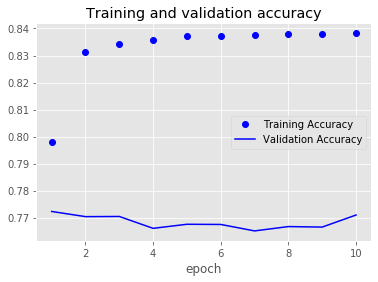

In [137]:
plot_training_history(dag_history)

In [103]:
dag_model = load_model("models/DAGLSTMover50.h5")

In [138]:
results = dag_model.evaluate(X_test_dag, Y_test_dag)
print(f"test loss: {results[0]}, test acc:{results[1]}")
results

 50208/366877 [===>..........................] - ETA: 5:21 - loss: 1.1549 - accuracy: 0.62 - ETA: 1:40 - loss: 1.1047 - accuracy: 0.67 - ETA: 1:27 - loss: 0.7852 - accuracy: 0.76 - ETA: 1:20 - loss: 0.6590 - accuracy: 0.81 - ETA: 1:18 - loss: 0.5715 - accuracy: 0.85 - ETA: 1:15 - loss: 0.5045 - accuracy: 0.88 - ETA: 1:14 - loss: 0.4607 - accuracy: 0.90 - ETA: 1:13 - loss: 0.4298 - accuracy: 0.91 - ETA: 1:12 - loss: 0.4069 - accuracy: 0.92 - ETA: 1:11 - loss: 0.3892 - accuracy: 0.92 - ETA: 1:10 - loss: 0.3751 - accuracy: 0.93 - ETA: 1:10 - loss: 0.3636 - accuracy: 0.93 - ETA: 1:10 - loss: 0.3552 - accuracy: 0.94 - ETA: 1:09 - loss: 0.3477 - accuracy: 0.94 - ETA: 1:09 - loss: 0.3569 - accuracy: 0.94 - ETA: 1:09 - loss: 0.3498 - accuracy: 0.94 - ETA: 1:08 - loss: 0.3436 - accuracy: 0.94 - ETA: 1:08 - loss: 0.3381 - accuracy: 0.94 - ETA: 1:08 - loss: 0.3332 - accuracy: 0.95 - ETA: 1:08 - loss: 0.3288 - accuracy: 0.95 - ETA: 1:07 - loss: 0.3249 - accuracy: 0.95 - ETA: 1:07 - loss: 0.3214 - 

 98272/366877 [=======>......................] - ETA: 1:00 - loss: 0.8589 - accuracy: 0.79 - ETA: 1:00 - loss: 0.8610 - accuracy: 0.79 - ETA: 1:00 - loss: 0.8633 - accuracy: 0.79 - ETA: 1:00 - loss: 0.8634 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8635 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8642 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8643 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8640 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8634 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8643 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8652 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8662 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8671 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8685 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8686 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8671 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8655 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8637 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8639 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8651 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8659 - accuracy: 0.78 - ETA: 1:00 - loss: 0.8683 - 

150112/366877 [===========>..................] - ETA: 52s - loss: 0.9917 - accuracy: 0.742 - ETA: 52s - loss: 0.9907 - accuracy: 0.742 - ETA: 52s - loss: 0.9894 - accuracy: 0.742 - ETA: 52s - loss: 0.9881 - accuracy: 0.742 - ETA: 52s - loss: 0.9868 - accuracy: 0.743 - ETA: 52s - loss: 0.9855 - accuracy: 0.743 - ETA: 52s - loss: 0.9842 - accuracy: 0.743 - ETA: 52s - loss: 0.9829 - accuracy: 0.743 - ETA: 52s - loss: 0.9817 - accuracy: 0.743 - ETA: 52s - loss: 0.9803 - accuracy: 0.743 - ETA: 52s - loss: 0.9790 - accuracy: 0.743 - ETA: 52s - loss: 0.9777 - accuracy: 0.743 - ETA: 52s - loss: 0.9765 - accuracy: 0.744 - ETA: 52s - loss: 0.9752 - accuracy: 0.744 - ETA: 52s - loss: 0.9738 - accuracy: 0.744 - ETA: 52s - loss: 0.9730 - accuracy: 0.744 - ETA: 52s - loss: 0.9718 - accuracy: 0.744 - ETA: 52s - loss: 0.9705 - accuracy: 0.744 - ETA: 52s - loss: 0.9692 - accuracy: 0.744 - ETA: 52s - loss: 0.9680 - accuracy: 0.745 - ETA: 52s - loss: 0.9668 - accuracy: 0.745 - ETA: 52s - loss: 0.9656 - a

203136/366877 [===============>..............] - ETA: 42s - loss: 1.0899 - accuracy: 0.728 - ETA: 42s - loss: 1.0889 - accuracy: 0.728 - ETA: 41s - loss: 1.0878 - accuracy: 0.729 - ETA: 41s - loss: 1.0867 - accuracy: 0.729 - ETA: 41s - loss: 1.0858 - accuracy: 0.729 - ETA: 41s - loss: 1.0847 - accuracy: 0.729 - ETA: 41s - loss: 1.0836 - accuracy: 0.729 - ETA: 41s - loss: 1.0825 - accuracy: 0.729 - ETA: 41s - loss: 1.0816 - accuracy: 0.730 - ETA: 41s - loss: 1.0806 - accuracy: 0.730 - ETA: 41s - loss: 1.0795 - accuracy: 0.730 - ETA: 41s - loss: 1.0786 - accuracy: 0.730 - ETA: 41s - loss: 1.0777 - accuracy: 0.731 - ETA: 41s - loss: 1.0766 - accuracy: 0.731 - ETA: 41s - loss: 1.0754 - accuracy: 0.731 - ETA: 41s - loss: 1.0742 - accuracy: 0.731 - ETA: 41s - loss: 1.0733 - accuracy: 0.731 - ETA: 41s - loss: 1.0715 - accuracy: 0.732 - ETA: 41s - loss: 1.0716 - accuracy: 0.732 - ETA: 40s - loss: 1.0716 - accuracy: 0.731 - ETA: 40s - loss: 1.0730 - accuracy: 0.731 - ETA: 40s - loss: 1.0728 - a

256352/366877 [===================>..........] - ETA: 31s - loss: 0.9791 - accuracy: 0.763 - ETA: 31s - loss: 0.9783 - accuracy: 0.763 - ETA: 31s - loss: 0.9775 - accuracy: 0.763 - ETA: 31s - loss: 0.9767 - accuracy: 0.763 - ETA: 31s - loss: 0.9775 - accuracy: 0.763 - ETA: 31s - loss: 0.9776 - accuracy: 0.763 - ETA: 30s - loss: 0.9778 - accuracy: 0.763 - ETA: 30s - loss: 0.9772 - accuracy: 0.763 - ETA: 30s - loss: 0.9767 - accuracy: 0.763 - ETA: 30s - loss: 0.9764 - accuracy: 0.763 - ETA: 30s - loss: 0.9762 - accuracy: 0.762 - ETA: 30s - loss: 0.9772 - accuracy: 0.762 - ETA: 30s - loss: 0.9782 - accuracy: 0.762 - ETA: 30s - loss: 0.9791 - accuracy: 0.762 - ETA: 30s - loss: 0.9811 - accuracy: 0.761 - ETA: 30s - loss: 0.9838 - accuracy: 0.761 - ETA: 30s - loss: 0.9872 - accuracy: 0.761 - ETA: 30s - loss: 0.9891 - accuracy: 0.760 - ETA: 30s - loss: 0.9907 - accuracy: 0.760 - ETA: 30s - loss: 0.9898 - accuracy: 0.760 - ETA: 30s - loss: 0.9889 - accuracy: 0.760 - ETA: 30s - loss: 0.9881 - a

310656/366877 [========================>.....] - ETA: 20s - loss: 0.9783 - accuracy: 0.761 - ETA: 20s - loss: 0.9782 - accuracy: 0.761 - ETA: 20s - loss: 0.9776 - accuracy: 0.761 - ETA: 20s - loss: 0.9773 - accuracy: 0.761 - ETA: 20s - loss: 0.9768 - accuracy: 0.761 - ETA: 20s - loss: 0.9765 - accuracy: 0.761 - ETA: 20s - loss: 0.9760 - accuracy: 0.762 - ETA: 20s - loss: 0.9755 - accuracy: 0.762 - ETA: 20s - loss: 0.9749 - accuracy: 0.762 - ETA: 20s - loss: 0.9745 - accuracy: 0.762 - ETA: 20s - loss: 0.9740 - accuracy: 0.762 - ETA: 20s - loss: 0.9733 - accuracy: 0.762 - ETA: 20s - loss: 0.9727 - accuracy: 0.762 - ETA: 20s - loss: 0.9725 - accuracy: 0.762 - ETA: 20s - loss: 0.9719 - accuracy: 0.762 - ETA: 20s - loss: 0.9713 - accuracy: 0.762 - ETA: 20s - loss: 0.9709 - accuracy: 0.762 - ETA: 20s - loss: 0.9706 - accuracy: 0.763 - ETA: 19s - loss: 0.9700 - accuracy: 0.763 - ETA: 19s - loss: 0.9697 - accuracy: 0.763 - ETA: 19s - loss: 0.9692 - accuracy: 0.763 - ETA: 19s - loss: 0.9685 - a

366877/366877 [==============================] - ETA: 10s - loss: 0.9592 - accuracy: 0.763 - ETA: 10s - loss: 0.9588 - accuracy: 0.763 - ETA: 10s - loss: 0.9585 - accuracy: 0.763 - ETA: 10s - loss: 0.9585 - accuracy: 0.763 - ETA: 10s - loss: 0.9583 - accuracy: 0.763 - ETA: 10s - loss: 0.9589 - accuracy: 0.763 - ETA: 10s - loss: 0.9599 - accuracy: 0.763 - ETA: 10s - loss: 0.9595 - accuracy: 0.763 - ETA: 10s - loss: 0.9590 - accuracy: 0.763 - ETA: 10s - loss: 0.9584 - accuracy: 0.763 - ETA: 9s - loss: 0.9578 - accuracy: 0.763 - ETA: 9s - loss: 0.9573 - accuracy: 0.76 - ETA: 9s - loss: 0.9567 - accuracy: 0.76 - ETA: 9s - loss: 0.9571 - accuracy: 0.76 - ETA: 9s - loss: 0.9575 - accuracy: 0.76 - ETA: 9s - loss: 0.9569 - accuracy: 0.76 - ETA: 9s - loss: 0.9564 - accuracy: 0.76 - ETA: 9s - loss: 0.9558 - accuracy: 0.76 - ETA: 9s - loss: 0.9553 - accuracy: 0.76 - ETA: 9s - loss: 0.9548 - accuracy: 0.76 - ETA: 9s - loss: 0.9542 - accuracy: 0.76 - ETA: 9s - loss: 0.9537 - accuracy: 0.76 - ETA: 9

[0.9805230548767386, 0.7592272]

In [51]:
store_keras_model(dag_model,'DAGLSTM50502')
#dag_model.save_weight("models/DAGLSTMover")
dag_model.save("models/DAGLSTMover502.h5")
#dag_model = load_model("models/DAGLSTM50.h5")

Saved model to disk


In [57]:
dim_embed_dag = 20

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

dag_batch_size = 64
dag_epochs = 10
dag_validation_split = 0.2
dag_verbose = 2

dag_model2 = Sequential()
dag_model2.add(Embedding(input_dim=n_commands_dag, output_dim=dim_embed_dag, input_length = dag_train_len))
dag_model2.add(LSTM(1024, return_sequences = True))
dag_model2.add(LSTM(2048, return_sequences = True))
dag_model2.add(LSTM(1024))
dag_model2.add(Dense(512, activation = 'relu'))
dag_model2.add(Dense(n_commands_dag, activation='softmax'))

# callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy', min_delta=0.5, patience=3, verbose=0,
#     mode='auto', baseline=None, restore_best_weights=False
# )

dag_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dag_model2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 20)            160       
_________________________________________________________________
lstm_36 (LSTM)               (None, 50, 1024)          4280320   
_________________________________________________________________
lstm_37 (LSTM)               (None, 50, 2048)          25174016  
_________________________________________________________________
lstm_38 (LSTM)               (None, 1024)              12587008  
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 4104      
Total params: 42,570,408
Trainable params: 42,570,408
Non-trainable params: 0
_________________________________________

In [58]:
dag_history2 = dag_model2.fit(X_train_dag, Y_train_dag, batch_size=dag_batch_size, epochs=dag_epochs, 
                    validation_split=dag_validation_split, verbose = 1)

Train on 735456 samples, validate on 183864 samples
Epoch 1/10


 11264/735456 [..............................] - ETA: 7:03:54 - loss: 2.0793 - accuracy: 0.015 - ETA: 3:42:05 - loss: 2.0185 - accuracy: 0.335 - ETA: 2:34:25 - loss: 2.6689 - accuracy: 0.447 - ETA: 2:00:41 - loss: 2.6492 - accuracy: 0.378 - ETA: 1:40:22 - loss: 2.5040 - accuracy: 0.403 - ETA: 1:26:51 - loss: 2.3081 - accuracy: 0.440 - ETA: 1:17:09 - loss: 2.1942 - accuracy: 0.442 - ETA: 1:09:53 - loss: 2.0890 - accuracy: 0.459 - ETA: 1:04:15 - loss: 1.9863 - accuracy: 0.475 - ETA: 59:45 - loss: 1.9196 - accuracy: 0.4781  - ETA: 56:06 - loss: 1.8836 - accuracy: 0.483 - ETA: 52:59 - loss: 1.8439 - accuracy: 0.485 - ETA: 50:21 - loss: 1.8063 - accuracy: 0.491 - ETA: 48:08 - loss: 1.7911 - accuracy: 0.482 - ETA: 46:12 - loss: 1.7524 - accuracy: 0.494 - ETA: 44:30 - loss: 1.7240 - accuracy: 0.502 - ETA: 42:59 - loss: 1.6918 - accuracy: 0.509 - ETA: 41:39 - loss: 1.6563 - accuracy: 0.518 - ETA: 40:32 - loss: 1.6204 - accuracy: 0.527 - ETA: 39:27 - loss: 1.5992 - accuracy: 0.532 - ETA: 38:30 

 45440/735456 [>.............................] - ETA: 19:26 - loss: 1.2468 - accuracy: 0.591 - ETA: 19:26 - loss: 1.2471 - accuracy: 0.591 - ETA: 19:26 - loss: 1.2469 - accuracy: 0.591 - ETA: 19:26 - loss: 1.2470 - accuracy: 0.591 - ETA: 19:26 - loss: 1.2468 - accuracy: 0.591 - ETA: 19:25 - loss: 1.2472 - accuracy: 0.591 - ETA: 19:25 - loss: 1.2471 - accuracy: 0.591 - ETA: 19:25 - loss: 1.2470 - accuracy: 0.591 - ETA: 19:25 - loss: 1.2467 - accuracy: 0.591 - ETA: 19:24 - loss: 1.2464 - accuracy: 0.592 - ETA: 19:24 - loss: 1.2465 - accuracy: 0.591 - ETA: 19:24 - loss: 1.2464 - accuracy: 0.592 - ETA: 19:24 - loss: 1.2468 - accuracy: 0.591 - ETA: 19:24 - loss: 1.2468 - accuracy: 0.591 - ETA: 19:23 - loss: 1.2467 - accuracy: 0.591 - ETA: 19:23 - loss: 1.2465 - accuracy: 0.591 - ETA: 19:23 - loss: 1.2466 - accuracy: 0.591 - ETA: 19:23 - loss: 1.2462 - accuracy: 0.591 - ETA: 19:23 - loss: 1.2461 - accuracy: 0.591 - ETA: 19:22 - loss: 1.2458 - accuracy: 0.592 - ETA: 19:22 - loss: 1.2453 - acc

 56832/735456 [=>............................] - ETA: 18:52 - loss: 1.2355 - accuracy: 0.594 - ETA: 18:52 - loss: 1.2355 - accuracy: 0.594 - ETA: 18:52 - loss: 1.2355 - accuracy: 0.594 - ETA: 18:51 - loss: 1.2353 - accuracy: 0.594 - ETA: 18:51 - loss: 1.2355 - accuracy: 0.594 - ETA: 18:51 - loss: 1.2354 - accuracy: 0.594 - ETA: 18:51 - loss: 1.2355 - accuracy: 0.594 - ETA: 18:51 - loss: 1.2356 - accuracy: 0.594 - ETA: 18:51 - loss: 1.2356 - accuracy: 0.594 - ETA: 18:50 - loss: 1.2353 - accuracy: 0.594 - ETA: 18:50 - loss: 1.2352 - accuracy: 0.594 - ETA: 18:50 - loss: 1.2349 - accuracy: 0.595 - ETA: 18:50 - loss: 1.2343 - accuracy: 0.595 - ETA: 18:50 - loss: 1.2341 - accuracy: 0.595 - ETA: 18:49 - loss: 1.2344 - accuracy: 0.595 - ETA: 18:49 - loss: 1.2341 - accuracy: 0.595 - ETA: 18:49 - loss: 1.2340 - accuracy: 0.595 - ETA: 18:49 - loss: 1.2342 - accuracy: 0.595 - ETA: 18:49 - loss: 1.2340 - accuracy: 0.595 - ETA: 18:49 - loss: 1.2340 - accuracy: 0.595 - ETA: 18:48 - loss: 1.2342 - acc

 68224/735456 [=>............................] - ETA: 18:24 - loss: 1.2292 - accuracy: 0.596 - ETA: 18:24 - loss: 1.2290 - accuracy: 0.596 - ETA: 18:23 - loss: 1.2290 - accuracy: 0.596 - ETA: 18:23 - loss: 1.2290 - accuracy: 0.596 - ETA: 18:23 - loss: 1.2290 - accuracy: 0.596 - ETA: 18:23 - loss: 1.2288 - accuracy: 0.596 - ETA: 18:23 - loss: 1.2287 - accuracy: 0.596 - ETA: 18:23 - loss: 1.2287 - accuracy: 0.596 - ETA: 18:23 - loss: 1.2285 - accuracy: 0.596 - ETA: 18:22 - loss: 1.2286 - accuracy: 0.596 - ETA: 18:22 - loss: 1.2286 - accuracy: 0.596 - ETA: 18:22 - loss: 1.2284 - accuracy: 0.596 - ETA: 18:22 - loss: 1.2285 - accuracy: 0.596 - ETA: 18:22 - loss: 1.2284 - accuracy: 0.596 - ETA: 18:22 - loss: 1.2284 - accuracy: 0.596 - ETA: 18:21 - loss: 1.2283 - accuracy: 0.596 - ETA: 18:21 - loss: 1.2285 - accuracy: 0.596 - ETA: 18:21 - loss: 1.2285 - accuracy: 0.596 - ETA: 18:21 - loss: 1.2286 - accuracy: 0.596 - ETA: 18:21 - loss: 1.2285 - accuracy: 0.596 - ETA: 18:21 - loss: 1.2284 - acc

 79616/735456 [==>...........................] - ETA: 17:59 - loss: 1.2239 - accuracy: 0.597 - ETA: 17:59 - loss: 1.2239 - accuracy: 0.597 - ETA: 17:59 - loss: 1.2237 - accuracy: 0.597 - ETA: 17:59 - loss: 1.2236 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2237 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2237 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2238 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2239 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2239 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2240 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2240 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2239 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2238 - accuracy: 0.597 - ETA: 17:58 - loss: 1.2237 - accuracy: 0.597 - ETA: 17:57 - loss: 1.2238 - accuracy: 0.597 - ETA: 17:57 - loss: 1.2236 - accuracy: 0.597 - ETA: 17:57 - loss: 1.2235 - accuracy: 0.597 - ETA: 17:57 - loss: 1.2235 - accuracy: 0.597 - ETA: 17:57 - loss: 1.2236 - accuracy: 0.597 - ETA: 17:57 - loss: 1.2234 - accuracy: 0.597 - ETA: 17:57 - loss: 1.2235 - acc

 91008/735456 [==>...........................] - ETA: 17:38 - loss: 1.2208 - accuracy: 0.597 - ETA: 17:38 - loss: 1.2207 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2208 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2209 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2210 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2210 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2209 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2209 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2210 - accuracy: 0.597 - ETA: 17:37 - loss: 1.2208 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2207 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2206 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2205 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2205 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2205 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2203 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2203 - accuracy: 0.597 - ETA: 17:36 - loss: 1.2202 - accuracy: 0.597 - ETA: 17:35 - loss: 1.2202 - accuracy: 0.597 - ETA: 17:35 - loss: 1.2201 - accuracy: 0.597 - ETA: 17:35 - loss: 1.2202 - acc

102400/735456 [===>..........................] - ETA: 17:16 - loss: 1.2170 - accuracy: 0.598 - ETA: 17:16 - loss: 1.2170 - accuracy: 0.598 - ETA: 17:16 - loss: 1.2170 - accuracy: 0.598 - ETA: 17:16 - loss: 1.2171 - accuracy: 0.598 - ETA: 17:16 - loss: 1.2170 - accuracy: 0.598 - ETA: 17:16 - loss: 1.2170 - accuracy: 0.598 - ETA: 17:16 - loss: 1.2170 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2169 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2169 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2167 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2167 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2166 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2165 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2166 - accuracy: 0.598 - ETA: 17:15 - loss: 1.2167 - accuracy: 0.598 - ETA: 17:14 - loss: 1.2167 - accuracy: 0.598 - ETA: 17:14 - loss: 1.2168 - accuracy: 0.598 - ETA: 17:14 - loss: 1.2166 - accuracy: 0.598 - ETA: 17:14 - loss: 1.2166 - accuracy: 0.598 - ETA: 17:14 - loss: 1.2166 - accuracy: 0.598 - ETA: 17:14 - loss: 1.2166 - acc

113792/735456 [===>..........................] - ETA: 16:55 - loss: 1.2159 - accuracy: 0.598 - ETA: 16:55 - loss: 1.2159 - accuracy: 0.598 - ETA: 16:55 - loss: 1.2159 - accuracy: 0.598 - ETA: 16:55 - loss: 1.2160 - accuracy: 0.598 - ETA: 16:55 - loss: 1.2159 - accuracy: 0.598 - ETA: 16:55 - loss: 1.2157 - accuracy: 0.598 - ETA: 16:55 - loss: 1.2157 - accuracy: 0.598 - ETA: 16:55 - loss: 1.2157 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2156 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2156 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2156 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2156 - accuracy: 0.598 - ETA: 16:54 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:53 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:53 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:53 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:53 - loss: 1.2155 - acc

125184/735456 [====>.........................] - ETA: 16:35 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:35 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:35 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:35 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:35 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:35 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:35 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2155 - accuracy: 0.598 - ETA: 16:34 - loss: 1.2154 - accuracy: 0.598 - ETA: 16:33 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:33 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:33 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:33 - loss: 1.2153 - accuracy: 0.598 - ETA: 16:33 - loss: 1.2154 - acc

136576/735456 [====>.........................] - ETA: 16:15 - loss: 1.2142 - accuracy: 0.598 - ETA: 16:15 - loss: 1.2143 - accuracy: 0.598 - ETA: 16:15 - loss: 1.2143 - accuracy: 0.598 - ETA: 16:15 - loss: 1.2143 - accuracy: 0.598 - ETA: 16:15 - loss: 1.2144 - accuracy: 0.598 - ETA: 16:15 - loss: 1.2143 - accuracy: 0.598 - ETA: 16:15 - loss: 1.2144 - accuracy: 0.598 - ETA: 16:15 - loss: 1.2144 - accuracy: 0.598 - ETA: 16:14 - loss: 1.2146 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2145 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2146 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2146 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2147 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2146 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2145 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2145 - accuracy: 0.597 - ETA: 16:14 - loss: 1.2145 - accuracy: 0.597 - ETA: 16:13 - loss: 1.2145 - accuracy: 0.597 - ETA: 16:13 - loss: 1.2145 - accuracy: 0.597 - ETA: 16:13 - loss: 1.2146 - accuracy: 0.597 - ETA: 16:13 - loss: 1.2145 - acc

147968/735456 [=====>........................] - ETA: 15:56 - loss: 1.2144 - accuracy: 0.597 - ETA: 15:56 - loss: 1.2144 - accuracy: 0.597 - ETA: 15:56 - loss: 1.2144 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2142 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2141 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2142 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2141 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2142 - accuracy: 0.597 - ETA: 15:55 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2142 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2142 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2143 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2142 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2142 - accuracy: 0.597 - ETA: 15:54 - loss: 1.2143 - acc

159360/735456 [=====>........................] - ETA: 15:36 - loss: 1.2131 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2129 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2129 - accuracy: 0.597 - ETA: 15:36 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2130 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2129 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2129 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2129 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2129 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2128 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2128 - accuracy: 0.597 - ETA: 15:35 - loss: 1.2128 - accuracy: 0.597 - ETA: 15:34 - loss: 1.2127 - accuracy: 0.597 - ETA: 15:34 - loss: 1.2128 - acc

170752/735456 [=====>........................] - ETA: 15:17 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2136 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2134 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2134 - accuracy: 0.597 - ETA: 15:17 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2136 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:16 - loss: 1.2135 - accuracy: 0.597 - ETA: 15:15 - loss: 1.2136 - accuracy: 0.597 - ETA: 15:15 - loss: 1.2135 - accuracy: 0.596 - ETA: 15:15 - loss: 1.2136 - acc

182144/735456 [======>.......................] - ETA: 14:58 - loss: 1.2131 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2131 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2131 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2130 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2130 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2130 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2129 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2129 - accuracy: 0.596 - ETA: 14:58 - loss: 1.2129 - accuracy: 0.597 - ETA: 14:58 - loss: 1.2128 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2128 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2128 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2127 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2127 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2128 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2127 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2128 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2127 - accuracy: 0.597 - ETA: 14:57 - loss: 1.2127 - accuracy: 0.597 - ETA: 14:56 - loss: 1.2126 - accuracy: 0.597 - ETA: 14:56 - loss: 1.2126 - acc

193536/735456 [======>.......................] - ETA: 14:40 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:40 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:40 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:39 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2113 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:38 - loss: 1.2114 - acc

204928/735456 [=======>......................] - ETA: 14:21 - loss: 1.2115 - accuracy: 0.597 - ETA: 14:21 - loss: 1.2115 - accuracy: 0.597 - ETA: 14:21 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:21 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:21 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:21 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2116 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2115 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2115 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2115 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:20 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:19 - loss: 1.2115 - accuracy: 0.597 - ETA: 14:19 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:19 - loss: 1.2115 - accuracy: 0.597 - ETA: 14:19 - loss: 1.2114 - accuracy: 0.597 - ETA: 14:19 - loss: 1.2114 - acc

216320/735456 [=======>......................] - ETA: 14:03 - loss: 1.2102 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2102 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2102 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2102 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2102 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:02 - loss: 1.2104 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2104 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2104 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2103 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2104 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2104 - accuracy: 0.597 - ETA: 14:01 - loss: 1.2104 - accuracy: 0.597 - ETA: 14:00 - loss: 1.2105 - acc

227712/735456 [========>.....................] - ETA: 13:44 - loss: 1.2098 - accuracy: 0.597 - ETA: 13:44 - loss: 1.2098 - accuracy: 0.597 - ETA: 13:44 - loss: 1.2098 - accuracy: 0.597 - ETA: 13:44 - loss: 1.2098 - accuracy: 0.597 - ETA: 13:44 - loss: 1.2098 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2098 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:43 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:42 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:42 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:42 - loss: 1.2101 - accuracy: 0.597 - ETA: 13:42 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:42 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:42 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:42 - loss: 1.2101 - acc

239104/735456 [========>.....................] - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:25 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:24 - loss: 1.2099 - accuracy: 0.597 - ETA: 13:23 - loss: 1.2100 - accuracy: 0.597 - ETA: 13:23 - loss: 1.2100 - acc

250496/735456 [=========>....................] - ETA: 13:07 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:07 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:07 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:07 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:07 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:07 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:06 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:05 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:05 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:05 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:05 - loss: 1.2094 - accuracy: 0.597 - ETA: 13:05 - loss: 1.2095 - accuracy: 0.597 - ETA: 13:05 - loss: 1.2095 - acc

261888/735456 [=========>....................] - ETA: 12:49 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:49 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:48 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:47 - loss: 1.2090 - acc

273280/735456 [==========>...................] - ETA: 12:30 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:30 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:30 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:30 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:30 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:30 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:30 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:30 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:29 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:28 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:28 - loss: 1.2093 - accuracy: 0.596 - ETA: 12:28 - loss: 1.2093 - acc

284672/735456 [==========>...................] - ETA: 12:12 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:12 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:12 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:12 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:12 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:11 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:10 - loss: 1.2092 - accuracy: 0.596 - ETA: 12:10 - loss: 1.2091 - accuracy: 0.596 - ETA: 12:10 - loss: 1.2091 - accuracy: 0.597 - ETA: 12:10 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:10 - loss: 1.2090 - accuracy: 0.597 - ETA: 12:10 - loss: 1.2090 - acc

296064/735456 [===========>..................] - ETA: 11:54 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:54 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:54 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:53 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2083 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2082 - accuracy: 0.597 - ETA: 11:52 - loss: 1.2082 - acc

307456/735456 [===========>..................] - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:35 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2081 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2080 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2079 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2079 - accuracy: 0.597 - ETA: 11:34 - loss: 1.2079 - accuracy: 0.597 - ETA: 11:33 - loss: 1.2079 - acc

318848/735456 [============>.................] - ETA: 11:17 - loss: 1.2076 - accuracy: 0.597 - ETA: 11:17 - loss: 1.2075 - accuracy: 0.597 - ETA: 11:17 - loss: 1.2075 - accuracy: 0.597 - ETA: 11:17 - loss: 1.2075 - accuracy: 0.597 - ETA: 11:17 - loss: 1.2075 - accuracy: 0.597 - ETA: 11:17 - loss: 1.2075 - accuracy: 0.597 - ETA: 11:17 - loss: 1.2075 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2075 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:16 - loss: 1.2074 - accuracy: 0.597 - ETA: 11:15 - loss: 1.2073 - accuracy: 0.597 - ETA: 11:15 - loss: 1.2073 - accuracy: 0.597 - ETA: 11:15 - loss: 1.2073 - accuracy: 0.597 - ETA: 11:15 - loss: 1.2073 - acc

330240/735456 [============>.................] - ETA: 10:59 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:59 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:59 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:59 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:59 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2071 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2071 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2071 - accuracy: 0.597 - ETA: 10:58 - loss: 1.2071 - accuracy: 0.597 - ETA: 10:57 - loss: 1.2071 - accuracy: 0.597 - ETA: 10:57 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:57 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:57 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:57 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:57 - loss: 1.2070 - acc

341632/735456 [============>.................] - ETA: 10:41 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:41 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:41 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:41 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:40 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:39 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:39 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:39 - loss: 1.2066 - accuracy: 0.597 - ETA: 10:39 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:39 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:39 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:39 - loss: 1.2066 - acc

353024/735456 [=============>................] - ETA: 10:23 - loss: 1.2068 - accuracy: 0.597 - ETA: 10:23 - loss: 1.2068 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2068 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2068 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2068 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2068 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:22 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - accuracy: 0.597 - ETA: 10:21 - loss: 1.2067 - acc

364736/735456 [=============>................] - ETA: 10:05 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:04 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2070 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:03 - loss: 1.2069 - accuracy: 0.597 - ETA: 10:02 - loss: 1.2069 - acc

376640/735456 [==============>...............] - ETA: 9:46 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:46 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:46 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:46 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:45 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:44 - loss: 1.2068 - 

388544/735456 [==============>...............] - ETA: 9:27 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:27 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:27 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:27 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:27 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:26 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:25 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:25 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:25 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:25 - loss: 1.2068 - accuracy: 0.59 - ETA: 9:25 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:25 - loss: 1.2069 - accuracy: 0.59 - ETA: 9:25 - loss: 1.2068 - 

400448/735456 [===============>..............] - ETA: 9:08 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:08 - loss: 1.2064 - accuracy: 0.59 - ETA: 9:08 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:08 - loss: 1.2064 - accuracy: 0.59 - ETA: 9:08 - loss: 1.2064 - accuracy: 0.59 - ETA: 9:08 - loss: 1.2064 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2064 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2064 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2064 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2066 - accuracy: 0.59 - ETA: 9:07 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:06 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:06 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:06 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:06 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:06 - loss: 1.2065 - accuracy: 0.59 - ETA: 9:06 - loss: 1.2065 - 

412352/735456 [===============>..............] - ETA: 8:49 - loss: 1.2066 - accuracy: 0.59 - ETA: 8:49 - loss: 1.2066 - accuracy: 0.59 - ETA: 8:49 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:49 - loss: 1.2066 - accuracy: 0.59 - ETA: 8:49 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:49 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:49 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2066 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2066 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2066 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:48 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:47 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:47 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:47 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:47 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:47 - loss: 1.2065 - 

424256/735456 [================>.............] - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:30 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2061 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:29 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:28 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:28 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:28 - loss: 1.2062 - accuracy: 0.59 - ETA: 8:28 - loss: 1.2063 - 

436160/735456 [================>.............] - ETA: 8:11 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:11 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2065 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:10 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:09 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:09 - loss: 1.2064 - accuracy: 0.59 - ETA: 8:09 - loss: 1.2064 - 

448064/735456 [=================>............] - ETA: 7:52 - loss: 1.2063 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2063 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2063 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2063 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:52 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:51 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:50 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:50 - loss: 1.2062 - 

459968/735456 [=================>............] - ETA: 7:34 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:34 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:33 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:32 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:31 - loss: 1.2061 - 

471872/735456 [==================>...........] - ETA: 7:15 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:15 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:15 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:14 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2061 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2062 - accuracy: 0.59 - ETA: 7:13 - loss: 1.2061 - 

483776/735456 [==================>...........] - ETA: 6:56 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:56 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:56 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:56 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:55 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2059 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2060 - accuracy: 0.59 - ETA: 6:54 - loss: 1.2060 - 

495680/735456 [===================>..........] - ETA: 6:37 - loss: 1.2057 - accuracy: 0.59 - ETA: 6:37 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:37 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:37 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:37 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:37 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:36 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:35 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:35 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:35 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:35 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:35 - loss: 1.2056 - accuracy: 0.59 - ETA: 6:35 - loss: 1.2056 - 

507584/735456 [===================>..........] - ETA: 6:18 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:18 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:18 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:18 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:18 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:18 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:18 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2054 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2054 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2054 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2054 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:17 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:16 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:16 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:16 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:16 - loss: 1.2053 - accuracy: 0.59 - ETA: 6:16 - loss: 1.2053 - 

519488/735456 [====================>.........] - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:59 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:58 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:57 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:57 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:57 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:57 - loss: 1.2052 - 

531392/735456 [====================>.........] - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:40 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:39 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:38 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:38 - loss: 1.2052 - 

543296/735456 [=====================>........] - ETA: 5:22 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:22 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:21 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:20 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:19 - loss: 1.2052 - 

555200/735456 [=====================>........] - ETA: 5:03 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:03 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:03 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:02 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2052 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2053 - accuracy: 0.59 - ETA: 5:01 - loss: 1.2053 - 

567104/735456 [======================>.......] - ETA: 4:44 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:44 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:44 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:44 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:44 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:43 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:42 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:42 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:42 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:42 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:42 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:42 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:42 - loss: 1.2053 - 

579008/735456 [======================>.......] - ETA: 4:25 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:25 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:25 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:25 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:25 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:25 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:25 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:24 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:23 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:23 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:23 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:23 - loss: 1.2051 - accuracy: 0.59 - ETA: 4:23 - loss: 1.2051 - 

590912/735456 [=======================>......] - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:06 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2054 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2054 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2054 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:05 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:04 - loss: 1.2053 - accuracy: 0.59 - ETA: 4:04 - loss: 1.2054 - accuracy: 0.59 - ETA: 4:04 - loss: 1.2053 - 

602816/735456 [=======================>......] - ETA: 3:48 - loss: 1.2052 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2052 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:47 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:46 - loss: 1.2051 - accuracy: 0.59 - ETA: 3:45 - loss: 1.2052 - 

614720/735456 [========================>.....] - ETA: 3:29 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:29 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:29 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:28 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:27 - loss: 1.2049 - 

626624/735456 [========================>.....] - ETA: 3:10 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:10 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:10 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:10 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:10 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:09 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:08 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:08 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:08 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:08 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:08 - loss: 1.2050 - accuracy: 0.59 - ETA: 3:08 - loss: 1.2049 - accuracy: 0.59 - ETA: 3:08 - loss: 1.2049 - 

638528/735456 [=========================>....] - ETA: 2:51 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:51 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:51 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:51 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:51 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:51 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:51 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:50 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:49 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:49 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:49 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:49 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:49 - loss: 1.2047 - 

650432/735456 [=========================>....] - ETA: 2:32 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:32 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2047 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:31 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:30 - loss: 1.2046 - accuracy: 0.59 - ETA: 2:30 - loss: 1.2046 - 

662336/735456 [==========================>...] - ETA: 2:14 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:14 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:13 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - accuracy: 0.59 - ETA: 2:12 - loss: 1.2048 - 

674240/735456 [==========================>...] - ETA: 1:55 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:55 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:55 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:55 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:54 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:53 - loss: 1.2048 - 

686144/735456 [==========================>...] - ETA: 1:36 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:36 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:36 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:36 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:36 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:36 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2049 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:34 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:34 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:34 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:34 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:34 - loss: 1.2048 - accuracy: 0.59 - ETA: 1:34 - loss: 1.2048 - 

698048/735456 [===========================>..] - ETA: 1:17 - loss: 1.2046 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2046 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2046 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2046 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2046 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2046 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:17 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:16 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:15 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:15 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:15 - loss: 1.2045 - accuracy: 0.59 - ETA: 1:15 - loss: 1.2045 - 

709952/735456 [===========================>..] - ETA: 59s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 58s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 57s - loss: 1.2042 - accuracy: 0.596 - ETA: 56s - loss: 1.2042 - accuracy: 0.596 - ETA: 56s - loss: 1.2042 - a

721856/735456 [============================>.] - ETA: 40s - loss: 1.2043 - accuracy: 0.596 - ETA: 40s - loss: 1.2043 - accuracy: 0.596 - ETA: 40s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 39s - loss: 1.2043 - accuracy: 0.596 - ETA: 38s - loss: 1.2043 - accuracy: 0.596 - ETA: 38s - loss: 1.2043 - accuracy: 0.596 - ETA: 38s - loss: 1.2043 - accuracy: 0.596 - ETA: 38s - loss: 1.2043 - accuracy: 0.596 - ETA: 38s - loss: 1.2043 - accuracy: 0.596 - ETA: 38s - loss: 1.2042 - accuracy: 0.596 - ETA: 38s - loss: 1.2042 - accuracy: 0.596 - ETA: 38s - loss: 1.2043 - accuracy: 0.596 - ETA: 38s - loss: 1.2042 - accuracy: 0.596 - ETA: 38s - loss: 1.2043 - a

733952/735456 [============================>.] - ETA: 21s - loss: 1.2043 - accuracy: 0.596 - ETA: 21s - loss: 1.2043 - accuracy: 0.596 - ETA: 21s - loss: 1.2043 - accuracy: 0.596 - ETA: 21s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 20s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - accuracy: 0.596 - ETA: 19s - loss: 1.2043 - a

735456/735456 [==============================] - ETA: 2s - loss: 1.2043 - accuracy: 0.59 - ETA: 2s - loss: 1.2043 - accuracy: 0.59 - ETA: 2s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 1s - loss: 1.2043 - accuracy: 0.59 - ETA: 0s - loss: 1.2043 - accuracy: 0.59 - ETA: 0s - loss: 1.2043 - accuracy: 0.59 - ETA: 0s - loss: 1.2043 - accuracy: 0.59 - ETA: 0s - loss: 1.2043 - accuracy: 0.59 - ETA: 0s - loss: 1.2043 - accuracy: 0.59 - ETA: 0s - loss: 1.2042 - accuracy: 0.59 - ETA: 0s - loss: 1.2042 - accuracy: 0.59 - ETA: 0s - loss: 1.2042 - accuracy: 0.59 - ETA: 0s - loss: 1.2042 - accuracy: 0.59 - ETA: 0s - loss: 1.2042 - ac

 11392/735456 [..............................] - ETA: 19:09 - loss: 1.1669 - accuracy: 0.578 - ETA: 19:14 - loss: 1.1370 - accuracy: 0.593 - ETA: 19:12 - loss: 1.1096 - accuracy: 0.614 - ETA: 19:14 - loss: 1.1495 - accuracy: 0.601 - ETA: 19:15 - loss: 1.1577 - accuracy: 0.603 - ETA: 19:16 - loss: 1.2126 - accuracy: 0.578 - ETA: 19:15 - loss: 1.2012 - accuracy: 0.584 - ETA: 19:14 - loss: 1.2236 - accuracy: 0.574 - ETA: 19:13 - loss: 1.2145 - accuracy: 0.578 - ETA: 19:14 - loss: 1.2209 - accuracy: 0.576 - ETA: 19:14 - loss: 1.2205 - accuracy: 0.578 - ETA: 19:16 - loss: 1.2341 - accuracy: 0.571 - ETA: 19:17 - loss: 1.2343 - accuracy: 0.570 - ETA: 19:17 - loss: 1.2315 - accuracy: 0.573 - ETA: 19:17 - loss: 1.2305 - accuracy: 0.574 - ETA: 19:15 - loss: 1.2208 - accuracy: 0.579 - ETA: 19:15 - loss: 1.2151 - accuracy: 0.581 - ETA: 19:13 - loss: 1.2139 - accuracy: 0.583 - ETA: 19:15 - loss: 1.2106 - accuracy: 0.584 - ETA: 19:14 - loss: 1.2036 - accuracy: 0.589 - ETA: 19:14 - loss: 1.2063 - acc

 45568/735456 [>.............................] - ETA: 18:42 - loss: 1.2068 - accuracy: 0.593 - ETA: 18:42 - loss: 1.2066 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2066 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2067 - accuracy: 0.593 - ETA: 18:42 - loss: 1.2068 - accuracy: 0.593 - ETA: 18:42 - loss: 1.2070 - accuracy: 0.593 - ETA: 18:42 - loss: 1.2068 - accuracy: 0.593 - ETA: 18:42 - loss: 1.2064 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2065 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2065 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2065 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2064 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2064 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2064 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2068 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2064 - accuracy: 0.594 - ETA: 18:42 - loss: 1.2062 - accuracy: 0.594 - ETA: 18:41 - loss: 1.2061 - accuracy: 0.594 - ETA: 18:41 - loss: 1.2059 - accuracy: 0.594 - ETA: 18:41 - loss: 1.2064 - accuracy: 0.594 - ETA: 18:41 - loss: 1.2063 - acc

 56960/735456 [=>............................] - ETA: 18:24 - loss: 1.2018 - accuracy: 0.595 - ETA: 18:24 - loss: 1.2018 - accuracy: 0.595 - ETA: 18:24 - loss: 1.2016 - accuracy: 0.595 - ETA: 18:24 - loss: 1.2014 - accuracy: 0.595 - ETA: 18:24 - loss: 1.2016 - accuracy: 0.595 - ETA: 18:24 - loss: 1.2019 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2021 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2021 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2020 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2020 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2022 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2020 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2019 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2020 - accuracy: 0.595 - ETA: 18:23 - loss: 1.2019 - accuracy: 0.595 - ETA: 18:22 - loss: 1.2017 - accuracy: 0.595 - ETA: 18:22 - loss: 1.2015 - accuracy: 0.595 - ETA: 18:22 - loss: 1.2014 - accuracy: 0.595 - ETA: 18:22 - loss: 1.2014 - accuracy: 0.595 - ETA: 18:22 - loss: 1.2013 - accuracy: 0.595 - ETA: 18:22 - loss: 1.2013 - acc

 68352/735456 [=>............................] - ETA: 18:02 - loss: 1.1999 - accuracy: 0.597 - ETA: 18:02 - loss: 1.2000 - accuracy: 0.597 - ETA: 18:02 - loss: 1.2001 - accuracy: 0.597 - ETA: 18:01 - loss: 1.1999 - accuracy: 0.597 - ETA: 18:01 - loss: 1.2000 - accuracy: 0.597 - ETA: 18:01 - loss: 1.2004 - accuracy: 0.597 - ETA: 18:01 - loss: 1.2001 - accuracy: 0.597 - ETA: 18:01 - loss: 1.2003 - accuracy: 0.597 - ETA: 18:01 - loss: 1.2002 - accuracy: 0.597 - ETA: 18:01 - loss: 1.2001 - accuracy: 0.597 - ETA: 18:01 - loss: 1.2001 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2002 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2003 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2003 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2003 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2002 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2002 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2001 - accuracy: 0.597 - ETA: 18:00 - loss: 1.2002 - accuracy: 0.597 - ETA: 17:59 - loss: 1.2004 - accuracy: 0.597 - ETA: 17:59 - loss: 1.2005 - acc

 79744/735456 [==>...........................] - ETA: 17:41 - loss: 1.1982 - accuracy: 0.598 - ETA: 17:41 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:41 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:41 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:41 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:41 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:40 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:39 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:39 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:39 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:39 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:39 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:39 - loss: 1.1979 - acc

 91136/735456 [==>...........................] - ETA: 17:22 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:22 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:22 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:22 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:21 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:20 - loss: 1.1978 - acc

102528/735456 [===>..........................] - ETA: 17:02 - loss: 1.1982 - accuracy: 0.598 - ETA: 17:02 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:02 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:02 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:02 - loss: 1.1981 - accuracy: 0.598 - ETA: 17:02 - loss: 1.1980 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:01 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:00 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:00 - loss: 1.1977 - accuracy: 0.598 - ETA: 17:00 - loss: 1.1978 - accuracy: 0.598 - ETA: 17:00 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:00 - loss: 1.1979 - accuracy: 0.598 - ETA: 17:00 - loss: 1.1978 - acc

113920/735456 [===>..........................] - ETA: 16:43 - loss: 1.1974 - accuracy: 0.598 - ETA: 16:43 - loss: 1.1976 - accuracy: 0.598 - ETA: 16:43 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1979 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1979 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1979 - accuracy: 0.598 - ETA: 16:42 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1977 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1976 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1977 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1978 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1977 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1976 - accuracy: 0.598 - ETA: 16:41 - loss: 1.1976 - acc

125312/735456 [====>.........................] - ETA: 16:24 - loss: 1.1964 - accuracy: 0.599 - ETA: 16:24 - loss: 1.1964 - accuracy: 0.599 - ETA: 16:24 - loss: 1.1963 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1962 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1963 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1961 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1962 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1961 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1960 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1961 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1961 - accuracy: 0.599 - ETA: 16:23 - loss: 1.1960 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1959 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1958 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1957 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1957 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1957 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1958 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1958 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1958 - accuracy: 0.599 - ETA: 16:22 - loss: 1.1958 - acc

136704/735456 [====>.........................] - ETA: 16:05 - loss: 1.1954 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1952 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1952 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1954 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:05 - loss: 1.1952 - accuracy: 0.600 - ETA: 16:04 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1954 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1953 - accuracy: 0.599 - ETA: 16:04 - loss: 1.1952 - accuracy: 0.600 - ETA: 16:03 - loss: 1.1952 - accuracy: 0.600 - ETA: 16:03 - loss: 1.1952 - acc

148096/735456 [=====>........................] - ETA: 15:47 - loss: 1.1954 - accuracy: 0.600 - ETA: 15:47 - loss: 1.1955 - accuracy: 0.599 - ETA: 15:47 - loss: 1.1955 - accuracy: 0.599 - ETA: 15:47 - loss: 1.1954 - accuracy: 0.600 - ETA: 15:47 - loss: 1.1955 - accuracy: 0.599 - ETA: 15:47 - loss: 1.1956 - accuracy: 0.599 - ETA: 15:47 - loss: 1.1957 - accuracy: 0.599 - ETA: 15:47 - loss: 1.1957 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1957 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1958 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:46 - loss: 1.1960 - accuracy: 0.599 - ETA: 15:45 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:45 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:45 - loss: 1.1959 - accuracy: 0.599 - ETA: 15:45 - loss: 1.1959 - acc

159488/735456 [=====>........................] - ETA: 15:29 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:29 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:28 - loss: 1.1968 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1966 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1967 - accuracy: 0.599 - ETA: 15:27 - loss: 1.1968 - acc

170880/735456 [=====>........................] - ETA: 15:11 - loss: 1.1977 - accuracy: 0.598 - ETA: 15:11 - loss: 1.1977 - accuracy: 0.598 - ETA: 15:11 - loss: 1.1977 - accuracy: 0.598 - ETA: 15:11 - loss: 1.1977 - accuracy: 0.598 - ETA: 15:11 - loss: 1.1977 - accuracy: 0.598 - ETA: 15:11 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:11 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:11 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1979 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1979 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1979 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:10 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:09 - loss: 1.1978 - accuracy: 0.598 - ETA: 15:09 - loss: 1.1978 - acc

182272/735456 [======>.......................] - ETA: 14:53 - loss: 1.1977 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1976 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1977 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1977 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1977 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1978 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1978 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1978 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1979 - accuracy: 0.598 - ETA: 14:53 - loss: 1.1979 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1980 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1979 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1979 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1980 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1979 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1979 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1978 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1978 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1978 - accuracy: 0.598 - ETA: 14:52 - loss: 1.1978 - accuracy: 0.598 - ETA: 14:51 - loss: 1.1978 - acc

193664/735456 [======>.......................] - ETA: 14:35 - loss: 1.1977 - accuracy: 0.598 - ETA: 14:35 - loss: 1.1977 - accuracy: 0.598 - ETA: 14:35 - loss: 1.1976 - accuracy: 0.598 - ETA: 14:35 - loss: 1.1976 - accuracy: 0.598 - ETA: 14:35 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:35 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:35 - loss: 1.1976 - accuracy: 0.598 - ETA: 14:35 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:34 - loss: 1.1975 - accuracy: 0.598 - ETA: 14:33 - loss: 1.1974 - accuracy: 0.598 - ETA: 14:33 - loss: 1.1974 - accuracy: 0.598 - ETA: 14:33 - loss: 1.1974 - accuracy: 0.598 - ETA: 14:33 - loss: 1.1974 - acc

205056/735456 [=======>......................] - ETA: 14:17 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:17 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:17 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1971 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1973 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:16 - loss: 1.1973 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1973 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1973 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1973 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1973 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1973 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1972 - accuracy: 0.598 - ETA: 14:15 - loss: 1.1972 - acc

216448/735456 [=======>......................] - ETA: 13:59 - loss: 1.1975 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1976 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1977 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1977 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1976 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1975 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1976 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1976 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1976 - accuracy: 0.598 - ETA: 13:58 - loss: 1.1976 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1975 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1975 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:57 - loss: 1.1974 - accuracy: 0.598 - ETA: 13:56 - loss: 1.1974 - acc

227840/735456 [========>.....................] - ETA: 13:40 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:40 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:40 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:40 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:40 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:40 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:40 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1983 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1983 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1983 - accuracy: 0.598 - ETA: 13:39 - loss: 1.1983 - accuracy: 0.598 - ETA: 13:38 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:38 - loss: 1.1983 - accuracy: 0.598 - ETA: 13:38 - loss: 1.1983 - accuracy: 0.598 - ETA: 13:38 - loss: 1.1983 - acc

239232/735456 [========>.....................] - ETA: 13:22 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:22 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:22 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:22 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:22 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:21 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:20 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:20 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:20 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:20 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:20 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:20 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:20 - loss: 1.1981 - acc

250624/735456 [=========>....................] - ETA: 13:04 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:04 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:03 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1983 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1982 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1981 - accuracy: 0.598 - ETA: 13:02 - loss: 1.1981 - acc

262016/735456 [=========>....................] - ETA: 12:45 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1985 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1985 - accuracy: 0.598 - ETA: 12:45 - loss: 1.1985 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1986 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1985 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1985 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1985 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1985 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1984 - accuracy: 0.598 - ETA: 12:44 - loss: 1.1983 - accuracy: 0.598 - ETA: 12:43 - loss: 1.1983 - acc

273408/735456 [==========>...................] - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:27 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1990 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1990 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1990 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:26 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:25 - loss: 1.1991 - accuracy: 0.598 - ETA: 12:25 - loss: 1.1990 - accuracy: 0.598 - ETA: 12:25 - loss: 1.1990 - accuracy: 0.598 - ETA: 12:25 - loss: 1.1991 - acc

284800/735456 [==========>...................] - ETA: 12:09 - loss: 1.2003 - accuracy: 0.597 - ETA: 12:09 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:09 - loss: 1.2003 - accuracy: 0.597 - ETA: 12:09 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:09 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:09 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2003 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2003 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:08 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:07 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:07 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:07 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:07 - loss: 1.2002 - accuracy: 0.597 - ETA: 12:07 - loss: 1.2002 - acc

296192/735456 [===========>..................] - ETA: 11:51 - loss: 1.1997 - accuracy: 0.597 - ETA: 11:51 - loss: 1.1997 - accuracy: 0.597 - ETA: 11:51 - loss: 1.1997 - accuracy: 0.597 - ETA: 11:51 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:50 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:49 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:49 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:49 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:49 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:49 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:49 - loss: 1.1996 - accuracy: 0.597 - ETA: 11:49 - loss: 1.1996 - acc

307584/735456 [===========>..................] - ETA: 11:33 - loss: 1.1978 - accuracy: 0.597 - ETA: 11:33 - loss: 1.1978 - accuracy: 0.597 - ETA: 11:33 - loss: 1.1978 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1978 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1977 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1978 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1977 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1977 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:32 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - accuracy: 0.597 - ETA: 11:31 - loss: 1.1976 - acc

318976/735456 [============>.................] - ETA: 11:15 - loss: 1.1955 - accuracy: 0.598 - ETA: 11:15 - loss: 1.1955 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1955 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:14 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1954 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1953 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1953 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1953 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1953 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1952 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1953 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1953 - accuracy: 0.598 - ETA: 11:13 - loss: 1.1952 - acc

330368/735456 [============>.................] - ETA: 10:57 - loss: 1.1932 - accuracy: 0.598 - ETA: 10:57 - loss: 1.1932 - accuracy: 0.598 - ETA: 10:57 - loss: 1.1932 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1932 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1932 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1931 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1931 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1930 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1931 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1930 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1930 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1930 - accuracy: 0.598 - ETA: 10:56 - loss: 1.1930 - accuracy: 0.598 - ETA: 10:55 - loss: 1.1930 - accuracy: 0.599 - ETA: 10:55 - loss: 1.1929 - accuracy: 0.599 - ETA: 10:55 - loss: 1.1929 - accuracy: 0.599 - ETA: 10:55 - loss: 1.1929 - accuracy: 0.599 - ETA: 10:55 - loss: 1.1929 - accuracy: 0.599 - ETA: 10:55 - loss: 1.1929 - accuracy: 0.599 - ETA: 10:55 - loss: 1.1928 - accuracy: 0.599 - ETA: 10:55 - loss: 1.1928 - acc

341760/735456 [============>.................] - ETA: 10:39 - loss: 1.1903 - accuracy: 0.599 - ETA: 10:39 - loss: 1.1903 - accuracy: 0.600 - ETA: 10:39 - loss: 1.1903 - accuracy: 0.600 - ETA: 10:39 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:39 - loss: 1.1903 - accuracy: 0.600 - ETA: 10:39 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:39 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:39 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:39 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:38 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:37 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:37 - loss: 1.1902 - accuracy: 0.600 - ETA: 10:37 - loss: 1.1902 - acc

353152/735456 [=============>................] - ETA: 10:21 - loss: 1.1883 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1883 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1883 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1883 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1882 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1882 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1882 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1882 - accuracy: 0.600 - ETA: 10:21 - loss: 1.1882 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1882 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1881 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1881 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1881 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1881 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1880 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1881 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1881 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1880 - accuracy: 0.600 - ETA: 10:20 - loss: 1.1880 - accuracy: 0.600 - ETA: 10:19 - loss: 1.1880 - accuracy: 0.600 - ETA: 10:19 - loss: 1.1880 - acc

364928/735456 [=============>................] - ETA: 10:03 - loss: 1.1857 - accuracy: 0.601 - ETA: 10:03 - loss: 1.1857 - accuracy: 0.601 - ETA: 10:03 - loss: 1.1857 - accuracy: 0.601 - ETA: 10:03 - loss: 1.1857 - accuracy: 0.601 - ETA: 10:03 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:03 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:03 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:03 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:02 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:02 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:02 - loss: 1.1855 - accuracy: 0.602 - ETA: 10:02 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:02 - loss: 1.1855 - accuracy: 0.602 - ETA: 10:02 - loss: 1.1855 - accuracy: 0.602 - ETA: 10:02 - loss: 1.1855 - accuracy: 0.602 - ETA: 10:02 - loss: 1.1855 - accuracy: 0.602 - ETA: 10:02 - loss: 1.1855 - accuracy: 0.602 - ETA: 10:02 - loss: 1.1856 - accuracy: 0.602 - ETA: 10:01 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:01 - loss: 1.1856 - accuracy: 0.601 - ETA: 10:01 - loss: 1.1855 - acc

376832/735456 [==============>...............] - ETA: 9:45 - loss: 1.1837 - accuracy: 0.60 - ETA: 9:45 - loss: 1.1837 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1837 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1837 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1837 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:44 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1836 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1835 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1835 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1835 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1835 - accuracy: 0.60 - ETA: 9:43 - loss: 1.1835 - 

388736/735456 [==============>...............] - ETA: 9:26 - loss: 1.1811 - accuracy: 0.60 - ETA: 9:26 - loss: 1.1811 - accuracy: 0.60 - ETA: 9:26 - loss: 1.1811 - accuracy: 0.60 - ETA: 9:26 - loss: 1.1811 - accuracy: 0.60 - ETA: 9:26 - loss: 1.1811 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1811 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1810 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1810 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1810 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1810 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1810 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1809 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1809 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1809 - accuracy: 0.60 - ETA: 9:25 - loss: 1.1809 - accuracy: 0.60 - ETA: 9:24 - loss: 1.1809 - accuracy: 0.60 - ETA: 9:24 - loss: 1.1809 - accuracy: 0.60 - ETA: 9:24 - loss: 1.1809 - accuracy: 0.60 - ETA: 9:24 - loss: 1.1808 - accuracy: 0.60 - ETA: 9:24 - loss: 1.1808 - accuracy: 0.60 - ETA: 9:24 - loss: 1.1808 - accuracy: 0.60 - ETA: 9:24 - loss: 1.1808 - 

400640/735456 [===============>..............] - ETA: 9:07 - loss: 1.1789 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1789 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1789 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1789 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1789 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1789 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:07 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1788 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1787 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1787 - accuracy: 0.60 - ETA: 9:06 - loss: 1.1787 - accuracy: 0.60 - ETA: 9:05 - loss: 1.1787 - accuracy: 0.60 - ETA: 9:05 - loss: 1.1787 - 

412544/735456 [===============>..............] - ETA: 8:49 - loss: 1.1766 - accuracy: 0.60 - ETA: 8:49 - loss: 1.1766 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1766 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1766 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1766 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1766 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1765 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1765 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1765 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1765 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1765 - accuracy: 0.60 - ETA: 8:48 - loss: 1.1764 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1764 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1764 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1764 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1764 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1764 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1764 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1763 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1763 - accuracy: 0.60 - ETA: 8:47 - loss: 1.1763 - accuracy: 0.60 - ETA: 8:46 - loss: 1.1763 - 

424448/735456 [================>.............] - ETA: 8:30 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:30 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:30 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1744 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1744 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1744 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1744 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1744 - accuracy: 0.60 - ETA: 8:29 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - accuracy: 0.60 - ETA: 8:28 - loss: 1.1745 - 

436352/735456 [================>.............] - ETA: 8:11 - loss: 1.1726 - accuracy: 0.60 - ETA: 8:11 - loss: 1.1726 - accuracy: 0.60 - ETA: 8:11 - loss: 1.1726 - accuracy: 0.60 - ETA: 8:11 - loss: 1.1726 - accuracy: 0.60 - ETA: 8:11 - loss: 1.1726 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:10 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:09 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:09 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:09 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:09 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:09 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:09 - loss: 1.1725 - accuracy: 0.60 - ETA: 8:09 - loss: 1.1725 - 

448256/735456 [=================>............] - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:52 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1705 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1705 - accuracy: 0.60 - ETA: 7:51 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:50 - loss: 1.1706 - accuracy: 0.60 - ETA: 7:50 - loss: 1.1705 - accuracy: 0.60 - ETA: 7:50 - loss: 1.1705 - accuracy: 0.60 - ETA: 7:50 - loss: 1.1705 - 

460160/735456 [=================>............] - ETA: 7:34 - loss: 1.1688 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1688 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:33 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1687 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1686 - accuracy: 0.61 - ETA: 7:32 - loss: 1.1685 - accuracy: 0.61 - ETA: 7:31 - loss: 1.1685 - 

472064/735456 [==================>...........] - ETA: 7:15 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:15 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:15 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:14 - loss: 1.1670 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - accuracy: 0.61 - ETA: 7:13 - loss: 1.1669 - 

483968/735456 [==================>...........] - ETA: 6:56 - loss: 1.1656 - accuracy: 0.61 - ETA: 6:56 - loss: 1.1656 - accuracy: 0.61 - ETA: 6:56 - loss: 1.1656 - accuracy: 0.61 - ETA: 6:56 - loss: 1.1656 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1656 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1656 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:55 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1654 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1655 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1654 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1654 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1654 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1654 - accuracy: 0.61 - ETA: 6:54 - loss: 1.1654 - 

495872/735456 [===================>..........] - ETA: 6:37 - loss: 1.1635 - accuracy: 0.61 - ETA: 6:37 - loss: 1.1635 - accuracy: 0.61 - ETA: 6:37 - loss: 1.1635 - accuracy: 0.61 - ETA: 6:37 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:37 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:37 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1634 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:36 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:35 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:35 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:35 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:35 - loss: 1.1632 - accuracy: 0.61 - ETA: 6:35 - loss: 1.1633 - accuracy: 0.61 - ETA: 6:35 - loss: 1.1632 - 

507776/735456 [===================>..........] - ETA: 6:18 - loss: 1.1618 - accuracy: 0.61 - ETA: 6:18 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:18 - loss: 1.1618 - accuracy: 0.61 - ETA: 6:18 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:18 - loss: 1.1618 - accuracy: 0.61 - ETA: 6:18 - loss: 1.1618 - accuracy: 0.61 - ETA: 6:18 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:17 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:16 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:16 - loss: 1.1616 - accuracy: 0.61 - ETA: 6:16 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:16 - loss: 1.1617 - accuracy: 0.61 - ETA: 6:16 - loss: 1.1616 - 

519680/735456 [====================>.........] - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:59 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:58 - loss: 1.1602 - accuracy: 0.61 - ETA: 5:57 - loss: 1.1601 - accuracy: 0.61 - ETA: 5:57 - loss: 1.1601 - accuracy: 0.61 - ETA: 5:57 - loss: 1.1601 - 

531584/735456 [====================>.........] - ETA: 5:41 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1586 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1586 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1586 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1586 - accuracy: 0.61 - ETA: 5:40 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:39 - loss: 1.1585 - accuracy: 0.61 - ETA: 5:38 - loss: 1.1585 - 

543488/735456 [=====================>........] - ETA: 5:22 - loss: 1.1570 - accuracy: 0.61 - ETA: 5:22 - loss: 1.1570 - accuracy: 0.61 - ETA: 5:22 - loss: 1.1570 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1570 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1570 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:21 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1569 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - accuracy: 0.61 - ETA: 5:20 - loss: 1.1568 - 

555392/735456 [=====================>........] - ETA: 5:03 - loss: 1.1552 - accuracy: 0.61 - ETA: 5:03 - loss: 1.1552 - accuracy: 0.61 - ETA: 5:03 - loss: 1.1552 - accuracy: 0.61 - ETA: 5:03 - loss: 1.1552 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1552 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:02 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1551 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1550 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1550 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1550 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1550 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1550 - accuracy: 0.61 - ETA: 5:01 - loss: 1.1550 - 

567296/735456 [======================>.......] - ETA: 4:44 - loss: 1.1531 - accuracy: 0.61 - ETA: 4:44 - loss: 1.1531 - accuracy: 0.61 - ETA: 4:44 - loss: 1.1531 - accuracy: 0.61 - ETA: 4:44 - loss: 1.1530 - accuracy: 0.61 - ETA: 4:44 - loss: 1.1530 - accuracy: 0.61 - ETA: 4:44 - loss: 1.1530 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1530 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1530 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1530 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:43 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:42 - loss: 1.1528 - accuracy: 0.61 - ETA: 4:42 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:42 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:42 - loss: 1.1529 - accuracy: 0.61 - ETA: 4:42 - loss: 1.1528 - accuracy: 0.61 - ETA: 4:42 - loss: 1.1528 - 

579200/735456 [======================>.......] - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:25 - loss: 1.1510 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:24 - loss: 1.1509 - accuracy: 0.61 - ETA: 4:23 - loss: 1.1508 - accuracy: 0.61 - ETA: 4:23 - loss: 1.1508 - accuracy: 0.61 - ETA: 4:23 - loss: 1.1508 - accuracy: 0.61 - ETA: 4:23 - loss: 1.1508 - 

591104/735456 [=======================>......] - ETA: 4:06 - loss: 1.1492 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1492 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1492 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1491 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1491 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1491 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1491 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1491 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1491 - accuracy: 0.61 - ETA: 4:06 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:05 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:04 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:04 - loss: 1.1490 - accuracy: 0.61 - ETA: 4:04 - loss: 1.1490 - 

603008/735456 [=======================>......] - ETA: 3:48 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:47 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1478 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1477 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1477 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1477 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1477 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1477 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1477 - accuracy: 0.61 - ETA: 3:46 - loss: 1.1477 - accuracy: 0.61 - ETA: 3:45 - loss: 1.1477 - 

614912/735456 [========================>.....] - ETA: 3:29 - loss: 1.1464 - accuracy: 0.61 - ETA: 3:29 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:29 - loss: 1.1464 - accuracy: 0.61 - ETA: 3:29 - loss: 1.1464 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:28 - loss: 1.1463 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - accuracy: 0.61 - ETA: 3:27 - loss: 1.1462 - 

626816/735456 [========================>.....] - ETA: 3:10 - loss: 1.1449 - accuracy: 0.61 - ETA: 3:10 - loss: 1.1449 - accuracy: 0.61 - ETA: 3:10 - loss: 1.1449 - accuracy: 0.61 - ETA: 3:10 - loss: 1.1448 - accuracy: 0.61 - ETA: 3:10 - loss: 1.1448 - accuracy: 0.61 - ETA: 3:10 - loss: 1.1448 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1448 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1448 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:09 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:08 - loss: 1.1447 - accuracy: 0.61 - ETA: 3:08 - loss: 1.1446 - accuracy: 0.61 - ETA: 3:08 - loss: 1.1446 - accuracy: 0.62 - ETA: 3:08 - loss: 1.1446 - accuracy: 0.62 - ETA: 3:08 - loss: 1.1446 - accuracy: 0.62 - ETA: 3:08 - loss: 1.1446 - 

638720/735456 [=========================>....] - ETA: 2:51 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:51 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:51 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:51 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:51 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:51 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:51 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1433 - accuracy: 0.62 - ETA: 2:50 - loss: 1.1433 - accuracy: 0.62 - ETA: 2:49 - loss: 1.1433 - accuracy: 0.62 - ETA: 2:49 - loss: 1.1433 - accuracy: 0.62 - ETA: 2:49 - loss: 1.1433 - accuracy: 0.62 - ETA: 2:49 - loss: 1.1434 - accuracy: 0.62 - ETA: 2:49 - loss: 1.1433 - 

650624/735456 [=========================>....] - ETA: 2:32 - loss: 1.1421 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1421 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1421 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1421 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1421 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:32 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1420 - accuracy: 0.62 - ETA: 2:31 - loss: 1.1419 - accuracy: 0.62 - ETA: 2:30 - loss: 1.1419 - accuracy: 0.62 - ETA: 2:30 - loss: 1.1419 - accuracy: 0.62 - ETA: 2:30 - loss: 1.1419 - 

662528/735456 [==========================>...] - ETA: 2:14 - loss: 1.1410 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1410 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1410 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1410 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1410 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1410 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1410 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:13 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:12 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:11 - loss: 1.1409 - accuracy: 0.62 - ETA: 2:11 - loss: 1.1409 - 

674432/735456 [==========================>...] - ETA: 1:55 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:55 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:54 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1399 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - accuracy: 0.62 - ETA: 1:53 - loss: 1.1398 - 

686336/735456 [==========================>...] - ETA: 1:36 - loss: 1.1389 - accuracy: 0.62 - ETA: 1:36 - loss: 1.1389 - accuracy: 0.62 - ETA: 1:36 - loss: 1.1389 - accuracy: 0.62 - ETA: 1:36 - loss: 1.1389 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1389 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1389 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1389 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:35 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1388 - 

698240/735456 [===========================>..] - ETA: 1:17 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:17 - loss: 1.1380 - accuracy: 0.62 - ETA: 1:17 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:17 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:17 - loss: 1.1380 - accuracy: 0.62 - ETA: 1:17 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1378 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1378 - accuracy: 0.62 - ETA: 1:16 - loss: 1.1378 - accuracy: 0.62 - ETA: 1:15 - loss: 1.1378 - accuracy: 0.62 - ETA: 1:15 - loss: 1.1379 - accuracy: 0.62 - ETA: 1:15 - loss: 1.1378 - accuracy: 0.62 - ETA: 1:15 - loss: 1.1378 - accuracy: 0.62 - ETA: 1:15 - loss: 1.1378 - accuracy: 0.62 - ETA: 1:15 - loss: 1.1378 - 

710144/735456 [===========================>..] - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 58s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 57s - loss: 1.1371 - accuracy: 0.622 - ETA: 56s - loss: 1.1371 - accuracy: 0.622 - ETA: 56s - loss: 1.1371 - accuracy: 0.622 - ETA: 56s - loss: 1.1371 - accuracy: 0.622 - ETA: 56s - loss: 1.1371 - accuracy: 0.622 - ETA: 56s - loss: 1.1371 - a

722048/735456 [============================>.] - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 39s - loss: 1.1363 - accuracy: 0.623 - ETA: 38s - loss: 1.1363 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 38s - loss: 1.1362 - accuracy: 0.623 - ETA: 37s - loss: 1.1362 - accuracy: 0.623 - ETA: 37s - loss: 1.1362 - accuracy: 0.623 - ETA: 37s - loss: 1.1362 - a

734144/735456 [============================>.] - ETA: 21s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 20s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1355 - accuracy: 0.623 - ETA: 19s - loss: 1.1354 - accuracy: 0.623 - ETA: 19s - loss: 1.1354 - accuracy: 0.623 - ETA: 18s - loss: 1.1354 - a

735456/735456 [==============================] - ETA: 1s - loss: 1.1347 - accuracy: 0.62 - ETA: 1s - loss: 1.1347 - accuracy: 0.62 - ETA: 1s - loss: 1.1347 - accuracy: 0.62 - ETA: 1s - loss: 1.1347 - accuracy: 0.62 - ETA: 1s - loss: 1.1347 - accuracy: 0.62 - ETA: 1s - loss: 1.1347 - accuracy: 0.62 - ETA: 1s - loss: 1.1346 - accuracy: 0.62 - ETA: 1s - loss: 1.1346 - accuracy: 0.62 - ETA: 1s - loss: 1.1346 - accuracy: 0.62 - ETA: 1s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - ETA: 0s - loss: 1.1345 - accuracy: 0.62 - ETA: 0s - loss: 1.1346 - accuracy: 0.62 - 1261s 2ms/sample - loss: 1.1346 - accuracy: 0.6236 - val_loss: 1.2144 - val_accuracy: 0.5863
Epoch 3/10


 11392/735456 [..............................] - ETA: 19:09 - loss: 1.1148 - accuracy: 0.593 - ETA: 19:20 - loss: 1.0451 - accuracy: 0.648 - ETA: 19:16 - loss: 1.1253 - accuracy: 0.640 - ETA: 19:17 - loss: 1.0585 - accuracy: 0.664 - ETA: 19:15 - loss: 1.0468 - accuracy: 0.678 - ETA: 19:16 - loss: 1.0299 - accuracy: 0.684 - ETA: 19:16 - loss: 1.0466 - accuracy: 0.665 - ETA: 19:17 - loss: 1.0354 - accuracy: 0.671 - ETA: 19:18 - loss: 1.0360 - accuracy: 0.671 - ETA: 19:17 - loss: 1.0551 - accuracy: 0.657 - ETA: 19:17 - loss: 1.0483 - accuracy: 0.657 - ETA: 19:15 - loss: 1.0574 - accuracy: 0.653 - ETA: 19:15 - loss: 1.0518 - accuracy: 0.656 - ETA: 19:15 - loss: 1.0501 - accuracy: 0.659 - ETA: 19:15 - loss: 1.0587 - accuracy: 0.655 - ETA: 19:14 - loss: 1.0730 - accuracy: 0.650 - ETA: 19:14 - loss: 1.0716 - accuracy: 0.654 - ETA: 19:14 - loss: 1.0700 - accuracy: 0.653 - ETA: 19:14 - loss: 1.0672 - accuracy: 0.653 - ETA: 19:14 - loss: 1.0646 - accuracy: 0.653 - ETA: 19:14 - loss: 1.0617 - acc

 45568/735456 [>.............................] - ETA: 18:20 - loss: 1.0732 - accuracy: 0.647 - ETA: 18:20 - loss: 1.0730 - accuracy: 0.647 - ETA: 18:20 - loss: 1.0731 - accuracy: 0.647 - ETA: 18:20 - loss: 1.0735 - accuracy: 0.647 - ETA: 18:20 - loss: 1.0740 - accuracy: 0.646 - ETA: 18:20 - loss: 1.0740 - accuracy: 0.646 - ETA: 18:20 - loss: 1.0734 - accuracy: 0.647 - ETA: 18:20 - loss: 1.0731 - accuracy: 0.647 - ETA: 18:20 - loss: 1.0729 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0731 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0730 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0730 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0728 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0724 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0721 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0721 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0719 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0725 - accuracy: 0.647 - ETA: 18:19 - loss: 1.0726 - accuracy: 0.647 - ETA: 18:18 - loss: 1.0726 - accuracy: 0.647 - ETA: 18:18 - loss: 1.0727 - acc

 56960/735456 [=>............................] - ETA: 18:02 - loss: 1.0678 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0676 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0673 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0671 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0673 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0671 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0668 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0666 - accuracy: 0.649 - ETA: 18:02 - loss: 1.0666 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0665 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0664 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0662 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0662 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0661 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0661 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0660 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0659 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0662 - accuracy: 0.649 - ETA: 18:01 - loss: 1.0663 - accuracy: 0.649 - ETA: 18:00 - loss: 1.0665 - accuracy: 0.649 - ETA: 18:00 - loss: 1.0665 - acc

 68352/735456 [=>............................] - ETA: 17:45 - loss: 1.0711 - accuracy: 0.646 - ETA: 17:45 - loss: 1.0711 - accuracy: 0.646 - ETA: 17:44 - loss: 1.0710 - accuracy: 0.646 - ETA: 17:44 - loss: 1.0710 - accuracy: 0.646 - ETA: 17:44 - loss: 1.0709 - accuracy: 0.646 - ETA: 17:44 - loss: 1.0710 - accuracy: 0.646 - ETA: 17:44 - loss: 1.0712 - accuracy: 0.646 - ETA: 17:44 - loss: 1.0712 - accuracy: 0.646 - ETA: 17:44 - loss: 1.0711 - accuracy: 0.647 - ETA: 17:44 - loss: 1.0708 - accuracy: 0.647 - ETA: 17:44 - loss: 1.0709 - accuracy: 0.647 - ETA: 17:44 - loss: 1.0709 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0709 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0709 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0707 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0706 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0706 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0706 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0704 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0704 - accuracy: 0.647 - ETA: 17:43 - loss: 1.0704 - acc

 79744/735456 [==>...........................] - ETA: 17:27 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:27 - loss: 1.0723 - accuracy: 0.646 - ETA: 17:27 - loss: 1.0723 - accuracy: 0.646 - ETA: 17:27 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0725 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0725 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0726 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0726 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:26 - loss: 1.0723 - accuracy: 0.646 - ETA: 17:25 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:25 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:25 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:25 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:25 - loss: 1.0721 - accuracy: 0.646 - ETA: 17:25 - loss: 1.0720 - accuracy: 0.646 - ETA: 17:25 - loss: 1.0719 - acc

 91136/735456 [==>...........................] - ETA: 17:09 - loss: 1.0724 - accuracy: 0.646 - ETA: 17:09 - loss: 1.0723 - accuracy: 0.646 - ETA: 17:09 - loss: 1.0723 - accuracy: 0.646 - ETA: 17:09 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:09 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:09 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0720 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0719 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0719 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0719 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0720 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0721 - accuracy: 0.646 - ETA: 17:08 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:07 - loss: 1.0723 - accuracy: 0.646 - ETA: 17:07 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:07 - loss: 1.0722 - accuracy: 0.646 - ETA: 17:07 - loss: 1.0723 - acc

102528/735456 [===>..........................] - ETA: 16:51 - loss: 1.0725 - accuracy: 0.645 - ETA: 16:51 - loss: 1.0724 - accuracy: 0.646 - ETA: 16:51 - loss: 1.0724 - accuracy: 0.646 - ETA: 16:51 - loss: 1.0724 - accuracy: 0.645 - ETA: 16:51 - loss: 1.0724 - accuracy: 0.645 - ETA: 16:51 - loss: 1.0724 - accuracy: 0.645 - ETA: 16:51 - loss: 1.0723 - accuracy: 0.646 - ETA: 16:51 - loss: 1.0723 - accuracy: 0.646 - ETA: 16:51 - loss: 1.0721 - accuracy: 0.646 - ETA: 16:51 - loss: 1.0723 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0721 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0721 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0719 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0718 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0716 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0717 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0717 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0717 - accuracy: 0.646 - ETA: 16:50 - loss: 1.0715 - accuracy: 0.646 - ETA: 16:49 - loss: 1.0715 - accuracy: 0.646 - ETA: 16:49 - loss: 1.0717 - acc

113920/735456 [===>..........................] - ETA: 16:34 - loss: 1.0708 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0709 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0708 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0707 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0706 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0707 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0706 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0707 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0707 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0707 - accuracy: 0.646 - ETA: 16:33 - loss: 1.0706 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0706 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0706 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0707 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0708 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0709 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0709 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0710 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0711 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0710 - accuracy: 0.646 - ETA: 16:32 - loss: 1.0710 - acc

125312/735456 [====>.........................] - ETA: 16:16 - loss: 1.0731 - accuracy: 0.645 - ETA: 16:16 - loss: 1.0732 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0733 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0732 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0732 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0731 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0731 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0730 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0729 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0729 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:15 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0728 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0727 - accuracy: 0.645 - ETA: 16:14 - loss: 1.0727 - acc

136704/735456 [====>.........................] - ETA: 15:58 - loss: 1.0730 - accuracy: 0.645 - ETA: 15:58 - loss: 1.0729 - accuracy: 0.645 - ETA: 15:58 - loss: 1.0728 - accuracy: 0.645 - ETA: 15:57 - loss: 1.0726 - accuracy: 0.645 - ETA: 15:57 - loss: 1.0726 - accuracy: 0.645 - ETA: 15:57 - loss: 1.0726 - accuracy: 0.646 - ETA: 15:57 - loss: 1.0726 - accuracy: 0.646 - ETA: 15:57 - loss: 1.0725 - accuracy: 0.646 - ETA: 15:57 - loss: 1.0726 - accuracy: 0.646 - ETA: 15:57 - loss: 1.0727 - accuracy: 0.646 - ETA: 15:57 - loss: 1.0727 - accuracy: 0.645 - ETA: 15:57 - loss: 1.0726 - accuracy: 0.646 - ETA: 15:57 - loss: 1.0726 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0727 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0727 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0727 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0728 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0727 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0726 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0726 - accuracy: 0.646 - ETA: 15:56 - loss: 1.0726 - acc

148096/735456 [=====>........................] - ETA: 15:40 - loss: 1.0732 - accuracy: 0.645 - ETA: 15:40 - loss: 1.0732 - accuracy: 0.645 - ETA: 15:40 - loss: 1.0732 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0732 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0732 - accuracy: 0.645 - ETA: 15:39 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0730 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0731 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0730 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0730 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0730 - accuracy: 0.645 - ETA: 15:38 - loss: 1.0729 - acc

159488/735456 [=====>........................] - ETA: 15:22 - loss: 1.0732 - accuracy: 0.646 - ETA: 15:22 - loss: 1.0732 - accuracy: 0.646 - ETA: 15:22 - loss: 1.0731 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0731 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0730 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0730 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0729 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0729 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0729 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0729 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0729 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0730 - accuracy: 0.646 - ETA: 15:21 - loss: 1.0731 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0730 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0732 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0732 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0733 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0734 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0734 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0734 - accuracy: 0.646 - ETA: 15:20 - loss: 1.0735 - acc

170880/735456 [=====>........................] - ETA: 15:04 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:04 - loss: 1.0737 - accuracy: 0.646 - ETA: 15:04 - loss: 1.0737 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0737 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0737 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:03 - loss: 1.0736 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0735 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0735 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0734 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0735 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0735 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0735 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0735 - accuracy: 0.646 - ETA: 15:02 - loss: 1.0735 - acc

182272/735456 [======>.......................] - ETA: 14:46 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:46 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:46 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:46 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0731 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0731 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0731 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0731 - accuracy: 0.647 - ETA: 14:45 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:44 - loss: 1.0731 - accuracy: 0.647 - ETA: 14:44 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:44 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:44 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:44 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:44 - loss: 1.0732 - accuracy: 0.647 - ETA: 14:44 - loss: 1.0732 - acc

193664/735456 [======>.......................] - ETA: 14:28 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:28 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:28 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:28 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0735 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0735 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0735 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:27 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:26 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:26 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:26 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:26 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:26 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:26 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:26 - loss: 1.0734 - acc

205056/735456 [=======>......................] - ETA: 14:10 - loss: 1.0737 - accuracy: 0.647 - ETA: 14:10 - loss: 1.0736 - accuracy: 0.647 - ETA: 14:10 - loss: 1.0736 - accuracy: 0.647 - ETA: 14:10 - loss: 1.0736 - accuracy: 0.647 - ETA: 14:10 - loss: 1.0736 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0735 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0735 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:09 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:08 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:08 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:08 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:08 - loss: 1.0734 - accuracy: 0.647 - ETA: 14:08 - loss: 1.0733 - accuracy: 0.647 - ETA: 14:08 - loss: 1.0733 - acc

216448/735456 [=======>......................] - ETA: 13:52 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:52 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:52 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:52 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:52 - loss: 1.0732 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0732 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0732 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0732 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0732 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:51 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:50 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:50 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:50 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:50 - loss: 1.0733 - accuracy: 0.647 - ETA: 13:50 - loss: 1.0734 - accuracy: 0.647 - ETA: 13:50 - loss: 1.0734 - acc

227840/735456 [========>.....................] - ETA: 13:34 - loss: 1.0738 - accuracy: 0.647 - ETA: 13:34 - loss: 1.0738 - accuracy: 0.647 - ETA: 13:34 - loss: 1.0737 - accuracy: 0.647 - ETA: 13:34 - loss: 1.0738 - accuracy: 0.647 - ETA: 13:34 - loss: 1.0737 - accuracy: 0.647 - ETA: 13:34 - loss: 1.0737 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0735 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:33 - loss: 1.0735 - accuracy: 0.647 - ETA: 13:32 - loss: 1.0735 - accuracy: 0.647 - ETA: 13:32 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:32 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:32 - loss: 1.0736 - accuracy: 0.647 - ETA: 13:32 - loss: 1.0736 - acc

239232/735456 [========>.....................] - ETA: 13:16 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:16 - loss: 1.0745 - accuracy: 0.647 - ETA: 13:16 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:16 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:16 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:16 - loss: 1.0745 - accuracy: 0.647 - ETA: 13:16 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0746 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0745 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0745 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 13:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 13:14 - loss: 1.0747 - accuracy: 0.647 - ETA: 13:14 - loss: 1.0748 - accuracy: 0.647 - ETA: 13:14 - loss: 1.0748 - accuracy: 0.647 - ETA: 13:14 - loss: 1.0748 - acc

250624/735456 [=========>....................] - ETA: 12:58 - loss: 1.0746 - accuracy: 0.647 - ETA: 12:58 - loss: 1.0746 - accuracy: 0.647 - ETA: 12:58 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:58 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:58 - loss: 1.0746 - accuracy: 0.647 - ETA: 12:58 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:58 - loss: 1.0746 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0746 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0746 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0747 - accuracy: 0.647 - ETA: 12:57 - loss: 1.0748 - accuracy: 0.647 - ETA: 12:56 - loss: 1.0748 - accuracy: 0.647 - ETA: 12:56 - loss: 1.0748 - accuracy: 0.647 - ETA: 12:56 - loss: 1.0748 - accuracy: 0.647 - ETA: 12:56 - loss: 1.0748 - acc

262016/735456 [=========>....................] - ETA: 12:40 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:40 - loss: 1.0740 - accuracy: 0.647 - ETA: 12:40 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:40 - loss: 1.0740 - accuracy: 0.647 - ETA: 12:40 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:40 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:40 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:40 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0740 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0740 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0740 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:39 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:38 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:38 - loss: 1.0739 - accuracy: 0.647 - ETA: 12:38 - loss: 1.0740 - acc

273408/735456 [==========>...................] - ETA: 12:22 - loss: 1.0739 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0739 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0738 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0738 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0738 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0738 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0738 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:22 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:21 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:20 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:20 - loss: 1.0736 - acc

284800/735456 [==========>...................] - ETA: 12:04 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:04 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0736 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0738 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0738 - accuracy: 0.648 - ETA: 12:03 - loss: 1.0737 - accuracy: 0.648 - ETA: 12:02 - loss: 1.0738 - acc

296192/735456 [===========>..................] - ETA: 11:47 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:46 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:45 - loss: 1.0739 - acc

307584/735456 [===========>..................] - ETA: 11:29 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:29 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:28 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0738 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0739 - accuracy: 0.647 - ETA: 11:27 - loss: 1.0739 - acc

318976/735456 [============>.................] - ETA: 11:11 - loss: 1.0742 - accuracy: 0.647 - ETA: 11:11 - loss: 1.0742 - accuracy: 0.647 - ETA: 11:11 - loss: 1.0742 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0742 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0742 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0743 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0743 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0743 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0743 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:10 - loss: 1.0743 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - accuracy: 0.647 - ETA: 11:09 - loss: 1.0744 - acc

330368/735456 [============>.................] - ETA: 10:53 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:53 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:53 - loss: 1.0745 - accuracy: 0.647 - ETA: 10:53 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:53 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0745 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0745 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:52 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:51 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:51 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:51 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:51 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:51 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:51 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:51 - loss: 1.0743 - acc

341760/735456 [============>.................] - ETA: 10:35 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:35 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:35 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:35 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:35 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:34 - loss: 1.0743 - accuracy: 0.647 - ETA: 10:33 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:33 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:33 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:33 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:33 - loss: 1.0744 - accuracy: 0.647 - ETA: 10:33 - loss: 1.0744 - acc

353152/735456 [=============>................] - ETA: 10:17 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:17 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:17 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:17 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:17 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:17 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:17 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:16 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:15 - loss: 1.0747 - accuracy: 0.647 - ETA: 10:15 - loss: 1.0747 - acc

365056/735456 [=============>................] - ETA: 9:59 - loss: 1.0747 - accuracy: 0.64 - ETA: 9:59 - loss: 1.0746 - accuracy: 0.64 - ETA: 9:59 - loss: 1.0747 - accuracy: 0.64 - ETA: 9:59 - loss: 1.0746 - accuracy: 0.64 - ETA: 9:59 - loss: 1.0747 - accuracy: 0.64 - ETA: 9:59 - loss: 1.0747 - accuracy: 0.64 - ETA: 9:59 - loss: 1.0747 - accuracy: 0.64 - ETA: 9:59 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:58 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:57 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:57 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:57 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:57 - loss: 1.0748 - 

376960/735456 [==============>...............] - ETA: 9:41 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:40 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:39 - loss: 1.0751 - accuracy: 0.64 - ETA: 9:38 - loss: 1.0751 - 

388864/735456 [==============>...............] - ETA: 9:22 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:22 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:22 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:22 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:21 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0748 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0749 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0749 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0749 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0749 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0749 - accuracy: 0.64 - ETA: 9:20 - loss: 1.0749 - 

400768/735456 [===============>..............] - ETA: 9:03 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:03 - loss: 1.0749 - accuracy: 0.64 - ETA: 9:03 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:03 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:03 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:03 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:03 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:03 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:02 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:01 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:01 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:01 - loss: 1.0750 - accuracy: 0.64 - ETA: 9:01 - loss: 1.0750 - 

412672/735456 [===============>..............] - ETA: 8:45 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:44 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0751 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0750 - accuracy: 0.64 - ETA: 8:43 - loss: 1.0750 - accuracy: 0.64 - ETA: 8:42 - loss: 1.0750 - 

424576/735456 [================>.............] - ETA: 8:26 - loss: 1.0746 - accuracy: 0.64 - ETA: 8:26 - loss: 1.0746 - accuracy: 0.64 - ETA: 8:26 - loss: 1.0746 - accuracy: 0.64 - ETA: 8:26 - loss: 1.0746 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0746 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0746 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0746 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:25 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0747 - accuracy: 0.64 - ETA: 8:24 - loss: 1.0748 - 

436480/735456 [================>.............] - ETA: 8:07 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:07 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:07 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:07 - loss: 1.0750 - accuracy: 0.64 - ETA: 8:07 - loss: 1.0750 - accuracy: 0.64 - ETA: 8:07 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0749 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:06 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:05 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:05 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:05 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:05 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:05 - loss: 1.0748 - accuracy: 0.64 - ETA: 8:05 - loss: 1.0748 - 

448384/735456 [=================>............] - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:48 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0755 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0755 - accuracy: 0.64 - ETA: 7:47 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:46 - loss: 1.0754 - accuracy: 0.64 - ETA: 7:46 - loss: 1.0754 - 

460288/735456 [=================>............] - ETA: 7:30 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:30 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:30 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:29 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0752 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0752 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0752 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0753 - accuracy: 0.64 - ETA: 7:28 - loss: 1.0753 - 

472192/735456 [==================>...........] - ETA: 7:11 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:11 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:11 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:11 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:11 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:11 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:10 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:09 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:09 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:09 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:09 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:09 - loss: 1.0748 - accuracy: 0.64 - ETA: 7:09 - loss: 1.0748 - 

484096/735456 [==================>...........] - ETA: 6:52 - loss: 1.0746 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0746 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0746 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0746 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:52 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0744 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0744 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0744 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:51 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:50 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:50 - loss: 1.0745 - accuracy: 0.64 - ETA: 6:50 - loss: 1.0745 - 

496000/735456 [===================>..........] - ETA: 6:34 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:34 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:33 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - accuracy: 0.64 - ETA: 6:32 - loss: 1.0743 - 

507904/735456 [===================>..........] - ETA: 6:15 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:15 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:15 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:15 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:15 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0739 - accuracy: 0.64 - ETA: 6:14 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:13 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:13 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:13 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:13 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:13 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:13 - loss: 1.0740 - accuracy: 0.64 - ETA: 6:13 - loss: 1.0740 - 

519808/735456 [====================>.........] - ETA: 5:56 - loss: 1.0737 - accuracy: 0.64 - ETA: 5:56 - loss: 1.0737 - accuracy: 0.64 - ETA: 5:56 - loss: 1.0737 - accuracy: 0.64 - ETA: 5:56 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:56 - loss: 1.0737 - accuracy: 0.64 - ETA: 5:56 - loss: 1.0737 - accuracy: 0.64 - ETA: 5:56 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:56 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:55 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:54 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:54 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:54 - loss: 1.0738 - accuracy: 0.64 - ETA: 5:54 - loss: 1.0738 - 

531712/735456 [====================>.........] - ETA: 5:38 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:38 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:37 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - accuracy: 0.64 - ETA: 5:36 - loss: 1.0732 - 

543616/735456 [=====================>........] - ETA: 5:19 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:19 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:19 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:19 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:19 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0731 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:18 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:17 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:17 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:17 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:17 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:17 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:17 - loss: 1.0730 - accuracy: 0.64 - ETA: 5:17 - loss: 1.0730 - 

555520/735456 [=====================>........] - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 5:00 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:59 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:58 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:58 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:58 - loss: 1.0729 - accuracy: 0.64 - ETA: 4:58 - loss: 1.0729 - 

567424/735456 [======================>.......] - ETA: 4:42 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:42 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:41 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - accuracy: 0.64 - ETA: 4:40 - loss: 1.0727 - 

579328/735456 [======================>.......] - ETA: 4:23 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:23 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:23 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:23 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:23 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:23 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0722 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:22 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:21 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:21 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:21 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:21 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:21 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:21 - loss: 1.0721 - 

591232/735456 [=======================>......] - ETA: 4:04 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0721 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:04 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:03 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:02 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:02 - loss: 1.0720 - accuracy: 0.64 - ETA: 4:02 - loss: 1.0720 - 

603136/735456 [=======================>......] - ETA: 3:46 - loss: 1.0717 - accuracy: 0.64 - ETA: 3:46 - loss: 1.0717 - accuracy: 0.64 - ETA: 3:46 - loss: 1.0717 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0717 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:45 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - accuracy: 0.64 - ETA: 3:44 - loss: 1.0716 - 

615040/735456 [========================>.....] - ETA: 3:27 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:27 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:27 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:27 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:27 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:27 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:26 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:25 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:25 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:25 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:25 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:25 - loss: 1.0715 - accuracy: 0.64 - ETA: 3:25 - loss: 1.0715 - 

626944/735456 [========================>.....] - ETA: 3:08 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0713 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0713 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0713 - accuracy: 0.64 - ETA: 3:08 - loss: 1.0713 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0713 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0713 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:07 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:06 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:06 - loss: 1.0714 - accuracy: 0.64 - ETA: 3:06 - loss: 1.0714 - 

638848/735456 [=========================>....] - ETA: 2:50 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:50 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:49 - loss: 1.0712 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - accuracy: 0.64 - ETA: 2:48 - loss: 1.0711 - 

650752/735456 [=========================>....] - ETA: 2:31 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:31 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:31 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:31 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:31 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:30 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:29 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:29 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:29 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:29 - loss: 1.0707 - accuracy: 0.64 - ETA: 2:29 - loss: 1.0706 - accuracy: 0.64 - ETA: 2:29 - loss: 1.0706 - accuracy: 0.64 - ETA: 2:29 - loss: 1.0706 - 

662656/735456 [==========================>...] - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0704 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:12 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:11 - loss: 1.0703 - accuracy: 0.64 - ETA: 2:10 - loss: 1.0704 - accuracy: 0.64 - ETA: 2:10 - loss: 1.0704 - accuracy: 0.64 - ETA: 2:10 - loss: 1.0704 - 

674560/735456 [==========================>...] - ETA: 1:54 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:54 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0704 - accuracy: 0.64 - ETA: 1:53 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - accuracy: 0.64 - ETA: 1:52 - loss: 1.0703 - 

686464/735456 [===========================>..] - ETA: 1:35 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:35 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:35 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:35 - loss: 1.0700 - accuracy: 0.64 - ETA: 1:35 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:34 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:33 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:33 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:33 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:33 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:33 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:33 - loss: 1.0699 - accuracy: 0.64 - ETA: 1:33 - loss: 1.0699 - 

698368/735456 [===========================>..] - ETA: 1:16 - loss: 1.0696 - accuracy: 0.64 - ETA: 1:16 - loss: 1.0696 - accuracy: 0.64 - ETA: 1:16 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:16 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:16 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:16 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:16 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:16 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:15 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:14 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:14 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:14 - loss: 1.0695 - accuracy: 0.64 - ETA: 1:14 - loss: 1.0695 - 

710272/735456 [===========================>..] - ETA: 58s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0692 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 57s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 56s - loss: 1.0691 - accuracy: 0.648 - ETA: 55s - loss: 1.0691 - a

722176/735456 [============================>.] - ETA: 39s - loss: 1.0689 - accuracy: 0.648 - ETA: 39s - loss: 1.0689 - accuracy: 0.648 - ETA: 39s - loss: 1.0689 - accuracy: 0.648 - ETA: 39s - loss: 1.0689 - accuracy: 0.648 - ETA: 39s - loss: 1.0689 - accuracy: 0.648 - ETA: 38s - loss: 1.0689 - accuracy: 0.648 - ETA: 38s - loss: 1.0689 - accuracy: 0.648 - ETA: 38s - loss: 1.0690 - accuracy: 0.648 - ETA: 38s - loss: 1.0689 - accuracy: 0.648 - ETA: 38s - loss: 1.0689 - accuracy: 0.648 - ETA: 38s - loss: 1.0689 - accuracy: 0.648 - ETA: 38s - loss: 1.0689 - accuracy: 0.648 - ETA: 38s - loss: 1.0690 - accuracy: 0.648 - ETA: 38s - loss: 1.0690 - accuracy: 0.648 - ETA: 38s - loss: 1.0689 - accuracy: 0.648 - ETA: 37s - loss: 1.0689 - accuracy: 0.648 - ETA: 37s - loss: 1.0689 - accuracy: 0.648 - ETA: 37s - loss: 1.0690 - accuracy: 0.648 - ETA: 37s - loss: 1.0689 - accuracy: 0.648 - ETA: 37s - loss: 1.0689 - accuracy: 0.648 - ETA: 37s - loss: 1.0689 - accuracy: 0.648 - ETA: 37s - loss: 1.0689 - a

734272/735456 [============================>.] - ETA: 20s - loss: 1.0688 - accuracy: 0.648 - ETA: 20s - loss: 1.0689 - accuracy: 0.648 - ETA: 20s - loss: 1.0689 - accuracy: 0.648 - ETA: 20s - loss: 1.0689 - accuracy: 0.648 - ETA: 20s - loss: 1.0689 - accuracy: 0.648 - ETA: 20s - loss: 1.0689 - accuracy: 0.648 - ETA: 20s - loss: 1.0689 - accuracy: 0.648 - ETA: 20s - loss: 1.0689 - accuracy: 0.648 - ETA: 19s - loss: 1.0689 - accuracy: 0.648 - ETA: 19s - loss: 1.0689 - accuracy: 0.648 - ETA: 19s - loss: 1.0689 - accuracy: 0.648 - ETA: 19s - loss: 1.0689 - accuracy: 0.648 - ETA: 19s - loss: 1.0689 - accuracy: 0.647 - ETA: 19s - loss: 1.0689 - accuracy: 0.647 - ETA: 19s - loss: 1.0689 - accuracy: 0.647 - ETA: 19s - loss: 1.0689 - accuracy: 0.647 - ETA: 19s - loss: 1.0689 - accuracy: 0.647 - ETA: 19s - loss: 1.0689 - accuracy: 0.647 - ETA: 18s - loss: 1.0689 - accuracy: 0.647 - ETA: 18s - loss: 1.0689 - accuracy: 0.647 - ETA: 18s - loss: 1.0689 - accuracy: 0.648 - ETA: 18s - loss: 1.0689 - a

735456/735456 [==============================] - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 1s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - ETA: 0s - loss: 1.0688 - accuracy: 0.64 - ETA: 0s - loss: 1.0688 - accuracy: 0.64 - ETA: 0s - loss: 1.0689 - accuracy: 0.64 - 1252s 2ms/sample - loss: 1.0689 - accuracy: 0.6479 - val_loss: 1.1954 - val_accuracy: 0.5997
Epoch 4/10


 11392/735456 [..............................] - ETA: 18:57 - loss: 1.0278 - accuracy: 0.656 - ETA: 19:03 - loss: 1.0094 - accuracy: 0.656 - ETA: 19:09 - loss: 1.0961 - accuracy: 0.640 - ETA: 19:09 - loss: 1.0530 - accuracy: 0.664 - ETA: 19:08 - loss: 1.0467 - accuracy: 0.668 - ETA: 19:08 - loss: 1.0537 - accuracy: 0.666 - ETA: 19:08 - loss: 1.0743 - accuracy: 0.660 - ETA: 19:10 - loss: 1.0426 - accuracy: 0.664 - ETA: 19:09 - loss: 1.0216 - accuracy: 0.671 - ETA: 19:10 - loss: 1.0256 - accuracy: 0.665 - ETA: 19:10 - loss: 1.0102 - accuracy: 0.669 - ETA: 19:10 - loss: 1.0257 - accuracy: 0.660 - ETA: 19:10 - loss: 1.0207 - accuracy: 0.667 - ETA: 19:11 - loss: 1.0385 - accuracy: 0.657 - ETA: 19:10 - loss: 1.0423 - accuracy: 0.657 - ETA: 19:10 - loss: 1.0490 - accuracy: 0.651 - ETA: 19:09 - loss: 1.0491 - accuracy: 0.651 - ETA: 19:10 - loss: 1.0436 - accuracy: 0.653 - ETA: 19:09 - loss: 1.0507 - accuracy: 0.650 - ETA: 19:09 - loss: 1.0545 - accuracy: 0.648 - ETA: 19:08 - loss: 1.0553 - acc

 45568/735456 [>.............................] - ETA: 18:17 - loss: 1.0583 - accuracy: 0.647 - ETA: 18:17 - loss: 1.0587 - accuracy: 0.647 - ETA: 18:17 - loss: 1.0587 - accuracy: 0.647 - ETA: 18:17 - loss: 1.0590 - accuracy: 0.646 - ETA: 18:17 - loss: 1.0593 - accuracy: 0.646 - ETA: 18:17 - loss: 1.0595 - accuracy: 0.646 - ETA: 18:17 - loss: 1.0593 - accuracy: 0.646 - ETA: 18:17 - loss: 1.0590 - accuracy: 0.647 - ETA: 18:17 - loss: 1.0587 - accuracy: 0.647 - ETA: 18:17 - loss: 1.0590 - accuracy: 0.647 - ETA: 18:16 - loss: 1.0589 - accuracy: 0.647 - ETA: 18:16 - loss: 1.0587 - accuracy: 0.647 - ETA: 18:16 - loss: 1.0590 - accuracy: 0.646 - ETA: 18:16 - loss: 1.0590 - accuracy: 0.646 - ETA: 18:16 - loss: 1.0590 - accuracy: 0.646 - ETA: 18:16 - loss: 1.0589 - accuracy: 0.646 - ETA: 18:16 - loss: 1.0585 - accuracy: 0.647 - ETA: 18:16 - loss: 1.0586 - accuracy: 0.647 - ETA: 18:16 - loss: 1.0586 - accuracy: 0.647 - ETA: 18:16 - loss: 1.0585 - accuracy: 0.647 - ETA: 18:15 - loss: 1.0587 - acc

 56960/735456 [=>............................] - ETA: 17:59 - loss: 1.0585 - accuracy: 0.647 - ETA: 17:59 - loss: 1.0582 - accuracy: 0.648 - ETA: 17:59 - loss: 1.0585 - accuracy: 0.647 - ETA: 17:59 - loss: 1.0588 - accuracy: 0.647 - ETA: 17:59 - loss: 1.0586 - accuracy: 0.647 - ETA: 17:59 - loss: 1.0584 - accuracy: 0.648 - ETA: 17:59 - loss: 1.0583 - accuracy: 0.648 - ETA: 17:59 - loss: 1.0584 - accuracy: 0.648 - ETA: 17:59 - loss: 1.0585 - accuracy: 0.648 - ETA: 17:59 - loss: 1.0583 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0580 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0577 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0575 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0573 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0572 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0575 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0574 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0574 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0574 - accuracy: 0.648 - ETA: 17:58 - loss: 1.0574 - accuracy: 0.648 - ETA: 17:57 - loss: 1.0574 - acc

 68352/735456 [=>............................] - ETA: 17:42 - loss: 1.0536 - accuracy: 0.649 - ETA: 17:42 - loss: 1.0537 - accuracy: 0.649 - ETA: 17:42 - loss: 1.0535 - accuracy: 0.649 - ETA: 17:42 - loss: 1.0534 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0533 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0531 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0531 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0532 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0531 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0532 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0531 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0535 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0535 - accuracy: 0.649 - ETA: 17:41 - loss: 1.0535 - accuracy: 0.649 - ETA: 17:40 - loss: 1.0536 - accuracy: 0.649 - ETA: 17:40 - loss: 1.0538 - accuracy: 0.649 - ETA: 17:40 - loss: 1.0541 - accuracy: 0.649 - ETA: 17:40 - loss: 1.0540 - accuracy: 0.649 - ETA: 17:40 - loss: 1.0539 - accuracy: 0.649 - ETA: 17:40 - loss: 1.0539 - accuracy: 0.649 - ETA: 17:40 - loss: 1.0539 - acc

 79744/735456 [==>...........................] - ETA: 17:24 - loss: 1.0562 - accuracy: 0.649 - ETA: 17:24 - loss: 1.0562 - accuracy: 0.649 - ETA: 17:24 - loss: 1.0560 - accuracy: 0.649 - ETA: 17:24 - loss: 1.0560 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0560 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0558 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0554 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0552 - accuracy: 0.650 - ETA: 17:23 - loss: 1.0554 - accuracy: 0.650 - ETA: 17:23 - loss: 1.0554 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0556 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0559 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0558 - accuracy: 0.649 - ETA: 17:23 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:22 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:22 - loss: 1.0556 - accuracy: 0.649 - ETA: 17:22 - loss: 1.0558 - accuracy: 0.649 - ETA: 17:22 - loss: 1.0558 - accuracy: 0.649 - ETA: 17:22 - loss: 1.0558 - accuracy: 0.649 - ETA: 17:22 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:22 - loss: 1.0557 - acc

 91136/735456 [==>...........................] - ETA: 17:06 - loss: 1.0558 - accuracy: 0.649 - ETA: 17:06 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:06 - loss: 1.0556 - accuracy: 0.649 - ETA: 17:06 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:06 - loss: 1.0556 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0555 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0555 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0555 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0554 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0553 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0554 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0553 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:05 - loss: 1.0558 - accuracy: 0.649 - ETA: 17:04 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:04 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:04 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:04 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:04 - loss: 1.0557 - accuracy: 0.649 - ETA: 17:04 - loss: 1.0557 - acc

102528/735456 [===>..........................] - ETA: 16:48 - loss: 1.0562 - accuracy: 0.649 - ETA: 16:48 - loss: 1.0561 - accuracy: 0.650 - ETA: 16:48 - loss: 1.0561 - accuracy: 0.650 - ETA: 16:48 - loss: 1.0561 - accuracy: 0.650 - ETA: 16:48 - loss: 1.0560 - accuracy: 0.650 - ETA: 16:48 - loss: 1.0560 - accuracy: 0.650 - ETA: 16:48 - loss: 1.0562 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0562 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0562 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0561 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0561 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0562 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0561 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0563 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0564 - accuracy: 0.649 - ETA: 16:47 - loss: 1.0564 - accuracy: 0.650 - ETA: 16:47 - loss: 1.0563 - accuracy: 0.650 - ETA: 16:46 - loss: 1.0564 - accuracy: 0.650 - ETA: 16:46 - loss: 1.0563 - accuracy: 0.650 - ETA: 16:46 - loss: 1.0563 - accuracy: 0.650 - ETA: 16:46 - loss: 1.0563 - acc

113920/735456 [===>..........................] - ETA: 16:30 - loss: 1.0559 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0560 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0559 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0558 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0559 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0558 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0558 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0557 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0559 - accuracy: 0.650 - ETA: 16:30 - loss: 1.0558 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0559 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0558 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0559 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0558 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0557 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0556 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0557 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0558 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0556 - accuracy: 0.650 - ETA: 16:29 - loss: 1.0556 - accuracy: 0.650 - ETA: 16:28 - loss: 1.0556 - acc

125312/735456 [====>.........................] - ETA: 16:13 - loss: 1.0540 - accuracy: 0.651 - ETA: 16:13 - loss: 1.0540 - accuracy: 0.652 - ETA: 16:13 - loss: 1.0540 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0540 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0541 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0541 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0540 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0540 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0541 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0541 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0540 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0540 - accuracy: 0.652 - ETA: 16:12 - loss: 1.0539 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0538 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0537 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0538 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0538 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0538 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0538 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0538 - accuracy: 0.652 - ETA: 16:11 - loss: 1.0539 - acc

136704/735456 [====>.........................] - ETA: 15:55 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:55 - loss: 1.0528 - accuracy: 0.653 - ETA: 15:55 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:55 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:55 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0531 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0531 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0531 - accuracy: 0.653 - ETA: 15:54 - loss: 1.0531 - accuracy: 0.653 - ETA: 15:53 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:53 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:53 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:53 - loss: 1.0528 - accuracy: 0.653 - ETA: 15:53 - loss: 1.0528 - accuracy: 0.653 - ETA: 15:53 - loss: 1.0528 - acc

148096/735456 [=====>........................] - ETA: 15:37 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:37 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:37 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:37 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:37 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:37 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:37 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:37 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0530 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:36 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:35 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:35 - loss: 1.0528 - accuracy: 0.653 - ETA: 15:35 - loss: 1.0529 - accuracy: 0.653 - ETA: 15:35 - loss: 1.0529 - acc

159488/735456 [=====>........................] - ETA: 15:19 - loss: 1.0538 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0539 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0538 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0538 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0539 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0539 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0539 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0539 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0541 - accuracy: 0.653 - ETA: 15:19 - loss: 1.0542 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0542 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0542 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0542 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0543 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0543 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0543 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0543 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0543 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0542 - accuracy: 0.653 - ETA: 15:18 - loss: 1.0542 - accuracy: 0.653 - ETA: 15:17 - loss: 1.0543 - acc

170880/735456 [=====>........................] - ETA: 15:02 - loss: 1.0504 - accuracy: 0.654 - ETA: 15:02 - loss: 1.0504 - accuracy: 0.654 - ETA: 15:02 - loss: 1.0504 - accuracy: 0.654 - ETA: 15:02 - loss: 1.0504 - accuracy: 0.654 - ETA: 15:02 - loss: 1.0504 - accuracy: 0.654 - ETA: 15:02 - loss: 1.0503 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0503 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0502 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0502 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0503 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0502 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0502 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0502 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0501 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0500 - accuracy: 0.654 - ETA: 15:01 - loss: 1.0500 - accuracy: 0.654 - ETA: 15:00 - loss: 1.0499 - accuracy: 0.654 - ETA: 15:00 - loss: 1.0498 - accuracy: 0.654 - ETA: 15:00 - loss: 1.0497 - accuracy: 0.654 - ETA: 15:00 - loss: 1.0497 - accuracy: 0.654 - ETA: 15:00 - loss: 1.0497 - acc

182272/735456 [======>.......................] - ETA: 14:44 - loss: 1.0380 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0379 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0379 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0377 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0376 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0375 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0375 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0374 - accuracy: 0.659 - ETA: 14:44 - loss: 1.0374 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0372 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0371 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0370 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0369 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0368 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0367 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0366 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0366 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0366 - accuracy: 0.659 - ETA: 14:43 - loss: 1.0365 - accuracy: 0.659 - ETA: 14:42 - loss: 1.0364 - accuracy: 0.659 - ETA: 14:42 - loss: 1.0363 - acc

193664/735456 [======>.......................] - ETA: 14:27 - loss: 1.0231 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0229 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0228 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0228 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0227 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0226 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0224 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0224 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0223 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0222 - accuracy: 0.665 - ETA: 14:26 - loss: 1.0221 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0220 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0218 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0218 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0217 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0217 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0217 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0216 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0215 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0214 - accuracy: 0.665 - ETA: 14:25 - loss: 1.0213 - acc

205056/735456 [=======>......................] - ETA: 14:09 - loss: 1.0090 - accuracy: 0.670 - ETA: 14:09 - loss: 1.0090 - accuracy: 0.670 - ETA: 14:09 - loss: 1.0089 - accuracy: 0.670 - ETA: 14:09 - loss: 1.0088 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0086 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0085 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0085 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0085 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0084 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0083 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0082 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0081 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0080 - accuracy: 0.670 - ETA: 14:08 - loss: 1.0080 - accuracy: 0.670 - ETA: 14:07 - loss: 1.0079 - accuracy: 0.670 - ETA: 14:07 - loss: 1.0078 - accuracy: 0.670 - ETA: 14:07 - loss: 1.0078 - accuracy: 0.670 - ETA: 14:07 - loss: 1.0077 - accuracy: 0.670 - ETA: 14:07 - loss: 1.0076 - accuracy: 0.670 - ETA: 14:07 - loss: 1.0076 - accuracy: 0.670 - ETA: 14:07 - loss: 1.0075 - acc

216448/735456 [=======>......................] - ETA: 13:51 - loss: 0.9962 - accuracy: 0.674 - ETA: 13:51 - loss: 0.9962 - accuracy: 0.674 - ETA: 13:51 - loss: 0.9961 - accuracy: 0.674 - ETA: 13:51 - loss: 0.9960 - accuracy: 0.674 - ETA: 13:51 - loss: 0.9959 - accuracy: 0.674 - ETA: 13:51 - loss: 0.9959 - accuracy: 0.674 - ETA: 13:51 - loss: 0.9958 - accuracy: 0.674 - ETA: 13:50 - loss: 0.9958 - accuracy: 0.674 - ETA: 13:50 - loss: 0.9957 - accuracy: 0.674 - ETA: 13:50 - loss: 0.9956 - accuracy: 0.674 - ETA: 13:50 - loss: 0.9956 - accuracy: 0.674 - ETA: 13:50 - loss: 0.9955 - accuracy: 0.674 - ETA: 13:50 - loss: 0.9954 - accuracy: 0.674 - ETA: 13:50 - loss: 0.9953 - accuracy: 0.675 - ETA: 13:50 - loss: 0.9952 - accuracy: 0.675 - ETA: 13:50 - loss: 0.9952 - accuracy: 0.675 - ETA: 13:50 - loss: 0.9950 - accuracy: 0.675 - ETA: 13:49 - loss: 0.9949 - accuracy: 0.675 - ETA: 13:49 - loss: 0.9949 - accuracy: 0.675 - ETA: 13:49 - loss: 0.9949 - accuracy: 0.675 - ETA: 13:49 - loss: 0.9948 - acc

227840/735456 [========>.....................] - ETA: 13:33 - loss: 0.9837 - accuracy: 0.678 - ETA: 13:33 - loss: 0.9836 - accuracy: 0.678 - ETA: 13:33 - loss: 0.9835 - accuracy: 0.678 - ETA: 13:33 - loss: 0.9835 - accuracy: 0.679 - ETA: 13:33 - loss: 0.9834 - accuracy: 0.679 - ETA: 13:33 - loss: 0.9833 - accuracy: 0.679 - ETA: 13:33 - loss: 0.9832 - accuracy: 0.679 - ETA: 13:33 - loss: 0.9831 - accuracy: 0.679 - ETA: 13:33 - loss: 0.9831 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9830 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9830 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9829 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9829 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9828 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9827 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9825 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9825 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9825 - accuracy: 0.679 - ETA: 13:32 - loss: 0.9824 - accuracy: 0.679 - ETA: 13:31 - loss: 0.9823 - accuracy: 0.679 - ETA: 13:31 - loss: 0.9823 - acc

239232/735456 [========>.....................] - ETA: 13:16 - loss: 0.9719 - accuracy: 0.682 - ETA: 13:15 - loss: 0.9719 - accuracy: 0.682 - ETA: 13:15 - loss: 0.9718 - accuracy: 0.682 - ETA: 13:15 - loss: 0.9718 - accuracy: 0.682 - ETA: 13:15 - loss: 0.9717 - accuracy: 0.682 - ETA: 13:15 - loss: 0.9716 - accuracy: 0.682 - ETA: 13:15 - loss: 0.9715 - accuracy: 0.683 - ETA: 13:15 - loss: 0.9714 - accuracy: 0.683 - ETA: 13:15 - loss: 0.9713 - accuracy: 0.683 - ETA: 13:15 - loss: 0.9713 - accuracy: 0.683 - ETA: 13:15 - loss: 0.9712 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9713 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9712 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9711 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9711 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9711 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9710 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9710 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9709 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9709 - accuracy: 0.683 - ETA: 13:14 - loss: 0.9707 - acc

250624/735456 [=========>....................] - ETA: 12:58 - loss: 0.9613 - accuracy: 0.686 - ETA: 12:58 - loss: 0.9612 - accuracy: 0.686 - ETA: 12:58 - loss: 0.9612 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9612 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9611 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9611 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9610 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9609 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9608 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9607 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9607 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9607 - accuracy: 0.686 - ETA: 12:57 - loss: 0.9606 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9606 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9605 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9605 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9604 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9603 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9603 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9603 - accuracy: 0.686 - ETA: 12:56 - loss: 0.9602 - acc

262016/735456 [=========>....................] - ETA: 12:40 - loss: 0.9515 - accuracy: 0.689 - ETA: 12:40 - loss: 0.9514 - accuracy: 0.690 - ETA: 12:40 - loss: 0.9514 - accuracy: 0.690 - ETA: 12:40 - loss: 0.9514 - accuracy: 0.690 - ETA: 12:40 - loss: 0.9513 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9513 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9513 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9512 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9512 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9511 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9511 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9511 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9510 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9510 - accuracy: 0.690 - ETA: 12:39 - loss: 0.9509 - accuracy: 0.690 - ETA: 12:38 - loss: 0.9508 - accuracy: 0.690 - ETA: 12:38 - loss: 0.9508 - accuracy: 0.690 - ETA: 12:38 - loss: 0.9507 - accuracy: 0.690 - ETA: 12:38 - loss: 0.9506 - accuracy: 0.690 - ETA: 12:38 - loss: 0.9506 - accuracy: 0.690 - ETA: 12:38 - loss: 0.9505 - acc

273408/735456 [==========>...................] - ETA: 12:22 - loss: 0.9426 - accuracy: 0.692 - ETA: 12:22 - loss: 0.9426 - accuracy: 0.692 - ETA: 12:22 - loss: 0.9425 - accuracy: 0.693 - ETA: 12:22 - loss: 0.9425 - accuracy: 0.693 - ETA: 12:22 - loss: 0.9424 - accuracy: 0.693 - ETA: 12:22 - loss: 0.9423 - accuracy: 0.693 - ETA: 12:22 - loss: 0.9423 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9422 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9422 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9421 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9420 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9420 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9419 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9419 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9418 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9417 - accuracy: 0.693 - ETA: 12:21 - loss: 0.9417 - accuracy: 0.693 - ETA: 12:20 - loss: 0.9416 - accuracy: 0.693 - ETA: 12:20 - loss: 0.9415 - accuracy: 0.693 - ETA: 12:20 - loss: 0.9414 - accuracy: 0.693 - ETA: 12:20 - loss: 0.9413 - acc

284800/735456 [==========>...................] - ETA: 12:04 - loss: 0.9337 - accuracy: 0.695 - ETA: 12:04 - loss: 0.9337 - accuracy: 0.695 - ETA: 12:04 - loss: 0.9336 - accuracy: 0.695 - ETA: 12:04 - loss: 0.9335 - accuracy: 0.695 - ETA: 12:04 - loss: 0.9335 - accuracy: 0.695 - ETA: 12:04 - loss: 0.9334 - accuracy: 0.695 - ETA: 12:04 - loss: 0.9334 - accuracy: 0.695 - ETA: 12:04 - loss: 0.9334 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9333 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9333 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9333 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9332 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9332 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9331 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9331 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9330 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9330 - accuracy: 0.695 - ETA: 12:03 - loss: 0.9330 - accuracy: 0.695 - ETA: 12:02 - loss: 0.9329 - accuracy: 0.695 - ETA: 12:02 - loss: 0.9328 - accuracy: 0.695 - ETA: 12:02 - loss: 0.9328 - acc

296192/735456 [===========>..................] - ETA: 11:47 - loss: 0.9251 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9251 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9251 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9250 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9250 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9249 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9249 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9248 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9248 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9247 - accuracy: 0.698 - ETA: 11:46 - loss: 0.9247 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9246 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9245 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9244 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9244 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9243 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9243 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9243 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9242 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9242 - accuracy: 0.698 - ETA: 11:45 - loss: 0.9242 - acc

307584/735456 [===========>..................] - ETA: 11:29 - loss: 0.9169 - accuracy: 0.700 - ETA: 11:29 - loss: 0.9168 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9168 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9168 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9167 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9167 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9166 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9166 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9166 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9165 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9164 - accuracy: 0.700 - ETA: 11:28 - loss: 0.9164 - accuracy: 0.700 - ETA: 11:27 - loss: 0.9164 - accuracy: 0.700 - ETA: 11:27 - loss: 0.9163 - accuracy: 0.700 - ETA: 11:27 - loss: 0.9162 - accuracy: 0.701 - ETA: 11:27 - loss: 0.9162 - accuracy: 0.701 - ETA: 11:27 - loss: 0.9161 - accuracy: 0.701 - ETA: 11:27 - loss: 0.9161 - accuracy: 0.701 - ETA: 11:27 - loss: 0.9160 - accuracy: 0.701 - ETA: 11:27 - loss: 0.9160 - accuracy: 0.701 - ETA: 11:27 - loss: 0.9159 - acc

318976/735456 [============>.................] - ETA: 11:11 - loss: 0.9090 - accuracy: 0.703 - ETA: 11:11 - loss: 0.9090 - accuracy: 0.703 - ETA: 11:11 - loss: 0.9090 - accuracy: 0.703 - ETA: 11:11 - loss: 0.9089 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9089 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9088 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9087 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9087 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9087 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9086 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9086 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9085 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9085 - accuracy: 0.703 - ETA: 11:10 - loss: 0.9085 - accuracy: 0.703 - ETA: 11:09 - loss: 0.9084 - accuracy: 0.703 - ETA: 11:09 - loss: 0.9084 - accuracy: 0.703 - ETA: 11:09 - loss: 0.9083 - accuracy: 0.703 - ETA: 11:09 - loss: 0.9083 - accuracy: 0.703 - ETA: 11:09 - loss: 0.9082 - accuracy: 0.703 - ETA: 11:09 - loss: 0.9082 - accuracy: 0.703 - ETA: 11:09 - loss: 0.9081 - acc

330368/735456 [============>.................] - ETA: 10:53 - loss: 0.9011 - accuracy: 0.705 - ETA: 10:53 - loss: 0.9011 - accuracy: 0.705 - ETA: 10:53 - loss: 0.9010 - accuracy: 0.705 - ETA: 10:53 - loss: 0.9010 - accuracy: 0.705 - ETA: 10:53 - loss: 0.9010 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9010 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9009 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9008 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9008 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9008 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9008 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9007 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9007 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9006 - accuracy: 0.705 - ETA: 10:52 - loss: 0.9006 - accuracy: 0.705 - ETA: 10:51 - loss: 0.9006 - accuracy: 0.705 - ETA: 10:51 - loss: 0.9005 - accuracy: 0.705 - ETA: 10:51 - loss: 0.9005 - accuracy: 0.705 - ETA: 10:51 - loss: 0.9004 - accuracy: 0.705 - ETA: 10:51 - loss: 0.9004 - accuracy: 0.705 - ETA: 10:51 - loss: 0.9003 - acc

341760/735456 [============>.................] - ETA: 10:35 - loss: 0.8934 - accuracy: 0.707 - ETA: 10:35 - loss: 0.8934 - accuracy: 0.707 - ETA: 10:35 - loss: 0.8933 - accuracy: 0.707 - ETA: 10:35 - loss: 0.8933 - accuracy: 0.707 - ETA: 10:35 - loss: 0.8933 - accuracy: 0.707 - ETA: 10:35 - loss: 0.8933 - accuracy: 0.707 - ETA: 10:35 - loss: 0.8932 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8932 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8931 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8931 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8931 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8931 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8930 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8930 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8929 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8929 - accuracy: 0.707 - ETA: 10:34 - loss: 0.8929 - accuracy: 0.707 - ETA: 10:33 - loss: 0.8929 - accuracy: 0.707 - ETA: 10:33 - loss: 0.8928 - accuracy: 0.707 - ETA: 10:33 - loss: 0.8928 - accuracy: 0.707 - ETA: 10:33 - loss: 0.8927 - acc

353152/735456 [=============>................] - ETA: 10:17 - loss: 0.8865 - accuracy: 0.709 - ETA: 10:17 - loss: 0.8865 - accuracy: 0.709 - ETA: 10:17 - loss: 0.8864 - accuracy: 0.709 - ETA: 10:17 - loss: 0.8864 - accuracy: 0.709 - ETA: 10:17 - loss: 0.8863 - accuracy: 0.709 - ETA: 10:17 - loss: 0.8863 - accuracy: 0.709 - ETA: 10:17 - loss: 0.8862 - accuracy: 0.709 - ETA: 10:17 - loss: 0.8861 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8861 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8861 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8860 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8860 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8859 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8858 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8858 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8858 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8857 - accuracy: 0.709 - ETA: 10:16 - loss: 0.8857 - accuracy: 0.709 - ETA: 10:15 - loss: 0.8856 - accuracy: 0.709 - ETA: 10:15 - loss: 0.8856 - accuracy: 0.709 - ETA: 10:15 - loss: 0.8855 - acc

365056/735456 [=============>................] - ETA: 9:59 - loss: 0.8793 - accuracy: 0.711 - ETA: 9:59 - loss: 0.8792 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8792 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8791 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8791 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8790 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8790 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8790 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8789 - accuracy: 0.71 - ETA: 9:59 - loss: 0.8789 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8789 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8788 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8788 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8788 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8787 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8787 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8787 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8786 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8785 - accuracy: 0.71 - ETA: 9:58 - loss: 0.8785 - accuracy: 0.71 - ETA: 9:57 - loss: 0.8784 - accuracy: 0.71 - ETA: 9:57 - loss: 0.8784 -

376960/735456 [==============>...............] - ETA: 9:41 - loss: 0.8724 - accuracy: 0.71 - ETA: 9:41 - loss: 0.8724 - accuracy: 0.71 - ETA: 9:41 - loss: 0.8724 - accuracy: 0.71 - ETA: 9:41 - loss: 0.8723 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8723 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8723 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8723 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8722 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8721 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8721 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8721 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8720 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8720 - accuracy: 0.71 - ETA: 9:40 - loss: 0.8719 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8719 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8719 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8718 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8718 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8718 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8717 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8717 - accuracy: 0.71 - ETA: 9:39 - loss: 0.8717 - 

388864/735456 [==============>...............] - ETA: 9:22 - loss: 0.8662 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8662 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8662 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8661 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8661 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8661 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8661 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8660 - accuracy: 0.71 - ETA: 9:22 - loss: 0.8660 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8660 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8659 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8659 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8658 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8658 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8658 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8658 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8658 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8657 - accuracy: 0.71 - ETA: 9:21 - loss: 0.8657 - accuracy: 0.71 - ETA: 9:20 - loss: 0.8657 - accuracy: 0.71 - ETA: 9:20 - loss: 0.8656 - accuracy: 0.71 - ETA: 9:20 - loss: 0.8656 - 

400768/735456 [===============>..............] - ETA: 9:04 - loss: 0.8604 - accuracy: 0.71 - ETA: 9:04 - loss: 0.8603 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8603 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8603 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8602 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8602 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8602 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8601 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8601 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8601 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8601 - accuracy: 0.71 - ETA: 9:03 - loss: 0.8600 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8600 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8599 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8599 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8599 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8598 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8598 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8598 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8598 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8597 - accuracy: 0.71 - ETA: 9:02 - loss: 0.8597 - 

412672/735456 [===============>..............] - ETA: 8:45 - loss: 0.8548 - accuracy: 0.71 - ETA: 8:45 - loss: 0.8548 - accuracy: 0.71 - ETA: 8:45 - loss: 0.8547 - accuracy: 0.71 - ETA: 8:45 - loss: 0.8547 - accuracy: 0.71 - ETA: 8:45 - loss: 0.8547 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8547 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8547 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8547 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8546 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8545 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8545 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8545 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8545 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8545 - accuracy: 0.71 - ETA: 8:44 - loss: 0.8544 - accuracy: 0.71 - ETA: 8:43 - loss: 0.8544 - accuracy: 0.71 - ETA: 8:43 - loss: 0.8544 - accuracy: 0.71 - ETA: 8:43 - loss: 0.8544 - accuracy: 0.71 - ETA: 8:43 - loss: 0.8543 - accuracy: 0.71 - ETA: 8:43 - loss: 0.8543 - accuracy: 0.71 - ETA: 8:43 - loss: 0.8543 - accuracy: 0.71 - ETA: 8:43 - loss: 0.8543 - 

424576/735456 [================>.............] - ETA: 8:26 - loss: 0.8489 - accuracy: 0.72 - ETA: 8:26 - loss: 0.8488 - accuracy: 0.72 - ETA: 8:26 - loss: 0.8488 - accuracy: 0.72 - ETA: 8:26 - loss: 0.8487 - accuracy: 0.72 - ETA: 8:26 - loss: 0.8487 - accuracy: 0.72 - ETA: 8:26 - loss: 0.8486 - accuracy: 0.72 - ETA: 8:26 - loss: 0.8486 - accuracy: 0.72 - ETA: 8:26 - loss: 0.8486 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8485 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8485 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8485 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8484 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8484 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8484 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8484 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8483 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8483 - accuracy: 0.72 - ETA: 8:25 - loss: 0.8483 - accuracy: 0.72 - ETA: 8:24 - loss: 0.8482 - accuracy: 0.72 - ETA: 8:24 - loss: 0.8482 - accuracy: 0.72 - ETA: 8:24 - loss: 0.8482 - accuracy: 0.72 - ETA: 8:24 - loss: 0.8481 - 

436480/735456 [================>.............] - ETA: 8:08 - loss: 0.8436 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8435 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8435 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8435 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8434 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8434 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8434 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8433 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8433 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8433 - accuracy: 0.72 - ETA: 8:07 - loss: 0.8432 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8432 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8432 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8431 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8431 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8431 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8431 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8431 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8430 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8430 - accuracy: 0.72 - ETA: 8:06 - loss: 0.8429 - accuracy: 0.72 - ETA: 8:05 - loss: 0.8429 - 

448384/735456 [=================>............] - ETA: 7:49 - loss: 0.8381 - accuracy: 0.72 - ETA: 7:49 - loss: 0.8381 - accuracy: 0.72 - ETA: 7:49 - loss: 0.8380 - accuracy: 0.72 - ETA: 7:49 - loss: 0.8380 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8380 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8379 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8379 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8379 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8378 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8378 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8377 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8377 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8377 - accuracy: 0.72 - ETA: 7:48 - loss: 0.8377 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8377 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8377 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8376 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8376 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8376 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8376 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8376 - accuracy: 0.72 - ETA: 7:47 - loss: 0.8376 - 

460288/735456 [=================>............] - ETA: 7:30 - loss: 0.8329 - accuracy: 0.72 - ETA: 7:30 - loss: 0.8329 - accuracy: 0.72 - ETA: 7:30 - loss: 0.8329 - accuracy: 0.72 - ETA: 7:30 - loss: 0.8329 - accuracy: 0.72 - ETA: 7:30 - loss: 0.8329 - accuracy: 0.72 - ETA: 7:30 - loss: 0.8329 - accuracy: 0.72 - ETA: 7:30 - loss: 0.8328 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8328 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8328 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8327 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8327 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8327 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8326 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8326 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8326 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8326 - accuracy: 0.72 - ETA: 7:29 - loss: 0.8326 - accuracy: 0.72 - ETA: 7:28 - loss: 0.8326 - accuracy: 0.72 - ETA: 7:28 - loss: 0.8325 - accuracy: 0.72 - ETA: 7:28 - loss: 0.8325 - accuracy: 0.72 - ETA: 7:28 - loss: 0.8325 - accuracy: 0.72 - ETA: 7:28 - loss: 0.8325 - 

472192/735456 [==================>...........] - ETA: 7:12 - loss: 0.8286 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8286 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8285 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8285 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8285 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8284 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8284 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8284 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8284 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8283 - accuracy: 0.72 - ETA: 7:11 - loss: 0.8283 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8283 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8283 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8282 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8282 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8282 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8282 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8281 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8281 - accuracy: 0.72 - ETA: 7:10 - loss: 0.8281 - accuracy: 0.72 - ETA: 7:09 - loss: 0.8280 - accuracy: 0.72 - ETA: 7:09 - loss: 0.8280 - 

484096/735456 [==================>...........] - ETA: 6:53 - loss: 0.8232 - accuracy: 0.72 - ETA: 6:53 - loss: 0.8232 - accuracy: 0.72 - ETA: 6:53 - loss: 0.8232 - accuracy: 0.72 - ETA: 6:53 - loss: 0.8232 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8232 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8232 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8231 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8231 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8231 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8231 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8230 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8230 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8230 - accuracy: 0.72 - ETA: 6:52 - loss: 0.8229 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8229 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8228 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8228 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8228 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8228 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8227 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8227 - accuracy: 0.72 - ETA: 6:51 - loss: 0.8227 - 

496000/735456 [===================>..........] - ETA: 6:34 - loss: 0.8185 - accuracy: 0.72 - ETA: 6:34 - loss: 0.8185 - accuracy: 0.72 - ETA: 6:34 - loss: 0.8185 - accuracy: 0.72 - ETA: 6:34 - loss: 0.8185 - accuracy: 0.72 - ETA: 6:34 - loss: 0.8184 - accuracy: 0.72 - ETA: 6:34 - loss: 0.8184 - accuracy: 0.72 - ETA: 6:34 - loss: 0.8184 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8184 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8184 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8184 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8183 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8183 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8183 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8183 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8183 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8182 - accuracy: 0.72 - ETA: 6:33 - loss: 0.8182 - accuracy: 0.72 - ETA: 6:32 - loss: 0.8181 - accuracy: 0.72 - ETA: 6:32 - loss: 0.8181 - accuracy: 0.72 - ETA: 6:32 - loss: 0.8181 - accuracy: 0.72 - ETA: 6:32 - loss: 0.8181 - accuracy: 0.72 - ETA: 6:32 - loss: 0.8181 - 

507904/735456 [===================>..........] - ETA: 6:15 - loss: 0.8140 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8140 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8140 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8140 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8140 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8139 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8139 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8138 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8138 - accuracy: 0.72 - ETA: 6:15 - loss: 0.8138 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8138 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8137 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8137 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8137 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8137 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8136 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8136 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8136 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8136 - accuracy: 0.72 - ETA: 6:14 - loss: 0.8135 - accuracy: 0.72 - ETA: 6:13 - loss: 0.8135 - accuracy: 0.72 - ETA: 6:13 - loss: 0.8135 - 

519808/735456 [====================>.........] - ETA: 5:57 - loss: 0.8101 - accuracy: 0.73 - ETA: 5:57 - loss: 0.8101 - accuracy: 0.73 - ETA: 5:57 - loss: 0.8101 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8100 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8100 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8100 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8100 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8100 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8100 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8100 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8099 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8099 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8099 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8098 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8098 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8098 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8097 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8097 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8097 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8097 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8097 - accuracy: 0.73 - ETA: 5:55 - loss: 0.8096 - 

531712/735456 [====================>.........] - ETA: 5:38 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:38 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:38 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:38 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:38 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:38 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8061 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:37 - loss: 0.8059 - accuracy: 0.73 - ETA: 5:36 - loss: 0.8059 - accuracy: 0.73 - ETA: 5:36 - loss: 0.8059 - accuracy: 0.73 - ETA: 5:36 - loss: 0.8060 - accuracy: 0.73 - ETA: 5:36 - loss: 0.8059 - accuracy: 0.73 - ETA: 5:36 - loss: 0.8059 - accuracy: 0.73 - ETA: 5:36 - loss: 0.8059 - 

543616/735456 [=====================>........] - ETA: 5:19 - loss: 0.8025 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8025 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8024 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8024 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8024 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8024 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8023 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8023 - accuracy: 0.73 - ETA: 5:19 - loss: 0.8023 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8022 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8022 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8022 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8022 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8022 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8021 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8021 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8021 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8021 - accuracy: 0.73 - ETA: 5:18 - loss: 0.8021 - accuracy: 0.73 - ETA: 5:17 - loss: 0.8020 - accuracy: 0.73 - ETA: 5:17 - loss: 0.8020 - accuracy: 0.73 - ETA: 5:17 - loss: 0.8020 - 

555520/735456 [=====================>........] - ETA: 5:01 - loss: 0.7984 - accuracy: 0.73 - ETA: 5:01 - loss: 0.7984 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7984 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7984 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7984 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7984 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7983 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7983 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7983 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7983 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7982 - accuracy: 0.73 - ETA: 5:00 - loss: 0.7982 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7982 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7982 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7981 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7981 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7981 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7981 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7980 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7980 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7980 - accuracy: 0.73 - ETA: 4:59 - loss: 0.7980 - 

567424/735456 [======================>.......] - ETA: 4:42 - loss: 0.7944 - accuracy: 0.73 - ETA: 4:42 - loss: 0.7944 - accuracy: 0.73 - ETA: 4:42 - loss: 0.7943 - accuracy: 0.73 - ETA: 4:42 - loss: 0.7943 - accuracy: 0.73 - ETA: 4:42 - loss: 0.7943 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7943 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7942 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7942 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7942 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7942 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7941 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7941 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7941 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7941 - accuracy: 0.73 - ETA: 4:41 - loss: 0.7940 - accuracy: 0.73 - ETA: 4:40 - loss: 0.7940 - accuracy: 0.73 - ETA: 4:40 - loss: 0.7940 - accuracy: 0.73 - ETA: 4:40 - loss: 0.7940 - accuracy: 0.73 - ETA: 4:40 - loss: 0.7939 - accuracy: 0.73 - ETA: 4:40 - loss: 0.7939 - accuracy: 0.73 - ETA: 4:40 - loss: 0.7939 - accuracy: 0.73 - ETA: 4:40 - loss: 0.7939 - 

579328/735456 [======================>.......] - ETA: 4:23 - loss: 0.7905 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7905 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7905 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7904 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7904 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7904 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7904 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7904 - accuracy: 0.73 - ETA: 4:23 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7903 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7902 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7902 - accuracy: 0.73 - ETA: 4:22 - loss: 0.7902 - accuracy: 0.73 - ETA: 4:21 - loss: 0.7902 - accuracy: 0.73 - ETA: 4:21 - loss: 0.7902 - accuracy: 0.73 - ETA: 4:21 - loss: 0.7902 - 

591232/735456 [=======================>......] - ETA: 4:05 - loss: 0.7873 - accuracy: 0.73 - ETA: 4:05 - loss: 0.7872 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7872 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7872 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7871 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7871 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7871 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7871 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7870 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7870 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7870 - accuracy: 0.73 - ETA: 4:04 - loss: 0.7870 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7870 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7870 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7870 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7869 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7869 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7869 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7869 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7868 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7868 - accuracy: 0.73 - ETA: 4:03 - loss: 0.7868 - 

603136/735456 [=======================>......] - ETA: 3:46 - loss: 0.7834 - accuracy: 0.73 - ETA: 3:46 - loss: 0.7834 - accuracy: 0.73 - ETA: 3:46 - loss: 0.7834 - accuracy: 0.73 - ETA: 3:46 - loss: 0.7834 - accuracy: 0.73 - ETA: 3:46 - loss: 0.7834 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7834 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7833 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7833 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7833 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7833 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:45 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:44 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:44 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:44 - loss: 0.7832 - accuracy: 0.73 - ETA: 3:44 - loss: 0.7831 - accuracy: 0.73 - ETA: 3:44 - loss: 0.7831 - accuracy: 0.73 - ETA: 3:44 - loss: 0.7831 - accuracy: 0.73 - ETA: 3:44 - loss: 0.7831 - 

615040/735456 [========================>.....] - ETA: 3:27 - loss: 0.7799 - accuracy: 0.73 - ETA: 3:27 - loss: 0.7799 - accuracy: 0.73 - ETA: 3:27 - loss: 0.7799 - accuracy: 0.73 - ETA: 3:27 - loss: 0.7799 - accuracy: 0.73 - ETA: 3:27 - loss: 0.7798 - accuracy: 0.73 - ETA: 3:27 - loss: 0.7798 - accuracy: 0.73 - ETA: 3:27 - loss: 0.7798 - accuracy: 0.73 - ETA: 3:27 - loss: 0.7798 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7798 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7797 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7797 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7797 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7797 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7797 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7796 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7796 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7796 - accuracy: 0.73 - ETA: 3:26 - loss: 0.7796 - accuracy: 0.73 - ETA: 3:25 - loss: 0.7796 - accuracy: 0.73 - ETA: 3:25 - loss: 0.7796 - accuracy: 0.73 - ETA: 3:25 - loss: 0.7795 - accuracy: 0.73 - ETA: 3:25 - loss: 0.7795 - 

626944/735456 [========================>.....] - ETA: 3:09 - loss: 0.7766 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7766 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7766 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7766 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7765 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7765 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7765 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7765 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7765 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7764 - accuracy: 0.73 - ETA: 3:08 - loss: 0.7764 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7764 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7764 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7764 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7764 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7764 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7763 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7763 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7763 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7763 - accuracy: 0.73 - ETA: 3:07 - loss: 0.7763 - accuracy: 0.73 - ETA: 3:06 - loss: 0.7763 - 

638848/735456 [=========================>....] - ETA: 2:50 - loss: 0.7733 - accuracy: 0.73 - ETA: 2:50 - loss: 0.7733 - accuracy: 0.73 - ETA: 2:50 - loss: 0.7732 - accuracy: 0.73 - ETA: 2:50 - loss: 0.7732 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7732 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7731 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7731 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7731 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7731 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7731 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7731 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7730 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7730 - accuracy: 0.73 - ETA: 2:49 - loss: 0.7730 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7730 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7729 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7729 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7729 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7728 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7728 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7728 - accuracy: 0.73 - ETA: 2:48 - loss: 0.7728 - 

650752/735456 [=========================>....] - ETA: 2:31 - loss: 0.7700 - accuracy: 0.74 - ETA: 2:31 - loss: 0.7700 - accuracy: 0.74 - ETA: 2:31 - loss: 0.7700 - accuracy: 0.74 - ETA: 2:31 - loss: 0.7700 - accuracy: 0.74 - ETA: 2:31 - loss: 0.7699 - accuracy: 0.74 - ETA: 2:31 - loss: 0.7699 - accuracy: 0.74 - ETA: 2:31 - loss: 0.7699 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7699 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7699 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7698 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7698 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7698 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7698 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7698 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7697 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7697 - accuracy: 0.74 - ETA: 2:30 - loss: 0.7697 - accuracy: 0.74 - ETA: 2:29 - loss: 0.7697 - accuracy: 0.74 - ETA: 2:29 - loss: 0.7697 - accuracy: 0.74 - ETA: 2:29 - loss: 0.7696 - accuracy: 0.74 - ETA: 2:29 - loss: 0.7696 - accuracy: 0.74 - ETA: 2:29 - loss: 0.7696 - 

662656/735456 [==========================>...] - ETA: 2:12 - loss: 0.7668 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7668 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7668 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7667 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7667 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7667 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7667 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7667 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7666 - accuracy: 0.74 - ETA: 2:12 - loss: 0.7666 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7666 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7666 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7666 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:11 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:10 - loss: 0.7665 - accuracy: 0.74 - ETA: 2:10 - loss: 0.7664 - 

674560/735456 [==========================>...] - ETA: 1:54 - loss: 0.7638 - accuracy: 0.74 - ETA: 1:54 - loss: 0.7638 - accuracy: 0.74 - ETA: 1:54 - loss: 0.7638 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7638 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7638 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7638 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7638 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7637 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7637 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7637 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7637 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7637 - accuracy: 0.74 - ETA: 1:53 - loss: 0.7636 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7636 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7636 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7636 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7635 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7635 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7635 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7635 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7635 - accuracy: 0.74 - ETA: 1:52 - loss: 0.7635 - 

686464/735456 [===========================>..] - ETA: 1:35 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:35 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:35 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:35 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:35 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:35 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7609 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7608 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7608 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7608 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7608 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7608 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7607 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7607 - accuracy: 0.74 - ETA: 1:33 - loss: 0.7607 - accuracy: 0.74 - ETA: 1:33 - loss: 0.7607 - accuracy: 0.74 - ETA: 1:33 - loss: 0.7606 - accuracy: 0.74 - ETA: 1:33 - loss: 0.7606 - accuracy: 0.74 - ETA: 1:33 - loss: 0.7606 - accuracy: 0.74 - ETA: 1:33 - loss: 0.7606 - 

698368/735456 [===========================>..] - ETA: 1:16 - loss: 0.7582 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7582 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7581 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7581 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7581 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7581 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7581 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7581 - accuracy: 0.74 - ETA: 1:16 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7580 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7579 - accuracy: 0.74 - ETA: 1:15 - loss: 0.7579 - accuracy: 0.74 - ETA: 1:14 - loss: 0.7579 - accuracy: 0.74 - ETA: 1:14 - loss: 0.7579 - accuracy: 0.74 - ETA: 1:14 - loss: 0.7579 - 

710272/735456 [===========================>..] - ETA: 58s - loss: 0.7555 - accuracy: 0.744 - ETA: 58s - loss: 0.7555 - accuracy: 0.744 - ETA: 57s - loss: 0.7555 - accuracy: 0.744 - ETA: 57s - loss: 0.7555 - accuracy: 0.744 - ETA: 57s - loss: 0.7555 - accuracy: 0.744 - ETA: 57s - loss: 0.7555 - accuracy: 0.744 - ETA: 57s - loss: 0.7555 - accuracy: 0.744 - ETA: 57s - loss: 0.7554 - accuracy: 0.744 - ETA: 57s - loss: 0.7554 - accuracy: 0.744 - ETA: 57s - loss: 0.7554 - accuracy: 0.744 - ETA: 57s - loss: 0.7554 - accuracy: 0.744 - ETA: 57s - loss: 0.7554 - accuracy: 0.744 - ETA: 56s - loss: 0.7554 - accuracy: 0.744 - ETA: 56s - loss: 0.7554 - accuracy: 0.744 - ETA: 56s - loss: 0.7553 - accuracy: 0.744 - ETA: 56s - loss: 0.7553 - accuracy: 0.744 - ETA: 56s - loss: 0.7553 - accuracy: 0.744 - ETA: 56s - loss: 0.7553 - accuracy: 0.744 - ETA: 56s - loss: 0.7553 - accuracy: 0.744 - ETA: 56s - loss: 0.7553 - accuracy: 0.744 - ETA: 56s - loss: 0.7553 - accuracy: 0.744 - ETA: 56s - loss: 0.7552 - a

722176/735456 [============================>.] - ETA: 39s - loss: 0.7529 - accuracy: 0.745 - ETA: 39s - loss: 0.7529 - accuracy: 0.745 - ETA: 39s - loss: 0.7529 - accuracy: 0.745 - ETA: 39s - loss: 0.7529 - accuracy: 0.745 - ETA: 39s - loss: 0.7529 - accuracy: 0.745 - ETA: 38s - loss: 0.7528 - accuracy: 0.745 - ETA: 38s - loss: 0.7528 - accuracy: 0.745 - ETA: 38s - loss: 0.7528 - accuracy: 0.745 - ETA: 38s - loss: 0.7528 - accuracy: 0.745 - ETA: 38s - loss: 0.7527 - accuracy: 0.745 - ETA: 38s - loss: 0.7527 - accuracy: 0.745 - ETA: 38s - loss: 0.7527 - accuracy: 0.745 - ETA: 38s - loss: 0.7527 - accuracy: 0.745 - ETA: 38s - loss: 0.7527 - accuracy: 0.745 - ETA: 38s - loss: 0.7527 - accuracy: 0.745 - ETA: 37s - loss: 0.7527 - accuracy: 0.745 - ETA: 37s - loss: 0.7526 - accuracy: 0.745 - ETA: 37s - loss: 0.7526 - accuracy: 0.745 - ETA: 37s - loss: 0.7526 - accuracy: 0.745 - ETA: 37s - loss: 0.7526 - accuracy: 0.745 - ETA: 37s - loss: 0.7526 - accuracy: 0.745 - ETA: 37s - loss: 0.7526 - a

734272/735456 [============================>.] - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 20s - loss: 0.7503 - accuracy: 0.745 - ETA: 19s - loss: 0.7503 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7502 - accuracy: 0.745 - ETA: 19s - loss: 0.7501 - accuracy: 0.745 - ETA: 18s - loss: 0.7501 - accuracy: 0.745 - ETA: 18s - loss: 0.7501 - accuracy: 0.745 - ETA: 18s - loss: 0.7501 - accuracy: 0.745 - ETA: 18s - loss: 0.7501 - a

735456/735456 [==============================] - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 1s - loss: 0.7478 - accuracy: 0.74 - ETA: 0s - loss: 0.7477 - accuracy: 0.74 - ETA: 0s - loss: 0.7477 - accuracy: 0.74 - ETA: 0s - loss: 0.7477 - accuracy: 0.74 - ETA: 0s - loss: 0.7477 - accuracy: 0.74 - ETA: 0s - loss: 0.7477 - accuracy: 0.74 - ETA: 0s - loss: 0.7477 - accuracy: 0.74 - ETA: 0s - loss: 0.7476 - accuracy: 0.74 - ETA: 0s - loss: 0.7476 - accuracy: 0.74 - ETA: 0s - loss: 0.7476 - accuracy: 0.74 - ETA: 0s - loss: 0.7476 - accuracy: 0.74 - 1254s 2ms/sample - loss: 0.7476 - accuracy: 0.7464 - val_loss: 0.7675 - val_accuracy: 0.7316
Epoch 5/10


 11392/735456 [..............................] - ETA: 19:21 - loss: 0.4881 - accuracy: 0.796 - ETA: 19:15 - loss: 0.5413 - accuracy: 0.796 - ETA: 19:13 - loss: 0.5140 - accuracy: 0.822 - ETA: 19:14 - loss: 0.5220 - accuracy: 0.816 - ETA: 19:11 - loss: 0.5436 - accuracy: 0.812 - ETA: 19:10 - loss: 0.5480 - accuracy: 0.812 - ETA: 19:10 - loss: 0.5428 - accuracy: 0.810 - ETA: 19:08 - loss: 0.5497 - accuracy: 0.802 - ETA: 19:08 - loss: 0.5623 - accuracy: 0.796 - ETA: 19:09 - loss: 0.5714 - accuracy: 0.796 - ETA: 19:09 - loss: 0.5768 - accuracy: 0.794 - ETA: 19:08 - loss: 0.5844 - accuracy: 0.791 - ETA: 19:09 - loss: 0.5768 - accuracy: 0.795 - ETA: 19:09 - loss: 0.5698 - accuracy: 0.799 - ETA: 19:09 - loss: 0.5722 - accuracy: 0.797 - ETA: 19:09 - loss: 0.5802 - accuracy: 0.794 - ETA: 19:09 - loss: 0.5831 - accuracy: 0.794 - ETA: 19:08 - loss: 0.5734 - accuracy: 0.798 - ETA: 19:09 - loss: 0.5729 - accuracy: 0.798 - ETA: 19:09 - loss: 0.5755 - accuracy: 0.796 - ETA: 19:10 - loss: 0.5757 - acc

 45568/735456 [>.............................] - ETA: 18:22 - loss: 0.5891 - accuracy: 0.786 - ETA: 18:22 - loss: 0.5891 - accuracy: 0.786 - ETA: 18:22 - loss: 0.5889 - accuracy: 0.786 - ETA: 18:22 - loss: 0.5887 - accuracy: 0.786 - ETA: 18:21 - loss: 0.5888 - accuracy: 0.786 - ETA: 18:21 - loss: 0.5884 - accuracy: 0.786 - ETA: 18:21 - loss: 0.5882 - accuracy: 0.787 - ETA: 18:21 - loss: 0.5880 - accuracy: 0.787 - ETA: 18:21 - loss: 0.5878 - accuracy: 0.787 - ETA: 18:21 - loss: 0.5879 - accuracy: 0.787 - ETA: 18:21 - loss: 0.5881 - accuracy: 0.787 - ETA: 18:21 - loss: 0.5880 - accuracy: 0.787 - ETA: 18:21 - loss: 0.5880 - accuracy: 0.787 - ETA: 18:21 - loss: 0.5883 - accuracy: 0.787 - ETA: 18:20 - loss: 0.5881 - accuracy: 0.787 - ETA: 18:20 - loss: 0.5877 - accuracy: 0.787 - ETA: 18:20 - loss: 0.5877 - accuracy: 0.787 - ETA: 18:20 - loss: 0.5876 - accuracy: 0.787 - ETA: 18:20 - loss: 0.5878 - accuracy: 0.787 - ETA: 18:20 - loss: 0.5879 - accuracy: 0.787 - ETA: 18:20 - loss: 0.5880 - acc

 56960/735456 [=>............................] - ETA: 18:04 - loss: 0.5909 - accuracy: 0.786 - ETA: 18:04 - loss: 0.5912 - accuracy: 0.786 - ETA: 18:04 - loss: 0.5912 - accuracy: 0.786 - ETA: 18:04 - loss: 0.5914 - accuracy: 0.786 - ETA: 18:04 - loss: 0.5916 - accuracy: 0.786 - ETA: 18:04 - loss: 0.5913 - accuracy: 0.786 - ETA: 18:03 - loss: 0.5912 - accuracy: 0.786 - ETA: 18:03 - loss: 0.5911 - accuracy: 0.786 - ETA: 18:03 - loss: 0.5915 - accuracy: 0.786 - ETA: 18:03 - loss: 0.5911 - accuracy: 0.786 - ETA: 18:03 - loss: 0.5910 - accuracy: 0.787 - ETA: 18:03 - loss: 0.5906 - accuracy: 0.787 - ETA: 18:03 - loss: 0.5906 - accuracy: 0.787 - ETA: 18:03 - loss: 0.5905 - accuracy: 0.787 - ETA: 18:03 - loss: 0.5906 - accuracy: 0.787 - ETA: 18:03 - loss: 0.5904 - accuracy: 0.787 - ETA: 18:02 - loss: 0.5903 - accuracy: 0.787 - ETA: 18:02 - loss: 0.5904 - accuracy: 0.787 - ETA: 18:02 - loss: 0.5902 - accuracy: 0.787 - ETA: 18:02 - loss: 0.5903 - accuracy: 0.787 - ETA: 18:02 - loss: 0.5901 - acc

 68352/735456 [=>............................] - ETA: 17:46 - loss: 0.5920 - accuracy: 0.785 - ETA: 17:46 - loss: 0.5917 - accuracy: 0.785 - ETA: 17:46 - loss: 0.5916 - accuracy: 0.785 - ETA: 17:46 - loss: 0.5917 - accuracy: 0.785 - ETA: 17:46 - loss: 0.5916 - accuracy: 0.785 - ETA: 17:46 - loss: 0.5914 - accuracy: 0.785 - ETA: 17:46 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:46 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5912 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5911 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5910 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5909 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5911 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5911 - accuracy: 0.785 - ETA: 17:45 - loss: 0.5908 - accuracy: 0.786 - ETA: 17:45 - loss: 0.5906 - accuracy: 0.786 - ETA: 17:44 - loss: 0.5906 - accuracy: 0.786 - ETA: 17:44 - loss: 0.5906 - accuracy: 0.786 - ETA: 17:44 - loss: 0.5905 - acc

 79744/735456 [==>...........................] - ETA: 17:29 - loss: 0.5896 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5895 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5895 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5893 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5892 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5892 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5894 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5895 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5895 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5894 - accuracy: 0.786 - ETA: 17:28 - loss: 0.5892 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5894 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5896 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5895 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5897 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5900 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5901 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5901 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5901 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5901 - accuracy: 0.786 - ETA: 17:27 - loss: 0.5904 - acc

 91136/735456 [==>...........................] - ETA: 17:11 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5914 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5912 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5914 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5914 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5916 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5915 - accuracy: 0.785 - ETA: 17:10 - loss: 0.5915 - accuracy: 0.785 - ETA: 17:09 - loss: 0.5914 - accuracy: 0.785 - ETA: 17:09 - loss: 0.5913 - accuracy: 0.785 - ETA: 17:09 - loss: 0.5912 - accuracy: 0.785 - ETA: 17:09 - loss: 0.5911 - accuracy: 0.786 - ETA: 17:09 - loss: 0.5910 - accuracy: 0.786 - ETA: 17:09 - loss: 0.5909 - accuracy: 0.786 - ETA: 17:09 - loss: 0.5908 - accuracy: 0.786 - ETA: 17:09 - loss: 0.5908 - accuracy: 0.786 - ETA: 17:09 - loss: 0.5907 - accuracy: 0.786 - ETA: 17:09 - loss: 0.5907 - acc

102528/735456 [===>..........................] - ETA: 16:53 - loss: 0.5902 - accuracy: 0.785 - ETA: 16:53 - loss: 0.5902 - accuracy: 0.785 - ETA: 16:52 - loss: 0.5901 - accuracy: 0.785 - ETA: 16:52 - loss: 0.5900 - accuracy: 0.785 - ETA: 16:52 - loss: 0.5900 - accuracy: 0.785 - ETA: 16:52 - loss: 0.5900 - accuracy: 0.785 - ETA: 16:52 - loss: 0.5899 - accuracy: 0.785 - ETA: 16:52 - loss: 0.5898 - accuracy: 0.786 - ETA: 16:52 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:52 - loss: 0.5898 - accuracy: 0.786 - ETA: 16:52 - loss: 0.5899 - accuracy: 0.785 - ETA: 16:51 - loss: 0.5899 - accuracy: 0.785 - ETA: 16:51 - loss: 0.5898 - accuracy: 0.786 - ETA: 16:51 - loss: 0.5898 - accuracy: 0.785 - ETA: 16:51 - loss: 0.5898 - accuracy: 0.785 - ETA: 16:51 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:51 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:51 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:51 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:51 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:51 - loss: 0.5897 - acc

113920/735456 [===>..........................] - ETA: 16:35 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:35 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5898 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5898 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5897 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5898 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5899 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5900 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5901 - accuracy: 0.786 - ETA: 16:34 - loss: 0.5901 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5901 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5901 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5900 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5901 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5902 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5901 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5903 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5902 - accuracy: 0.786 - ETA: 16:33 - loss: 0.5901 - acc

125312/735456 [====>.........................] - ETA: 16:17 - loss: 0.5914 - accuracy: 0.786 - ETA: 16:17 - loss: 0.5913 - accuracy: 0.786 - ETA: 16:17 - loss: 0.5912 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5913 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5913 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5913 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5913 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5914 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5913 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5914 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5914 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5913 - accuracy: 0.786 - ETA: 16:16 - loss: 0.5911 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5911 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5911 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5912 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5911 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5911 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5910 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5911 - accuracy: 0.786 - ETA: 16:15 - loss: 0.5911 - acc

136704/735456 [====>.........................] - ETA: 15:59 - loss: 0.5905 - accuracy: 0.786 - ETA: 15:59 - loss: 0.5904 - accuracy: 0.786 - ETA: 15:59 - loss: 0.5904 - accuracy: 0.786 - ETA: 15:58 - loss: 0.5904 - accuracy: 0.786 - ETA: 15:58 - loss: 0.5903 - accuracy: 0.786 - ETA: 15:58 - loss: 0.5903 - accuracy: 0.786 - ETA: 15:58 - loss: 0.5902 - accuracy: 0.786 - ETA: 15:58 - loss: 0.5902 - accuracy: 0.787 - ETA: 15:58 - loss: 0.5902 - accuracy: 0.787 - ETA: 15:58 - loss: 0.5902 - accuracy: 0.787 - ETA: 15:58 - loss: 0.5902 - accuracy: 0.786 - ETA: 15:58 - loss: 0.5903 - accuracy: 0.786 - ETA: 15:58 - loss: 0.5903 - accuracy: 0.786 - ETA: 15:57 - loss: 0.5903 - accuracy: 0.786 - ETA: 15:57 - loss: 0.5903 - accuracy: 0.786 - ETA: 15:57 - loss: 0.5904 - accuracy: 0.786 - ETA: 15:57 - loss: 0.5903 - accuracy: 0.787 - ETA: 15:57 - loss: 0.5903 - accuracy: 0.787 - ETA: 15:57 - loss: 0.5903 - accuracy: 0.787 - ETA: 15:57 - loss: 0.5903 - accuracy: 0.787 - ETA: 15:57 - loss: 0.5904 - acc

148096/735456 [=====>........................] - ETA: 15:41 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:41 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:41 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5899 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5898 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5897 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5896 - accuracy: 0.787 - ETA: 15:40 - loss: 0.5895 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5895 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5896 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5896 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5895 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5895 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5895 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5895 - accuracy: 0.787 - ETA: 15:39 - loss: 0.5895 - acc

159488/735456 [=====>........................] - ETA: 15:23 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:23 - loss: 0.5883 - accuracy: 0.788 - ETA: 15:23 - loss: 0.5883 - accuracy: 0.788 - ETA: 15:23 - loss: 0.5883 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5883 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5883 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:22 - loss: 0.5881 - accuracy: 0.788 - ETA: 15:21 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:21 - loss: 0.5881 - accuracy: 0.788 - ETA: 15:21 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:21 - loss: 0.5881 - accuracy: 0.788 - ETA: 15:21 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:21 - loss: 0.5882 - accuracy: 0.788 - ETA: 15:21 - loss: 0.5882 - acc

170880/735456 [=====>........................] - ETA: 15:05 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:05 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:05 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:05 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5872 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5872 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5872 - accuracy: 0.789 - ETA: 15:04 - loss: 0.5872 - accuracy: 0.789 - ETA: 15:03 - loss: 0.5872 - accuracy: 0.789 - ETA: 15:03 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:03 - loss: 0.5872 - accuracy: 0.789 - ETA: 15:03 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:03 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:03 - loss: 0.5871 - accuracy: 0.789 - ETA: 15:03 - loss: 0.5870 - acc

182272/735456 [======>.......................] - ETA: 14:47 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:47 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:47 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:47 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:47 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5865 - accuracy: 0.789 - ETA: 14:46 - loss: 0.5866 - accuracy: 0.789 - ETA: 14:45 - loss: 0.5865 - accuracy: 0.789 - ETA: 14:45 - loss: 0.5865 - accuracy: 0.789 - ETA: 14:45 - loss: 0.5865 - accuracy: 0.789 - ETA: 14:45 - loss: 0.5865 - accuracy: 0.789 - ETA: 14:45 - loss: 0.5865 - accuracy: 0.789 - ETA: 14:45 - loss: 0.5864 - acc

193664/735456 [======>.......................] - ETA: 14:29 - loss: 0.5861 - accuracy: 0.789 - ETA: 14:29 - loss: 0.5861 - accuracy: 0.789 - ETA: 14:29 - loss: 0.5861 - accuracy: 0.789 - ETA: 14:29 - loss: 0.5860 - accuracy: 0.789 - ETA: 14:29 - loss: 0.5860 - accuracy: 0.789 - ETA: 14:29 - loss: 0.5860 - accuracy: 0.789 - ETA: 14:29 - loss: 0.5859 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5859 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5859 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5859 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5860 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5859 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5860 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5860 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5861 - accuracy: 0.789 - ETA: 14:28 - loss: 0.5861 - accuracy: 0.789 - ETA: 14:27 - loss: 0.5862 - accuracy: 0.789 - ETA: 14:27 - loss: 0.5862 - accuracy: 0.789 - ETA: 14:27 - loss: 0.5861 - accuracy: 0.789 - ETA: 14:27 - loss: 0.5861 - accuracy: 0.789 - ETA: 14:27 - loss: 0.5862 - acc

205056/735456 [=======>......................] - ETA: 14:11 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:11 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:11 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:11 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:11 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:11 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:11 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:11 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5868 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:10 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:09 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:09 - loss: 0.5867 - accuracy: 0.789 - ETA: 14:09 - loss: 0.5867 - acc

216448/735456 [=======>......................] - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:53 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5854 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5854 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5855 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5854 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5854 - accuracy: 0.789 - ETA: 13:52 - loss: 0.5854 - accuracy: 0.789 - ETA: 13:51 - loss: 0.5854 - accuracy: 0.789 - ETA: 13:51 - loss: 0.5854 - acc

227840/735456 [========>.....................] - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5851 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5851 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:35 - loss: 0.5850 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5849 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5849 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5849 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5849 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5849 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5849 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5849 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5848 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5848 - accuracy: 0.789 - ETA: 13:34 - loss: 0.5848 - accuracy: 0.789 - ETA: 13:33 - loss: 0.5849 - acc

239232/735456 [========>.....................] - ETA: 13:18 - loss: 0.5839 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5838 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5838 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5838 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5838 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:17 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5836 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5836 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:16 - loss: 0.5837 - accuracy: 0.790 - ETA: 13:15 - loss: 0.5837 - acc

250624/735456 [=========>....................] - ETA: 13:00 - loss: 0.5837 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5837 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5837 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:59 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5836 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - accuracy: 0.790 - ETA: 12:58 - loss: 0.5835 - acc

262016/735456 [=========>....................] - ETA: 12:42 - loss: 0.5823 - accuracy: 0.790 - ETA: 12:42 - loss: 0.5823 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5823 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5823 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5823 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5823 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5823 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:41 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5822 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5821 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5821 - accuracy: 0.790 - ETA: 12:40 - loss: 0.5821 - accuracy: 0.791 - ETA: 12:40 - loss: 0.5822 - acc

273408/735456 [==========>...................] - ETA: 12:24 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:24 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:24 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:24 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5816 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:23 - loss: 0.5817 - accuracy: 0.791 - ETA: 12:22 - loss: 0.5816 - accuracy: 0.791 - ETA: 12:22 - loss: 0.5816 - accuracy: 0.791 - ETA: 12:22 - loss: 0.5816 - accuracy: 0.791 - ETA: 12:22 - loss: 0.5816 - accuracy: 0.791 - ETA: 12:22 - loss: 0.5816 - accuracy: 0.791 - ETA: 12:22 - loss: 0.5816 - accuracy: 0.791 - ETA: 12:22 - loss: 0.5817 - acc

284800/735456 [==========>...................] - ETA: 12:06 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:06 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:06 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:06 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:06 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:05 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:04 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:04 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:04 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:04 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:04 - loss: 0.5819 - accuracy: 0.791 - ETA: 12:04 - loss: 0.5819 - acc

296192/735456 [===========>..................] - ETA: 11:48 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:48 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:48 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:48 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:48 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:48 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5815 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5815 - accuracy: 0.791 - ETA: 11:47 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:46 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:46 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:46 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:46 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:46 - loss: 0.5814 - acc

307584/735456 [===========>..................] - ETA: 11:30 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:30 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:30 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:30 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:30 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:30 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:30 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:29 - loss: 0.5814 - accuracy: 0.791 - ETA: 11:28 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:28 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:28 - loss: 0.5813 - accuracy: 0.791 - ETA: 11:28 - loss: 0.5813 - acc

318976/735456 [============>.................] - ETA: 11:12 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:12 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:12 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:12 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:12 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:12 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:12 - loss: 0.5804 - accuracy: 0.791 - ETA: 11:12 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:11 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:10 - loss: 0.5806 - accuracy: 0.791 - ETA: 11:10 - loss: 0.5805 - accuracy: 0.791 - ETA: 11:10 - loss: 0.5805 - acc

330368/735456 [============>.................] - ETA: 10:54 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:54 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5795 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:53 - loss: 0.5794 - accuracy: 0.792 - ETA: 10:52 - loss: 0.5793 - accuracy: 0.792 - ETA: 10:52 - loss: 0.5793 - acc

341760/735456 [============>.................] - ETA: 10:36 - loss: 0.5784 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5784 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5784 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5784 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5784 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5784 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:36 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:35 - loss: 0.5783 - accuracy: 0.792 - ETA: 10:34 - loss: 0.5783 - acc

353152/735456 [=============>................] - ETA: 10:19 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:18 - loss: 0.5775 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - accuracy: 0.793 - ETA: 10:17 - loss: 0.5774 - acc

364992/735456 [=============>................] - ETA: 10:01 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:01 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5763 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 10:00 - loss: 0.5764 - accuracy: 0.793 - ETA: 9:59 - loss: 0.5764 - accuracy: 0.793 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ETA: 9:59 - loss: 0.5765 - accuracy: 0.79 - ET

376896/735456 [==============>...............] - ETA: 9:42 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:42 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:42 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:42 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:42 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:42 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5755 - accuracy: 0.79 - ETA: 9:41 - loss: 0.5754 - accuracy: 0.79 - ETA: 9:40 - loss: 0.5754 - accuracy: 0.79 - ETA: 9:40 - loss: 0.5754 - accuracy: 0.79 - ETA: 9:40 - loss: 0.5754 - accuracy: 0.79 - ETA: 9:40 - loss: 0.5754 - accuracy: 0.79 - ETA: 9:40 - loss: 0.5754 - accuracy: 0.79 - ETA: 9:40 - loss: 0.5754 - 

388800/735456 [==============>...............] - ETA: 9:23 - loss: 0.5742 - accuracy: 0.79 - ETA: 9:23 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:23 - loss: 0.5742 - accuracy: 0.79 - ETA: 9:23 - loss: 0.5742 - accuracy: 0.79 - ETA: 9:23 - loss: 0.5742 - accuracy: 0.79 - ETA: 9:23 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:23 - loss: 0.5742 - accuracy: 0.79 - ETA: 9:23 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5742 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:22 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:21 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:21 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:21 - loss: 0.5741 - accuracy: 0.79 - ETA: 9:21 - loss: 0.5741 - 

400704/735456 [===============>..............] - ETA: 9:05 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5728 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5728 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5728 - accuracy: 0.79 - ETA: 9:04 - loss: 0.5728 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5728 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5727 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5726 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5726 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5726 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5726 - accuracy: 0.79 - ETA: 9:03 - loss: 0.5726 - accuracy: 0.79 - ETA: 9:02 - loss: 0.5726 - 

412608/735456 [===============>..............] - ETA: 8:46 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:46 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:46 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:46 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5715 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:45 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5715 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5715 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5715 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5715 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5715 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5716 - accuracy: 0.79 - ETA: 8:44 - loss: 0.5715 - 

424512/735456 [================>.............] - ETA: 8:27 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:27 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:27 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:27 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:27 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:27 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:27 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:26 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:25 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:25 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:25 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:25 - loss: 0.5704 - accuracy: 0.79 - ETA: 8:25 - loss: 0.5704 - 

436416/735456 [================>.............] - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:08 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:07 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:06 - loss: 0.5693 - accuracy: 0.79 - ETA: 8:06 - loss: 0.5693 - 

448320/735456 [=================>............] - ETA: 7:50 - loss: 0.5684 - accuracy: 0.79 - ETA: 7:50 - loss: 0.5684 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5684 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5684 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5684 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5684 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:49 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - accuracy: 0.79 - ETA: 7:48 - loss: 0.5683 - 

460224/735456 [=================>............] - ETA: 7:31 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:31 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:31 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:31 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:31 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:30 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:29 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:29 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:29 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:29 - loss: 0.5673 - accuracy: 0.79 - ETA: 7:29 - loss: 0.5672 - accuracy: 0.79 - ETA: 7:29 - loss: 0.5672 - accuracy: 0.79 - ETA: 7:29 - loss: 0.5672 - 

472128/735456 [==================>...........] - ETA: 7:12 - loss: 0.5663 - accuracy: 0.79 - ETA: 7:12 - loss: 0.5663 - accuracy: 0.79 - ETA: 7:12 - loss: 0.5663 - accuracy: 0.79 - ETA: 7:12 - loss: 0.5663 - accuracy: 0.79 - ETA: 7:12 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:12 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:12 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:12 - loss: 0.5663 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5662 - accuracy: 0.79 - ETA: 7:11 - loss: 0.5661 - accuracy: 0.79 - ETA: 7:10 - loss: 0.5661 - accuracy: 0.79 - ETA: 7:10 - loss: 0.5661 - accuracy: 0.79 - ETA: 7:10 - loss: 0.5661 - accuracy: 0.79 - ETA: 7:10 - loss: 0.5661 - 

484032/735456 [==================>...........] - ETA: 6:54 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:53 - loss: 0.5651 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:52 - loss: 0.5650 - accuracy: 0.79 - ETA: 6:51 - loss: 0.5650 - 

495936/735456 [===================>..........] - ETA: 6:35 - loss: 0.5643 - accuracy: 0.79 - ETA: 6:35 - loss: 0.5643 - accuracy: 0.79 - ETA: 6:35 - loss: 0.5643 - accuracy: 0.79 - ETA: 6:35 - loss: 0.5643 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5643 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:34 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5642 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5641 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5641 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5641 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5641 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5641 - accuracy: 0.79 - ETA: 6:33 - loss: 0.5641 - 

507840/735456 [===================>..........] - ETA: 6:16 - loss: 0.5629 - accuracy: 0.79 - ETA: 6:16 - loss: 0.5629 - accuracy: 0.79 - ETA: 6:16 - loss: 0.5628 - accuracy: 0.79 - ETA: 6:16 - loss: 0.5628 - accuracy: 0.79 - ETA: 6:16 - loss: 0.5628 - accuracy: 0.79 - ETA: 6:16 - loss: 0.5628 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5628 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5628 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5628 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:15 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:14 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:14 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:14 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:14 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:14 - loss: 0.5627 - accuracy: 0.79 - ETA: 6:14 - loss: 0.5627 - 

519744/735456 [====================>.........] - ETA: 5:57 - loss: 0.5616 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5616 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5616 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:57 - loss: 0.5616 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5616 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5616 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5616 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:56 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:55 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:55 - loss: 0.5615 - accuracy: 0.79 - ETA: 5:55 - loss: 0.5615 - 

531648/735456 [====================>.........] - ETA: 5:39 - loss: 0.5604 - accuracy: 0.80 - ETA: 5:39 - loss: 0.5604 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5604 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5604 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5604 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5604 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:38 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5603 - accuracy: 0.80 - ETA: 5:37 - loss: 0.5602 - 

543552/735456 [=====================>........] - ETA: 5:20 - loss: 0.5597 - accuracy: 0.80 - ETA: 5:20 - loss: 0.5597 - accuracy: 0.80 - ETA: 5:20 - loss: 0.5597 - accuracy: 0.80 - ETA: 5:20 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:20 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:19 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:18 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:18 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:18 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:18 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:18 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:18 - loss: 0.5596 - accuracy: 0.80 - ETA: 5:18 - loss: 0.5596 - 

555456/735456 [=====================>........] - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:01 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5583 - accuracy: 0.80 - ETA: 5:00 - loss: 0.5584 - accuracy: 0.80 - ETA: 4:59 - loss: 0.5583 - accuracy: 0.80 - ETA: 4:59 - loss: 0.5583 - accuracy: 0.80 - ETA: 4:59 - loss: 0.5583 - accuracy: 0.80 - ETA: 4:59 - loss: 0.5583 - 

567360/735456 [======================>.......] - ETA: 4:43 - loss: 0.5574 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5574 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5574 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5574 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5574 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:42 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5573 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5572 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5572 - accuracy: 0.80 - ETA: 4:41 - loss: 0.5572 - accuracy: 0.80 - ETA: 4:40 - loss: 0.5572 - 

579264/735456 [======================>.......] - ETA: 4:24 - loss: 0.5558 - accuracy: 0.80 - ETA: 4:24 - loss: 0.5558 - accuracy: 0.80 - ETA: 4:24 - loss: 0.5558 - accuracy: 0.80 - ETA: 4:24 - loss: 0.5558 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5558 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5558 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:23 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - accuracy: 0.80 - ETA: 4:22 - loss: 0.5557 - 

591168/735456 [=======================>......] - ETA: 4:05 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:05 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:05 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:05 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:05 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:05 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:05 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5543 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:04 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:03 - loss: 0.5544 - accuracy: 0.80 - ETA: 4:03 - loss: 0.5543 - accuracy: 0.80 - ETA: 4:03 - loss: 0.5543 - accuracy: 0.80 - ETA: 4:03 - loss: 0.5543 - accuracy: 0.80 - ETA: 4:03 - loss: 0.5543 - 

603072/735456 [=======================>......] - ETA: 3:46 - loss: 0.5533 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5533 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5533 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5533 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:46 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5531 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5531 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5532 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5531 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5531 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5531 - accuracy: 0.80 - ETA: 3:45 - loss: 0.5531 - accuracy: 0.80 - ETA: 3:44 - loss: 0.5531 - accuracy: 0.80 - ETA: 3:44 - loss: 0.5531 - 

614976/735456 [========================>.....] - ETA: 3:28 - loss: 0.5521 - accuracy: 0.80 - ETA: 3:28 - loss: 0.5521 - accuracy: 0.80 - ETA: 3:28 - loss: 0.5520 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5520 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5520 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5520 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5520 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5520 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - accuracy: 0.80 - ETA: 3:26 - loss: 0.5519 - 

626880/735456 [========================>.....] - ETA: 3:09 - loss: 0.5508 - accuracy: 0.80 - ETA: 3:09 - loss: 0.5508 - accuracy: 0.80 - ETA: 3:09 - loss: 0.5508 - accuracy: 0.80 - ETA: 3:09 - loss: 0.5508 - accuracy: 0.80 - ETA: 3:09 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5507 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5506 - accuracy: 0.80 - ETA: 3:07 - loss: 0.5506 - accuracy: 0.80 - ETA: 3:07 - loss: 0.5506 - accuracy: 0.80 - ETA: 3:07 - loss: 0.5506 - accuracy: 0.80 - ETA: 3:07 - loss: 0.5506 - accuracy: 0.80 - ETA: 3:07 - loss: 0.5506 - accuracy: 0.80 - ETA: 3:07 - loss: 0.5506 - accuracy: 0.80 - ETA: 3:07 - loss: 0.5506 - 

638784/735456 [=========================>....] - ETA: 2:50 - loss: 0.5495 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:49 - loss: 0.5493 - accuracy: 0.80 - ETA: 2:48 - loss: 0.5493 - accuracy: 0.80 - ETA: 2:48 - loss: 0.5494 - accuracy: 0.80 - ETA: 2:48 - loss: 0.5493 - accuracy: 0.80 - ETA: 2:48 - loss: 0.5493 - 

650688/735456 [=========================>....] - ETA: 2:32 - loss: 0.5481 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:31 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5480 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5479 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5479 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5479 - accuracy: 0.80 - ETA: 2:30 - loss: 0.5479 - accuracy: 0.80 - ETA: 2:29 - loss: 0.5479 - 

662592/735456 [==========================>...] - ETA: 2:13 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:13 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:13 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:13 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:12 - loss: 0.5469 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5468 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5468 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5468 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5468 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5468 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5468 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5468 - accuracy: 0.80 - ETA: 2:11 - loss: 0.5467 - 

674496/735456 [==========================>...] - ETA: 1:54 - loss: 0.5457 - accuracy: 0.80 - ETA: 1:54 - loss: 0.5457 - accuracy: 0.80 - ETA: 1:54 - loss: 0.5457 - accuracy: 0.80 - ETA: 1:54 - loss: 0.5457 - accuracy: 0.80 - ETA: 1:54 - loss: 0.5457 - accuracy: 0.80 - ETA: 1:54 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5456 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5455 - accuracy: 0.80 - ETA: 1:53 - loss: 0.5455 - accuracy: 0.80 - ETA: 1:52 - loss: 0.5455 - accuracy: 0.80 - ETA: 1:52 - loss: 0.5455 - accuracy: 0.80 - ETA: 1:52 - loss: 0.5455 - accuracy: 0.80 - ETA: 1:52 - loss: 0.5455 - accuracy: 0.80 - ETA: 1:52 - loss: 0.5455 - accuracy: 0.80 - ETA: 1:52 - loss: 0.5455 - 

686400/735456 [==========================>...] - ETA: 1:35 - loss: 0.5446 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5446 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5446 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:35 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:34 - loss: 0.5445 - accuracy: 0.80 - ETA: 1:33 - loss: 0.5444 - accuracy: 0.80 - ETA: 1:33 - loss: 0.5444 - accuracy: 0.80 - ETA: 1:33 - loss: 0.5445 - 

698304/735456 [===========================>..] - ETA: 1:17 - loss: 0.5433 - accuracy: 0.80 - ETA: 1:17 - loss: 0.5433 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5433 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5433 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5433 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5433 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:16 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - accuracy: 0.80 - ETA: 1:15 - loss: 0.5432 - 

710208/735456 [===========================>..] - ETA: 58s - loss: 0.5419 - accuracy: 0.808 - ETA: 58s - loss: 0.5419 - accuracy: 0.808 - ETA: 58s - loss: 0.5418 - accuracy: 0.808 - ETA: 58s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 57s - loss: 0.5418 - accuracy: 0.808 - ETA: 56s - loss: 0.5418 - accuracy: 0.808 - ETA: 56s - loss: 0.5418 - accuracy: 0.808 - ETA: 56s - loss: 0.5418 - accuracy: 0.808 - ETA: 56s - loss: 0.5417 - accuracy: 0.808 - ETA: 56s - loss: 0.5417 - accuracy: 0.808 - ETA: 56s - loss: 0.5417 - accuracy: 0.808 - ETA: 56s - loss: 0.5417 - accuracy: 0.809 - ETA: 56s - loss: 0.5417 - a

722112/735456 [============================>.] - ETA: 39s - loss: 0.5404 - accuracy: 0.809 - ETA: 39s - loss: 0.5404 - accuracy: 0.809 - ETA: 39s - loss: 0.5404 - accuracy: 0.809 - ETA: 39s - loss: 0.5403 - accuracy: 0.809 - ETA: 39s - loss: 0.5403 - accuracy: 0.809 - ETA: 39s - loss: 0.5403 - accuracy: 0.809 - ETA: 39s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5403 - accuracy: 0.809 - ETA: 38s - loss: 0.5402 - accuracy: 0.809 - ETA: 37s - loss: 0.5402 - accuracy: 0.809 - ETA: 37s - loss: 0.5402 - accuracy: 0.809 - ETA: 37s - loss: 0.5402 - accuracy: 0.809 - ETA: 37s - loss: 0.5402 - accuracy: 0.809 - ETA: 37s - loss: 0.5402 - a

734208/735456 [============================>.] - ETA: 20s - loss: 0.5390 - accuracy: 0.810 - ETA: 20s - loss: 0.5390 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 20s - loss: 0.5389 - accuracy: 0.810 - ETA: 19s - loss: 0.5389 - accuracy: 0.810 - ETA: 19s - loss: 0.5389 - accuracy: 0.810 - ETA: 19s - loss: 0.5389 - accuracy: 0.810 - ETA: 19s - loss: 0.5389 - accuracy: 0.810 - ETA: 19s - loss: 0.5389 - accuracy: 0.810 - ETA: 19s - loss: 0.5389 - accuracy: 0.810 - ETA: 19s - loss: 0.5388 - accuracy: 0.810 - ETA: 19s - loss: 0.5388 - accuracy: 0.810 - ETA: 19s - loss: 0.5388 - accuracy: 0.810 - ETA: 18s - loss: 0.5388 - accuracy: 0.810 - ETA: 18s - loss: 0.5388 - accuracy: 0.810 - ETA: 18s - loss: 0.5388 - a

735456/735456 [==============================] - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 1s - loss: 0.5377 - accuracy: 0.81 - ETA: 0s - loss: 0.5377 - accuracy: 0.81 - ETA: 0s - loss: 0.5377 - accuracy: 0.81 - ETA: 0s - loss: 0.5377 - accuracy: 0.81 - ETA: 0s - loss: 0.5377 - accuracy: 0.81 - ETA: 0s - loss: 0.5377 - accuracy: 0.81 - ETA: 0s - loss: 0.5377 - accuracy: 0.81 - ETA: 0s - loss: 0.5376 - accuracy: 0.81 - ETA: 0s - loss: 0.5376 - accuracy: 0.81 - ETA: 0s - loss: 0.5376 - accuracy: 0.81 - ETA: 0s - loss: 0.5376 - accuracy: 0.81 - 1258s 2ms/sample - loss: 0.5376 - accuracy: 0.8109 - val_loss: 0.7657 - val_accuracy: 0.7536
Epoch 6/10


 11392/735456 [..............................] - ETA: 19:09 - loss: 0.6943 - accuracy: 0.765 - ETA: 19:09 - loss: 0.5243 - accuracy: 0.820 - ETA: 19:12 - loss: 0.4819 - accuracy: 0.838 - ETA: 19:14 - loss: 0.5037 - accuracy: 0.832 - ETA: 19:18 - loss: 0.4617 - accuracy: 0.846 - ETA: 19:16 - loss: 0.4497 - accuracy: 0.846 - ETA: 19:15 - loss: 0.4435 - accuracy: 0.850 - ETA: 19:17 - loss: 0.4542 - accuracy: 0.837 - ETA: 19:17 - loss: 0.4391 - accuracy: 0.842 - ETA: 19:17 - loss: 0.4759 - accuracy: 0.832 - ETA: 19:17 - loss: 0.5091 - accuracy: 0.823 - ETA: 19:17 - loss: 0.5271 - accuracy: 0.817 - ETA: 19:17 - loss: 0.5242 - accuracy: 0.820 - ETA: 19:17 - loss: 0.5266 - accuracy: 0.821 - ETA: 19:17 - loss: 0.5339 - accuracy: 0.816 - ETA: 19:17 - loss: 0.5262 - accuracy: 0.818 - ETA: 19:17 - loss: 0.5175 - accuracy: 0.822 - ETA: 19:17 - loss: 0.5216 - accuracy: 0.822 - ETA: 19:17 - loss: 0.5275 - accuracy: 0.821 - ETA: 19:16 - loss: 0.5211 - accuracy: 0.823 - ETA: 19:16 - loss: 0.5188 - acc

 45568/735456 [>.............................] - ETA: 18:27 - loss: 0.4572 - accuracy: 0.848 - ETA: 18:27 - loss: 0.4571 - accuracy: 0.848 - ETA: 18:27 - loss: 0.4570 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4567 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4566 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4569 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4568 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4569 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4570 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4567 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4563 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4566 - accuracy: 0.848 - ETA: 18:26 - loss: 0.4564 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4565 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4564 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4565 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4564 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4563 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4565 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4566 - accuracy: 0.848 - ETA: 18:25 - loss: 0.4569 - acc

 56960/735456 [=>............................] - ETA: 18:10 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:10 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4506 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4505 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4505 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4504 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4501 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4501 - accuracy: 0.851 - ETA: 18:09 - loss: 0.4507 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4506 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4505 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4504 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4502 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4503 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4501 - accuracy: 0.851 - ETA: 18:08 - loss: 0.4505 - acc

 68352/735456 [=>............................] - ETA: 17:52 - loss: 0.4481 - accuracy: 0.852 - ETA: 17:52 - loss: 0.4484 - accuracy: 0.852 - ETA: 17:52 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4485 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4484 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4484 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4484 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4484 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4484 - accuracy: 0.852 - ETA: 17:51 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4484 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4483 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4481 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4481 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4480 - accuracy: 0.852 - ETA: 17:50 - loss: 0.4478 - acc

 79744/735456 [==>...........................] - ETA: 17:34 - loss: 0.4450 - accuracy: 0.853 - ETA: 17:34 - loss: 0.4450 - accuracy: 0.853 - ETA: 17:34 - loss: 0.4449 - accuracy: 0.853 - ETA: 17:33 - loss: 0.4448 - accuracy: 0.854 - ETA: 17:33 - loss: 0.4448 - accuracy: 0.854 - ETA: 17:33 - loss: 0.4448 - accuracy: 0.853 - ETA: 17:33 - loss: 0.4449 - accuracy: 0.853 - ETA: 17:33 - loss: 0.4449 - accuracy: 0.853 - ETA: 17:33 - loss: 0.4448 - accuracy: 0.853 - ETA: 17:33 - loss: 0.4447 - accuracy: 0.853 - ETA: 17:33 - loss: 0.4446 - accuracy: 0.854 - ETA: 17:33 - loss: 0.4446 - accuracy: 0.853 - ETA: 17:33 - loss: 0.4445 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4445 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4445 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4445 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4445 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4445 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4444 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4443 - accuracy: 0.854 - ETA: 17:32 - loss: 0.4443 - acc

 91136/735456 [==>...........................] - ETA: 17:16 - loss: 0.4427 - accuracy: 0.854 - ETA: 17:16 - loss: 0.4428 - accuracy: 0.854 - ETA: 17:16 - loss: 0.4428 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4428 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4428 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4427 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4427 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4425 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4425 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4425 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4424 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4424 - accuracy: 0.854 - ETA: 17:15 - loss: 0.4423 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4423 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4422 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4422 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4421 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4422 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4422 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4422 - accuracy: 0.854 - ETA: 17:14 - loss: 0.4420 - acc

102528/735456 [===>..........................] - ETA: 16:58 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:58 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4397 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:57 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4395 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4397 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4396 - accuracy: 0.855 - ETA: 16:56 - loss: 0.4396 - acc

113920/735456 [===>..........................] - ETA: 16:40 - loss: 0.4394 - accuracy: 0.855 - ETA: 16:40 - loss: 0.4393 - accuracy: 0.855 - ETA: 16:40 - loss: 0.4394 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4393 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4394 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4393 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4393 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4393 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4394 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4393 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4392 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4393 - accuracy: 0.855 - ETA: 16:39 - loss: 0.4392 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4392 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4392 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4392 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4391 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4390 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4390 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:38 - loss: 0.4388 - acc

125312/735456 [====>.........................] - ETA: 16:22 - loss: 0.4390 - accuracy: 0.855 - ETA: 16:22 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:22 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4390 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4390 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4389 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4388 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4387 - accuracy: 0.855 - ETA: 16:21 - loss: 0.4386 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4385 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4385 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4385 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4385 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4384 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4384 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4383 - accuracy: 0.855 - ETA: 16:20 - loss: 0.4383 - acc

136704/735456 [====>.........................] - ETA: 16:04 - loss: 0.4364 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4364 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4365 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4365 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4366 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4367 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4366 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4366 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4366 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4366 - accuracy: 0.856 - ETA: 16:03 - loss: 0.4366 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4366 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4365 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4364 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4364 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4364 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4364 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4363 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4362 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4364 - accuracy: 0.856 - ETA: 16:02 - loss: 0.4363 - acc

148096/735456 [=====>........................] - ETA: 15:46 - loss: 0.4359 - accuracy: 0.856 - ETA: 15:46 - loss: 0.4359 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4358 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4358 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4358 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4358 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4357 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4357 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4357 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4356 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4355 - accuracy: 0.856 - ETA: 15:45 - loss: 0.4356 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4357 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4357 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4356 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4355 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4355 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4356 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4356 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4356 - accuracy: 0.856 - ETA: 15:44 - loss: 0.4356 - acc

159488/735456 [=====>........................] - ETA: 15:28 - loss: 0.4340 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4340 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4340 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4339 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4338 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4339 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4338 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4338 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:27 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4336 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4338 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:26 - loss: 0.4337 - accuracy: 0.857 - ETA: 15:25 - loss: 0.4337 - acc

170880/735456 [=====>........................] - ETA: 15:09 - loss: 0.4310 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4310 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4310 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:09 - loss: 0.4308 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4309 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4308 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4308 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4307 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4307 - accuracy: 0.858 - ETA: 15:08 - loss: 0.4307 - accuracy: 0.858 - ETA: 15:07 - loss: 0.4306 - acc

182272/735456 [======>.......................] - ETA: 14:51 - loss: 0.4281 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4280 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4280 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4281 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4280 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4280 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4279 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4280 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4279 - accuracy: 0.859 - ETA: 14:51 - loss: 0.4280 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4279 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4278 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4278 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4278 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4278 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4278 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4277 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4277 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4276 - accuracy: 0.859 - ETA: 14:50 - loss: 0.4276 - accuracy: 0.859 - ETA: 14:49 - loss: 0.4276 - acc

193664/735456 [======>.......................] - ETA: 14:33 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4254 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:33 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4253 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:32 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:31 - loss: 0.4252 - accuracy: 0.860 - ETA: 14:31 - loss: 0.4252 - acc

205056/735456 [=======>......................] - ETA: 14:15 - loss: 0.4238 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4238 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4238 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:15 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4237 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4236 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4236 - accuracy: 0.861 - ETA: 14:14 - loss: 0.4236 - accuracy: 0.861 - ETA: 14:13 - loss: 0.4236 - accuracy: 0.861 - ETA: 14:13 - loss: 0.4236 - acc

216448/735456 [=======>......................] - ETA: 13:57 - loss: 0.4223 - accuracy: 0.861 - ETA: 13:57 - loss: 0.4223 - accuracy: 0.861 - ETA: 13:57 - loss: 0.4224 - accuracy: 0.861 - ETA: 13:57 - loss: 0.4223 - accuracy: 0.861 - ETA: 13:57 - loss: 0.4223 - accuracy: 0.861 - ETA: 13:57 - loss: 0.4224 - accuracy: 0.861 - ETA: 13:57 - loss: 0.4224 - accuracy: 0.861 - ETA: 13:57 - loss: 0.4223 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4224 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4224 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4224 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4223 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4223 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4222 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4222 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4222 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4222 - accuracy: 0.861 - ETA: 13:56 - loss: 0.4221 - accuracy: 0.861 - ETA: 13:55 - loss: 0.4221 - accuracy: 0.861 - ETA: 13:55 - loss: 0.4221 - accuracy: 0.861 - ETA: 13:55 - loss: 0.4221 - acc

227840/735456 [========>.....................] - ETA: 13:39 - loss: 0.4201 - accuracy: 0.862 - ETA: 13:39 - loss: 0.4201 - accuracy: 0.862 - ETA: 13:39 - loss: 0.4201 - accuracy: 0.862 - ETA: 13:39 - loss: 0.4201 - accuracy: 0.862 - ETA: 13:39 - loss: 0.4201 - accuracy: 0.862 - ETA: 13:39 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:39 - loss: 0.4201 - accuracy: 0.862 - ETA: 13:39 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:38 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:37 - loss: 0.4200 - accuracy: 0.862 - ETA: 13:37 - loss: 0.4199 - accuracy: 0.862 - ETA: 13:37 - loss: 0.4199 - acc

239232/735456 [========>.....................] - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:21 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4192 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:20 - loss: 0.4191 - accuracy: 0.863 - ETA: 13:19 - loss: 0.4192 - accuracy: 0.863 - ETA: 13:19 - loss: 0.4192 - accuracy: 0.863 - ETA: 13:19 - loss: 0.4191 - acc

250624/735456 [=========>....................] - ETA: 13:03 - loss: 0.4180 - accuracy: 0.863 - ETA: 13:03 - loss: 0.4180 - accuracy: 0.863 - ETA: 13:03 - loss: 0.4180 - accuracy: 0.863 - ETA: 13:03 - loss: 0.4180 - accuracy: 0.863 - ETA: 13:03 - loss: 0.4180 - accuracy: 0.863 - ETA: 13:03 - loss: 0.4180 - accuracy: 0.863 - ETA: 13:03 - loss: 0.4180 - accuracy: 0.863 - ETA: 13:03 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4179 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4178 - accuracy: 0.863 - ETA: 13:02 - loss: 0.4178 - accuracy: 0.863 - ETA: 13:01 - loss: 0.4177 - accuracy: 0.863 - ETA: 13:01 - loss: 0.4177 - accuracy: 0.863 - ETA: 13:01 - loss: 0.4177 - acc

262016/735456 [=========>....................] - ETA: 12:45 - loss: 0.4176 - accuracy: 0.863 - ETA: 12:45 - loss: 0.4176 - accuracy: 0.863 - ETA: 12:45 - loss: 0.4175 - accuracy: 0.863 - ETA: 12:45 - loss: 0.4176 - accuracy: 0.863 - ETA: 12:45 - loss: 0.4176 - accuracy: 0.863 - ETA: 12:45 - loss: 0.4176 - accuracy: 0.863 - ETA: 12:45 - loss: 0.4176 - accuracy: 0.863 - ETA: 12:45 - loss: 0.4176 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4175 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4175 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4175 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4175 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4174 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4174 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4174 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4174 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4174 - accuracy: 0.863 - ETA: 12:44 - loss: 0.4174 - accuracy: 0.863 - ETA: 12:43 - loss: 0.4173 - accuracy: 0.863 - ETA: 12:43 - loss: 0.4173 - accuracy: 0.863 - ETA: 12:43 - loss: 0.4173 - acc

273408/735456 [==========>...................] - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:27 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4155 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:26 - loss: 0.4154 - accuracy: 0.864 - ETA: 12:25 - loss: 0.4153 - accuracy: 0.864 - ETA: 12:25 - loss: 0.4153 - accuracy: 0.864 - ETA: 12:25 - loss: 0.4153 - acc

284800/735456 [==========>...................] - ETA: 12:09 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:09 - loss: 0.4142 - accuracy: 0.865 - ETA: 12:09 - loss: 0.4142 - accuracy: 0.865 - ETA: 12:09 - loss: 0.4142 - accuracy: 0.865 - ETA: 12:09 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:09 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:09 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:09 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4143 - accuracy: 0.865 - ETA: 12:08 - loss: 0.4144 - accuracy: 0.865 - ETA: 12:07 - loss: 0.4144 - accuracy: 0.865 - ETA: 12:07 - loss: 0.4144 - accuracy: 0.865 - ETA: 12:07 - loss: 0.4143 - acc

296192/735456 [===========>..................] - ETA: 11:51 - loss: 0.4134 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4134 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4134 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:51 - loss: 0.4132 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4133 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4132 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4132 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4132 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4132 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4132 - accuracy: 0.865 - ETA: 11:50 - loss: 0.4132 - accuracy: 0.865 - ETA: 11:49 - loss: 0.4131 - accuracy: 0.865 - ETA: 11:49 - loss: 0.4131 - accuracy: 0.865 - ETA: 11:49 - loss: 0.4130 - acc

307584/735456 [===========>..................] - ETA: 11:33 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4119 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4119 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:33 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4119 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:32 - loss: 0.4119 - accuracy: 0.865 - ETA: 11:31 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:31 - loss: 0.4120 - accuracy: 0.865 - ETA: 11:31 - loss: 0.4119 - acc

318976/735456 [============>.................] - ETA: 11:15 - loss: 0.4108 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4108 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4108 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4108 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4108 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:15 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4107 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4106 - accuracy: 0.866 - ETA: 11:14 - loss: 0.4106 - accuracy: 0.866 - ETA: 11:13 - loss: 0.4106 - accuracy: 0.866 - ETA: 11:13 - loss: 0.4106 - acc

330368/735456 [============>.................] - ETA: 10:57 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:57 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4095 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:56 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:55 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:55 - loss: 0.4094 - accuracy: 0.866 - ETA: 10:55 - loss: 0.4094 - acc

341760/735456 [============>.................] - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4078 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:39 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:38 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:37 - loss: 0.4077 - accuracy: 0.867 - ETA: 10:37 - loss: 0.4077 - acc

353152/735456 [=============>................] - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:21 - loss: 0.4062 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4061 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4061 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4061 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4061 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4061 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4060 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4060 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4060 - accuracy: 0.868 - ETA: 10:20 - loss: 0.4060 - accuracy: 0.868 - ETA: 10:19 - loss: 0.4060 - accuracy: 0.868 - ETA: 10:19 - loss: 0.4060 - accuracy: 0.868 - ETA: 10:19 - loss: 0.4060 - acc

364928/735456 [=============>................] - ETA: 10:03 - loss: 0.4047 - accuracy: 0.868 - ETA: 10:03 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:03 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:03 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:03 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:03 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:03 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:03 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4046 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:02 - loss: 0.4045 - accuracy: 0.868 - ETA: 10:01 - loss: 0.4044 - accuracy: 0.868 - ETA: 10:01 - loss: 0.4044 - accuracy: 0.868 - ETA: 10:01 - loss: 0.4044 - acc

376832/735456 [==============>...............] - ETA: 9:45 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:45 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:45 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4034 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4034 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:44 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - accuracy: 0.86 - ETA: 9:43 - loss: 0.4035 - 

388736/735456 [==============>...............] - ETA: 9:26 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:26 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:26 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:26 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:26 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4018 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:25 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4017 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4016 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4016 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4016 - accuracy: 0.86 - ETA: 9:24 - loss: 0.4016 - 

400640/735456 [===============>..............] - ETA: 9:07 - loss: 0.4005 - accuracy: 0.87 - ETA: 9:07 - loss: 0.4005 - accuracy: 0.87 - ETA: 9:07 - loss: 0.4005 - accuracy: 0.87 - ETA: 9:07 - loss: 0.4005 - accuracy: 0.87 - ETA: 9:07 - loss: 0.4005 - accuracy: 0.87 - ETA: 9:07 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:07 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4004 - accuracy: 0.87 - ETA: 9:06 - loss: 0.4003 - accuracy: 0.87 - ETA: 9:05 - loss: 0.4003 - accuracy: 0.87 - ETA: 9:05 - loss: 0.4003 - accuracy: 0.87 - ETA: 9:05 - loss: 0.4003 - accuracy: 0.87 - ETA: 9:05 - loss: 0.4003 - accuracy: 0.87 - ETA: 9:05 - loss: 0.4003 - accuracy: 0.87 - ETA: 9:05 - loss: 0.4003 - 

412544/735456 [===============>..............] - ETA: 8:48 - loss: 0.3997 - accuracy: 0.87 - ETA: 8:48 - loss: 0.3997 - accuracy: 0.87 - ETA: 8:48 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:48 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:48 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:48 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:48 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:48 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3996 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:47 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:46 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:46 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:46 - loss: 0.3995 - accuracy: 0.87 - ETA: 8:46 - loss: 0.3995 - 

424448/735456 [================>.............] - ETA: 8:30 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:29 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3983 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:28 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:27 - loss: 0.3982 - accuracy: 0.87 - ETA: 8:27 - loss: 0.3982 - 

436352/735456 [================>.............] - ETA: 8:11 - loss: 0.3971 - accuracy: 0.87 - ETA: 8:11 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:11 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:10 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - accuracy: 0.87 - ETA: 8:09 - loss: 0.3970 - 

448256/735456 [=================>............] - ETA: 7:52 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:52 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:52 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:52 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:52 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3955 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:51 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3954 - accuracy: 0.87 - ETA: 7:50 - loss: 0.3953 - 

460160/735456 [=================>............] - ETA: 7:33 - loss: 0.3943 - accuracy: 0.87 - ETA: 7:33 - loss: 0.3943 - accuracy: 0.87 - ETA: 7:33 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:33 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:33 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:33 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3941 - accuracy: 0.87 - ETA: 7:32 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:31 - loss: 0.3941 - accuracy: 0.87 - ETA: 7:31 - loss: 0.3941 - accuracy: 0.87 - ETA: 7:31 - loss: 0.3941 - accuracy: 0.87 - ETA: 7:31 - loss: 0.3941 - accuracy: 0.87 - ETA: 7:31 - loss: 0.3942 - accuracy: 0.87 - ETA: 7:31 - loss: 0.3942 - 

472064/735456 [==================>...........] - ETA: 7:14 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3933 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:12 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:12 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:12 - loss: 0.3932 - accuracy: 0.87 - ETA: 7:12 - loss: 0.3932 - 

483968/735456 [==================>...........] - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:55 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:54 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:53 - loss: 0.3920 - accuracy: 0.87 - ETA: 6:53 - loss: 0.3919 - 

495872/735456 [===================>..........] - ETA: 6:37 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:37 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:36 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3906 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3907 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3906 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3906 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3906 - accuracy: 0.87 - ETA: 6:35 - loss: 0.3906 - 

507776/735456 [===================>..........] - ETA: 6:18 - loss: 0.3894 - accuracy: 0.87 - ETA: 6:18 - loss: 0.3894 - accuracy: 0.87 - ETA: 6:18 - loss: 0.3894 - accuracy: 0.87 - ETA: 6:18 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3893 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:17 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - accuracy: 0.87 - ETA: 6:16 - loss: 0.3892 - 

519680/735456 [====================>.........] - ETA: 5:59 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:59 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:59 - loss: 0.3882 - accuracy: 0.87 - ETA: 5:59 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:59 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:59 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3882 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:58 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:57 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:57 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:57 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:57 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:57 - loss: 0.3881 - accuracy: 0.87 - ETA: 5:57 - loss: 0.3881 - 

531584/735456 [====================>.........] - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3873 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3872 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3872 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3872 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3872 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3872 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3872 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3872 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3871 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3871 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3871 - accuracy: 0.87 - ETA: 5:38 - loss: 0.3871 - accuracy: 0.87 - ETA: 5:38 - loss: 0.3871 - accuracy: 0.87 - ETA: 5:38 - loss: 0.3871 - accuracy: 0.87 - ETA: 5:38 - loss: 0.3871 - 

543488/735456 [=====================>........] - ETA: 5:21 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3861 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3861 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3861 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3861 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3861 - accuracy: 0.87 - ETA: 5:21 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:20 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:19 - loss: 0.3860 - accuracy: 0.87 - ETA: 5:19 - loss: 0.3860 - 

555392/735456 [=====================>........] - ETA: 5:03 - loss: 0.3847 - accuracy: 0.87 - ETA: 5:03 - loss: 0.3847 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3847 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3847 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3847 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3847 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3846 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3845 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3845 - accuracy: 0.87 - ETA: 5:01 - loss: 0.3845 - 

567296/735456 [======================>.......] - ETA: 4:44 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:44 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:44 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:44 - loss: 0.3837 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - accuracy: 0.87 - ETA: 4:42 - loss: 0.3836 - 

579200/735456 [======================>.......] - ETA: 4:25 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:25 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:25 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:25 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:25 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:24 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:23 - loss: 0.3824 - accuracy: 0.87 - ETA: 4:23 - loss: 0.3823 - accuracy: 0.87 - ETA: 4:23 - loss: 0.3823 - accuracy: 0.87 - ETA: 4:23 - loss: 0.3823 - accuracy: 0.87 - ETA: 4:23 - loss: 0.3823 - accuracy: 0.87 - ETA: 4:23 - loss: 0.3823 - accuracy: 0.87 - ETA: 4:23 - loss: 0.3823 - 

591104/735456 [=======================>......] - ETA: 4:06 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:06 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:06 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:06 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:06 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:06 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:06 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3815 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:05 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:04 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:04 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:04 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:04 - loss: 0.3814 - accuracy: 0.87 - ETA: 4:04 - loss: 0.3814 - 

603008/735456 [=======================>......] - ETA: 3:47 - loss: 0.3801 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3801 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3801 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3801 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3801 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3801 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3801 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:47 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:45 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:45 - loss: 0.3800 - accuracy: 0.87 - ETA: 3:45 - loss: 0.3800 - 

614912/735456 [========================>.....] - ETA: 3:29 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3788 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3787 - accuracy: 0.87 - ETA: 3:26 - loss: 0.3787 - 

626816/735456 [========================>.....] - ETA: 3:10 - loss: 0.3777 - accuracy: 0.87 - ETA: 3:10 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:10 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3776 - 

638720/735456 [=========================>....] - ETA: 2:51 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3766 - 

650624/735456 [=========================>....] - ETA: 2:32 - loss: 0.3758 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3757 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:30 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:30 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:30 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:30 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:30 - loss: 0.3756 - accuracy: 0.87 - ETA: 2:30 - loss: 0.3756 - 

662528/735456 [==========================>...] - ETA: 2:13 - loss: 0.3747 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3747 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3747 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3747 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3747 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3747 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3747 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:11 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:11 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:11 - loss: 0.3746 - accuracy: 0.88 - ETA: 2:11 - loss: 0.3746 - 

674432/735456 [==========================>...] - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:54 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:53 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:52 - loss: 0.3735 - accuracy: 0.88 - ETA: 1:52 - loss: 0.3735 - 

686336/735456 [==========================>...] - ETA: 1:36 - loss: 0.3725 - accuracy: 0.88 - ETA: 1:36 - loss: 0.3725 - accuracy: 0.88 - ETA: 1:36 - loss: 0.3725 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3725 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3725 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3725 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3724 - 

698240/735456 [===========================>..] - ETA: 1:17 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:17 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:17 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:17 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:17 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3713 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3712 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3712 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3712 - 

710144/735456 [===========================>..] - ETA: 58s - loss: 0.3702 - accuracy: 0.882 - ETA: 58s - loss: 0.3702 - accuracy: 0.882 - ETA: 58s - loss: 0.3702 - accuracy: 0.882 - ETA: 58s - loss: 0.3702 - accuracy: 0.882 - ETA: 58s - loss: 0.3702 - accuracy: 0.882 - ETA: 58s - loss: 0.3702 - accuracy: 0.882 - ETA: 58s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 57s - loss: 0.3701 - accuracy: 0.882 - ETA: 57s - loss: 0.3702 - accuracy: 0.882 - ETA: 56s - loss: 0.3701 - accuracy: 0.882 - ETA: 56s - loss: 0.3701 - accuracy: 0.882 - ETA: 56s - loss: 0.3701 - accuracy: 0.882 - ETA: 56s - loss: 0.3701 - accuracy: 0.882 - ETA: 56s - loss: 0.3701 - a

722048/735456 [============================>.] - ETA: 39s - loss: 0.3692 - accuracy: 0.882 - ETA: 39s - loss: 0.3692 - accuracy: 0.882 - ETA: 39s - loss: 0.3691 - accuracy: 0.882 - ETA: 39s - loss: 0.3691 - accuracy: 0.882 - ETA: 39s - loss: 0.3691 - accuracy: 0.882 - ETA: 39s - loss: 0.3691 - accuracy: 0.882 - ETA: 39s - loss: 0.3691 - accuracy: 0.882 - ETA: 39s - loss: 0.3691 - accuracy: 0.882 - ETA: 39s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 38s - loss: 0.3691 - accuracy: 0.882 - ETA: 37s - loss: 0.3690 - accuracy: 0.882 - ETA: 37s - loss: 0.3690 - accuracy: 0.882 - ETA: 37s - loss: 0.3690 - a

734144/735456 [============================>.] - ETA: 21s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 20s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 19s - loss: 0.3679 - accuracy: 0.882 - ETA: 18s - loss: 0.3679 - a

735456/735456 [==============================] - ETA: 1s - loss: 0.3669 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 1s - loss: 0.3668 - accuracy: 0.88 - ETA: 0s - loss: 0.3668 - accuracy: 0.88 - ETA: 0s - loss: 0.3668 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - ETA: 0s - loss: 0.3667 - accuracy: 0.88 - 1258s 2ms/sample - loss: 0.3667 - accuracy: 0.8832 - val_loss: 0.8888 - val_accuracy: 0.7463
Epoch 7/10


 11392/735456 [..............................] - ETA: 18:58 - loss: 0.3452 - accuracy: 0.890 - ETA: 19:03 - loss: 0.2452 - accuracy: 0.929 - ETA: 19:09 - loss: 0.3026 - accuracy: 0.921 - ETA: 19:09 - loss: 0.2961 - accuracy: 0.918 - ETA: 19:11 - loss: 0.2953 - accuracy: 0.918 - ETA: 19:10 - loss: 0.3286 - accuracy: 0.903 - ETA: 19:10 - loss: 0.3476 - accuracy: 0.895 - ETA: 19:11 - loss: 0.3465 - accuracy: 0.890 - ETA: 19:13 - loss: 0.3535 - accuracy: 0.892 - ETA: 19:14 - loss: 0.3547 - accuracy: 0.892 - ETA: 19:14 - loss: 0.3594 - accuracy: 0.893 - ETA: 19:13 - loss: 0.3540 - accuracy: 0.894 - ETA: 19:13 - loss: 0.3523 - accuracy: 0.894 - ETA: 19:13 - loss: 0.3674 - accuracy: 0.887 - ETA: 19:13 - loss: 0.3577 - accuracy: 0.888 - ETA: 19:12 - loss: 0.3578 - accuracy: 0.889 - ETA: 19:12 - loss: 0.3536 - accuracy: 0.889 - ETA: 19:12 - loss: 0.3489 - accuracy: 0.891 - ETA: 19:11 - loss: 0.3388 - accuracy: 0.894 - ETA: 19:11 - loss: 0.3375 - accuracy: 0.894 - ETA: 19:11 - loss: 0.3437 - acc

 45568/735456 [>.............................] - ETA: 18:22 - loss: 0.2932 - accuracy: 0.912 - ETA: 18:22 - loss: 0.2932 - accuracy: 0.912 - ETA: 18:22 - loss: 0.2929 - accuracy: 0.912 - ETA: 18:22 - loss: 0.2928 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2930 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2927 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2928 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2926 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2930 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2930 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2928 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2927 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2924 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2922 - accuracy: 0.912 - ETA: 18:21 - loss: 0.2924 - accuracy: 0.912 - ETA: 18:20 - loss: 0.2926 - accuracy: 0.912 - ETA: 18:20 - loss: 0.2928 - accuracy: 0.912 - ETA: 18:20 - loss: 0.2928 - accuracy: 0.912 - ETA: 18:20 - loss: 0.2926 - accuracy: 0.912 - ETA: 18:20 - loss: 0.2925 - accuracy: 0.912 - ETA: 18:20 - loss: 0.2924 - acc

 56960/735456 [=>............................] - ETA: 18:04 - loss: 0.2930 - accuracy: 0.911 - ETA: 18:04 - loss: 0.2929 - accuracy: 0.912 - ETA: 18:04 - loss: 0.2928 - accuracy: 0.912 - ETA: 18:04 - loss: 0.2934 - accuracy: 0.911 - ETA: 18:04 - loss: 0.2934 - accuracy: 0.911 - ETA: 18:04 - loss: 0.2936 - accuracy: 0.912 - ETA: 18:03 - loss: 0.2937 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2938 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2938 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2940 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2942 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2944 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2943 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2942 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2941 - accuracy: 0.911 - ETA: 18:03 - loss: 0.2942 - accuracy: 0.911 - ETA: 18:02 - loss: 0.2940 - accuracy: 0.911 - ETA: 18:02 - loss: 0.2940 - accuracy: 0.911 - ETA: 18:02 - loss: 0.2942 - accuracy: 0.911 - ETA: 18:02 - loss: 0.2942 - accuracy: 0.911 - ETA: 18:02 - loss: 0.2943 - acc

 68352/735456 [=>............................] - ETA: 17:46 - loss: 0.2932 - accuracy: 0.912 - ETA: 17:46 - loss: 0.2930 - accuracy: 0.912 - ETA: 17:46 - loss: 0.2930 - accuracy: 0.912 - ETA: 17:46 - loss: 0.2929 - accuracy: 0.912 - ETA: 17:46 - loss: 0.2929 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2929 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2929 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2929 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2931 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2933 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2932 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2932 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2932 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2933 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2932 - accuracy: 0.912 - ETA: 17:45 - loss: 0.2934 - accuracy: 0.911 - ETA: 17:44 - loss: 0.2934 - accuracy: 0.911 - ETA: 17:44 - loss: 0.2935 - accuracy: 0.911 - ETA: 17:44 - loss: 0.2934 - accuracy: 0.911 - ETA: 17:44 - loss: 0.2935 - accuracy: 0.911 - ETA: 17:44 - loss: 0.2937 - acc

 79744/735456 [==>...........................] - ETA: 17:28 - loss: 0.2928 - accuracy: 0.912 - ETA: 17:28 - loss: 0.2928 - accuracy: 0.911 - ETA: 17:28 - loss: 0.2928 - accuracy: 0.912 - ETA: 17:28 - loss: 0.2928 - accuracy: 0.912 - ETA: 17:28 - loss: 0.2928 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2927 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2925 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2926 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2925 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2927 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2926 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2925 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2926 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2924 - accuracy: 0.912 - ETA: 17:27 - loss: 0.2924 - accuracy: 0.912 - ETA: 17:26 - loss: 0.2923 - accuracy: 0.912 - ETA: 17:26 - loss: 0.2924 - accuracy: 0.912 - ETA: 17:26 - loss: 0.2924 - accuracy: 0.912 - ETA: 17:26 - loss: 0.2925 - accuracy: 0.912 - ETA: 17:26 - loss: 0.2926 - accuracy: 0.911 - ETA: 17:26 - loss: 0.2924 - acc

 91136/735456 [==>...........................] - ETA: 17:10 - loss: 0.2918 - accuracy: 0.912 - ETA: 17:10 - loss: 0.2919 - accuracy: 0.911 - ETA: 17:10 - loss: 0.2918 - accuracy: 0.912 - ETA: 17:10 - loss: 0.2917 - accuracy: 0.912 - ETA: 17:10 - loss: 0.2917 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2917 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2917 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:09 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:08 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:08 - loss: 0.2917 - accuracy: 0.912 - ETA: 17:08 - loss: 0.2917 - accuracy: 0.912 - ETA: 17:08 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:08 - loss: 0.2916 - accuracy: 0.912 - ETA: 17:08 - loss: 0.2915 - accuracy: 0.912 - ETA: 17:08 - loss: 0.2916 - acc

102528/735456 [===>..........................] - ETA: 16:52 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:52 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:52 - loss: 0.2926 - accuracy: 0.911 - ETA: 16:52 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:52 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:52 - loss: 0.2928 - accuracy: 0.911 - ETA: 16:52 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2926 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2926 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2925 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2925 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2925 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2924 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2924 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:51 - loss: 0.2928 - accuracy: 0.911 - ETA: 16:50 - loss: 0.2928 - accuracy: 0.911 - ETA: 16:50 - loss: 0.2927 - accuracy: 0.911 - ETA: 16:50 - loss: 0.2926 - accuracy: 0.911 - ETA: 16:50 - loss: 0.2925 - acc

113920/735456 [===>..........................] - ETA: 16:34 - loss: 0.2904 - accuracy: 0.912 - ETA: 16:34 - loss: 0.2904 - accuracy: 0.912 - ETA: 16:34 - loss: 0.2904 - accuracy: 0.912 - ETA: 16:34 - loss: 0.2904 - accuracy: 0.912 - ETA: 16:34 - loss: 0.2904 - accuracy: 0.912 - ETA: 16:34 - loss: 0.2904 - accuracy: 0.912 - ETA: 16:34 - loss: 0.2903 - accuracy: 0.912 - ETA: 16:34 - loss: 0.2903 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2904 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2903 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2903 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2902 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2902 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2902 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2901 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2901 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2901 - accuracy: 0.912 - ETA: 16:33 - loss: 0.2901 - accuracy: 0.912 - ETA: 16:32 - loss: 0.2901 - accuracy: 0.912 - ETA: 16:32 - loss: 0.2901 - accuracy: 0.912 - ETA: 16:32 - loss: 0.2902 - acc

125312/735456 [====>.........................] - ETA: 16:16 - loss: 0.2897 - accuracy: 0.912 - ETA: 16:16 - loss: 0.2897 - accuracy: 0.912 - ETA: 16:16 - loss: 0.2896 - accuracy: 0.912 - ETA: 16:16 - loss: 0.2895 - accuracy: 0.912 - ETA: 16:16 - loss: 0.2895 - accuracy: 0.912 - ETA: 16:16 - loss: 0.2896 - accuracy: 0.912 - ETA: 16:16 - loss: 0.2897 - accuracy: 0.912 - ETA: 16:16 - loss: 0.2898 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2899 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2899 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2899 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2898 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2899 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2898 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2897 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2898 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2899 - accuracy: 0.912 - ETA: 16:15 - loss: 0.2899 - accuracy: 0.912 - ETA: 16:14 - loss: 0.2899 - accuracy: 0.912 - ETA: 16:14 - loss: 0.2898 - accuracy: 0.912 - ETA: 16:14 - loss: 0.2897 - acc

136704/735456 [====>.........................] - ETA: 15:58 - loss: 0.2901 - accuracy: 0.912 - ETA: 15:58 - loss: 0.2902 - accuracy: 0.912 - ETA: 15:58 - loss: 0.2902 - accuracy: 0.912 - ETA: 15:58 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:58 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:58 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:58 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:58 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2904 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2904 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2904 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:57 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:56 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:56 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:56 - loss: 0.2903 - acc

148096/735456 [=====>........................] - ETA: 15:40 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2904 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2904 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2903 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2904 - accuracy: 0.912 - ETA: 15:40 - loss: 0.2904 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2907 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2907 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2907 - accuracy: 0.912 - ETA: 15:39 - loss: 0.2907 - accuracy: 0.912 - ETA: 15:38 - loss: 0.2908 - accuracy: 0.912 - ETA: 15:38 - loss: 0.2908 - accuracy: 0.912 - ETA: 15:38 - loss: 0.2907 - acc

159488/735456 [=====>........................] - ETA: 15:22 - loss: 0.2907 - accuracy: 0.912 - ETA: 15:22 - loss: 0.2907 - accuracy: 0.912 - ETA: 15:22 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:22 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:22 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:22 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:22 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:22 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:21 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:20 - loss: 0.2906 - accuracy: 0.912 - ETA: 15:20 - loss: 0.2905 - accuracy: 0.912 - ETA: 15:20 - loss: 0.2905 - acc

170880/735456 [=====>........................] - ETA: 15:04 - loss: 0.2908 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2908 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:04 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2910 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2910 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2910 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2909 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2910 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2910 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2910 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2911 - accuracy: 0.912 - ETA: 15:03 - loss: 0.2911 - accuracy: 0.912 - ETA: 15:02 - loss: 0.2910 - accuracy: 0.912 - ETA: 15:02 - loss: 0.2910 - acc

182272/735456 [======>.......................] - ETA: 14:46 - loss: 0.2903 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2903 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2903 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2903 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:46 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2901 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2902 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2901 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2901 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2901 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2901 - accuracy: 0.912 - ETA: 14:45 - loss: 0.2901 - accuracy: 0.912 - ETA: 14:44 - loss: 0.2900 - accuracy: 0.912 - ETA: 14:44 - loss: 0.2900 - acc

193664/735456 [======>.......................] - ETA: 14:29 - loss: 0.2897 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2897 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2897 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2896 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2896 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2896 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2897 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2896 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2896 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2896 - accuracy: 0.912 - ETA: 14:28 - loss: 0.2895 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2895 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2895 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2895 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2895 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2895 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2895 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2894 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2894 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2894 - accuracy: 0.912 - ETA: 14:27 - loss: 0.2894 - acc

205056/735456 [=======>......................] - ETA: 14:11 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:11 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2886 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2887 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2887 - accuracy: 0.913 - ETA: 14:10 - loss: 0.2887 - accuracy: 0.912 - ETA: 14:10 - loss: 0.2887 - accuracy: 0.913 - ETA: 14:09 - loss: 0.2887 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2887 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2887 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2887 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2887 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2888 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2888 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2888 - accuracy: 0.912 - ETA: 14:09 - loss: 0.2888 - acc

216448/735456 [=======>......................] - ETA: 13:53 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:53 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:53 - loss: 0.2889 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2889 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2889 - accuracy: 0.912 - ETA: 13:52 - loss: 0.2889 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2889 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2889 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2888 - accuracy: 0.912 - ETA: 13:51 - loss: 0.2888 - acc

227840/735456 [========>.....................] - ETA: 13:35 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:35 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:35 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:34 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2884 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2884 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2884 - accuracy: 0.913 - ETA: 13:33 - loss: 0.2883 - acc

239232/735456 [========>.....................] - ETA: 13:17 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:17 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:17 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:17 - loss: 0.2883 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2882 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2881 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2881 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2881 - accuracy: 0.913 - ETA: 13:16 - loss: 0.2880 - accuracy: 0.913 - ETA: 13:15 - loss: 0.2880 - accuracy: 0.913 - ETA: 13:15 - loss: 0.2881 - accuracy: 0.913 - ETA: 13:15 - loss: 0.2880 - accuracy: 0.913 - ETA: 13:15 - loss: 0.2880 - accuracy: 0.913 - ETA: 13:15 - loss: 0.2880 - accuracy: 0.913 - ETA: 13:15 - loss: 0.2880 - accuracy: 0.913 - ETA: 13:15 - loss: 0.2880 - acc

250624/735456 [=========>....................] - ETA: 12:59 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:59 - loss: 0.2880 - accuracy: 0.913 - ETA: 12:59 - loss: 0.2880 - accuracy: 0.913 - ETA: 12:59 - loss: 0.2880 - accuracy: 0.913 - ETA: 12:59 - loss: 0.2880 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2880 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2880 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2880 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:58 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:57 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:57 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:57 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:57 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:57 - loss: 0.2879 - accuracy: 0.913 - ETA: 12:57 - loss: 0.2879 - acc

262016/735456 [=========>....................] - ETA: 12:41 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:41 - loss: 0.2874 - accuracy: 0.913 - ETA: 12:41 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:41 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:41 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:41 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2874 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2873 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2872 - accuracy: 0.913 - ETA: 12:40 - loss: 0.2872 - accuracy: 0.913 - ETA: 12:39 - loss: 0.2872 - accuracy: 0.913 - ETA: 12:39 - loss: 0.2872 - accuracy: 0.913 - ETA: 12:39 - loss: 0.2872 - accuracy: 0.913 - ETA: 12:39 - loss: 0.2872 - accuracy: 0.913 - ETA: 12:39 - loss: 0.2872 - acc

273408/735456 [==========>...................] - ETA: 12:23 - loss: 0.2867 - accuracy: 0.913 - ETA: 12:23 - loss: 0.2867 - accuracy: 0.913 - ETA: 12:23 - loss: 0.2867 - accuracy: 0.913 - ETA: 12:23 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:23 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:23 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:23 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2866 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:22 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:21 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:21 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:21 - loss: 0.2865 - accuracy: 0.913 - ETA: 12:21 - loss: 0.2865 - acc

284800/735456 [==========>...................] - ETA: 12:05 - loss: 0.2861 - accuracy: 0.914 - ETA: 12:05 - loss: 0.2861 - accuracy: 0.914 - ETA: 12:05 - loss: 0.2861 - accuracy: 0.914 - ETA: 12:05 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:05 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:05 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:05 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:05 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2859 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2859 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2859 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2859 - accuracy: 0.914 - ETA: 12:04 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:03 - loss: 0.2860 - accuracy: 0.914 - ETA: 12:03 - loss: 0.2859 - accuracy: 0.914 - ETA: 12:03 - loss: 0.2859 - acc

296192/735456 [===========>..................] - ETA: 11:47 - loss: 0.2852 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2852 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2852 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2851 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2851 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2851 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2851 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2851 - accuracy: 0.914 - ETA: 11:47 - loss: 0.2851 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2851 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:46 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:45 - loss: 0.2850 - accuracy: 0.914 - ETA: 11:45 - loss: 0.2850 - acc

307584/735456 [===========>..................] - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:29 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2843 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2842 - accuracy: 0.914 - ETA: 11:28 - loss: 0.2842 - accuracy: 0.914 - ETA: 11:27 - loss: 0.2842 - acc

318976/735456 [============>.................] - ETA: 11:12 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:12 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2833 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:11 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - accuracy: 0.914 - ETA: 11:10 - loss: 0.2832 - acc

330368/735456 [============>.................] - ETA: 10:54 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:54 - loss: 0.2828 - accuracy: 0.914 - ETA: 10:54 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:54 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:53 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:52 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:52 - loss: 0.2828 - accuracy: 0.914 - ETA: 10:52 - loss: 0.2828 - accuracy: 0.914 - ETA: 10:52 - loss: 0.2829 - accuracy: 0.914 - ETA: 10:52 - loss: 0.2828 - accuracy: 0.914 - ETA: 10:52 - loss: 0.2828 - accuracy: 0.915 - ETA: 10:52 - loss: 0.2828 - accuracy: 0.915 - ETA: 10:52 - loss: 0.2828 - acc

341760/735456 [============>.................] - ETA: 10:36 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:36 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:36 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:36 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:36 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2821 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:35 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:34 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:34 - loss: 0.2819 - accuracy: 0.915 - ETA: 10:34 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:34 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:34 - loss: 0.2820 - accuracy: 0.915 - ETA: 10:34 - loss: 0.2819 - acc

353152/735456 [=============>................] - ETA: 10:18 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:18 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:18 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:18 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:18 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:18 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:17 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:16 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:16 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:16 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:16 - loss: 0.2815 - accuracy: 0.915 - ETA: 10:16 - loss: 0.2816 - acc

364992/735456 [=============>................] - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 10:00 - loss: 0.2813 - accuracy: 0.915 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.915 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2812 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2812 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:59 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:58 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:58 - loss: 0.2813 - accuracy: 0.91 - ETA: 9:58 - loss: 0.2812 - accuracy: 0.91 - ETA: 9:58 

376896/735456 [==============>...............] - ETA: 9:42 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:42 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2810 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2809 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2809 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2809 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2809 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2809 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2809 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2809 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2810 - 

388800/735456 [==============>...............] - ETA: 9:23 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:23 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:23 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:23 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:23 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2805 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2805 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:22 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:21 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:21 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:21 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:21 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:21 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:21 - loss: 0.2804 - accuracy: 0.91 - ETA: 9:21 - loss: 0.2804 - 

400704/735456 [===============>..............] - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:04 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2799 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2799 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:03 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:02 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:02 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:02 - loss: 0.2798 - accuracy: 0.91 - ETA: 9:02 - loss: 0.2798 - 

412608/735456 [===============>..............] - ETA: 8:46 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:45 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2805 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2806 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2806 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2806 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2806 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2806 - accuracy: 0.91 - ETA: 8:44 - loss: 0.2806 - accuracy: 0.91 - ETA: 8:43 - loss: 0.2806 - 

424512/735456 [================>.............] - ETA: 8:27 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:27 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:27 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:27 - loss: 0.2804 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2804 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2804 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2804 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2804 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2803 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2804 - 

436416/735456 [================>.............] - ETA: 8:08 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:08 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:08 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:08 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:08 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:08 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:08 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:07 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:06 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:06 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:06 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:06 - loss: 0.2800 - accuracy: 0.91 - ETA: 8:06 - loss: 0.2800 - 

448320/735456 [=================>............] - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2793 - accuracy: 0.91 - ETA: 7:49 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:48 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:47 - loss: 0.2794 - accuracy: 0.91 - ETA: 7:47 - loss: 0.2794 - 

460224/735456 [=================>............] - ETA: 7:31 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:31 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:31 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2788 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2788 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2788 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2789 - 

472128/735456 [==================>...........] - ETA: 7:12 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:11 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:10 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:10 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:10 - loss: 0.2782 - accuracy: 0.91 - ETA: 7:10 - loss: 0.2781 - accuracy: 0.91 - ETA: 7:10 - loss: 0.2781 - 

484032/735456 [==================>...........] - ETA: 6:54 - loss: 0.2780 - accuracy: 0.91 - ETA: 6:54 - loss: 0.2780 - accuracy: 0.91 - ETA: 6:54 - loss: 0.2780 - accuracy: 0.91 - ETA: 6:54 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:54 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:53 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:52 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:52 - loss: 0.2779 - accuracy: 0.91 - ETA: 6:52 - loss: 0.2780 - accuracy: 0.91 - ETA: 6:52 - loss: 0.2780 - accuracy: 0.91 - ETA: 6:52 - loss: 0.2780 - accuracy: 0.91 - ETA: 6:52 - loss: 0.2780 - accuracy: 0.91 - ETA: 6:52 - loss: 0.2780 - 

495936/735456 [===================>..........] - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:35 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2773 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2773 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:34 - loss: 0.2773 - accuracy: 0.91 - ETA: 6:33 - loss: 0.2773 - accuracy: 0.91 - ETA: 6:33 - loss: 0.2774 - accuracy: 0.91 - ETA: 6:33 - loss: 0.2773 - accuracy: 0.91 - ETA: 6:33 - loss: 0.2773 - 

507840/735456 [===================>..........] - ETA: 6:17 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:17 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:17 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2768 - accuracy: 0.91 - ETA: 6:16 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2767 - 

509184/735456 [===================>..........] - ETA: 5:58 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:58 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:58 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:58 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:58 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2761 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:57 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:56 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:56 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:56 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:56 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:56 - loss: 0.2760 - accuracy: 0.91 - ETA: 5:56 - loss: 0.2760 - accuracy: 0.9172

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-08b91fad9c0a>", line 2, in <module>
    validation_split=dag_validation_split, verbose = 1)
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 128, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py", line 98, in execution_function
    distributed_function(input_fn))
  File

KeyboardInterrupt: 

In [19]:
store_keras_model(dag_model,'DAGLSTM50502')
#dag_model.save_weight("models/DAGLSTMover")
dag_model.save("models/DAGLSTMover502.h5")
#dag_model = load_model("models/DAGLSTM50.h5")

Saved model to disk


In [59]:
print(X_test_dag.shape)

(919320, 50)


In [20]:
results = dag_model2.evaluate(X_test_dag, Y_test_dag)
print(f"test loss: {results[0]}, test acc:{results[1]}")
results

 23616/919320 [..............................] - ETA: 7:39 - loss: 0.0278 - accuracy: 1.00 - ETA: 7:22 - loss: 0.0952 - accuracy: 0.96 - ETA: 7:39 - loss: 0.0812 - accuracy: 0.96 - ETA: 7:44 - loss: 0.1171 - accuracy: 0.96 - ETA: 7:35 - loss: 0.2261 - accuracy: 0.93 - ETA: 7:39 - loss: 0.1976 - accuracy: 0.94 - ETA: 7:30 - loss: 0.1790 - accuracy: 0.94 - ETA: 7:26 - loss: 0.1674 - accuracy: 0.94 - ETA: 7:18 - loss: 0.1595 - accuracy: 0.95 - ETA: 7:14 - loss: 0.1468 - accuracy: 0.95 - ETA: 7:12 - loss: 0.1544 - accuracy: 0.94 - ETA: 7:09 - loss: 0.1490 - accuracy: 0.94 - ETA: 7:09 - loss: 0.1459 - accuracy: 0.95 - ETA: 7:07 - loss: 0.1385 - accuracy: 0.95 - ETA: 7:08 - loss: 0.1322 - accuracy: 0.95 - ETA: 7:08 - loss: 0.1491 - accuracy: 0.94 - ETA: 7:06 - loss: 0.1569 - accuracy: 0.94 - ETA: 7:07 - loss: 0.1520 - accuracy: 0.94 - ETA: 7:05 - loss: 0.1465 - accuracy: 0.94 - ETA: 7:05 - loss: 0.1419 - accuracy: 0.95 - ETA: 7:05 - loss: 0.1384 - accuracy: 0.95 - ETA: 7:04 - loss: 0.1344 - 

 47392/919320 [>.............................] - ETA: 6:49 - loss: 0.0979 - accuracy: 0.95 - ETA: 6:49 - loss: 0.1000 - accuracy: 0.95 - ETA: 6:49 - loss: 0.1007 - accuracy: 0.95 - ETA: 6:49 - loss: 0.1003 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0999 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0995 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0994 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0991 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0987 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0984 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0980 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0977 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0974 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0969 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0967 - accuracy: 0.95 - ETA: 6:49 - loss: 0.0985 - accuracy: 0.95 - ETA: 6:48 - loss: 0.0983 - accuracy: 0.95 - ETA: 6:48 - loss: 0.0981 - accuracy: 0.95 - ETA: 6:48 - loss: 0.0981 - accuracy: 0.95 - ETA: 6:48 - loss: 0.0978 - accuracy: 0.95 - ETA: 6:48 - loss: 0.0977 - accuracy: 0.95 - ETA: 6:48 - loss: 0.0975 - 

 71008/919320 [=>............................] - ETA: 6:39 - loss: 0.0960 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0961 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0961 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0962 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0962 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0963 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0963 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0963 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0965 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0965 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0965 - accuracy: 0.96 - ETA: 6:39 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:38 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:38 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:38 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:38 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:38 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:38 - loss: 0.0964 - accuracy: 0.96 - ETA: 6:38 - loss: 0.0964 - 

 94784/919320 [==>...........................] - ETA: 6:29 - loss: 0.1075 - accuracy: 0.95 - ETA: 6:29 - loss: 0.1075 - accuracy: 0.95 - ETA: 6:29 - loss: 0.1075 - accuracy: 0.95 - ETA: 6:29 - loss: 0.1075 - accuracy: 0.95 - ETA: 6:29 - loss: 0.1076 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1076 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1076 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1082 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1086 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1090 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1095 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1096 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1096 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1095 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1094 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1094 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1093 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1092 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1091 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1092 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1091 - accuracy: 0.95 - ETA: 6:28 - loss: 0.1091 - 

118560/919320 [==>...........................] - ETA: 6:18 - loss: 0.0980 - accuracy: 0.96 - ETA: 6:18 - loss: 0.0981 - accuracy: 0.96 - ETA: 6:18 - loss: 0.0981 - accuracy: 0.96 - ETA: 6:18 - loss: 0.0981 - accuracy: 0.96 - ETA: 6:18 - loss: 0.0980 - accuracy: 0.96 - ETA: 6:18 - loss: 0.0979 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0979 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0978 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0978 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0977 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0976 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0976 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0973 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0973 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0971 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0971 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0972 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0971 - accuracy: 0.96 - ETA: 6:17 - loss: 0.0971 - 

142240/919320 [===>..........................] - ETA: 6:06 - loss: 0.0907 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0906 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0906 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0906 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0905 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0904 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0903 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0902 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0902 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0902 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0901 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0900 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0899 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0899 - accuracy: 0.96 - ETA: 6:06 - loss: 0.0898 - accuracy: 0.96 - ETA: 6:05 - loss: 0.0898 - accuracy: 0.96 - ETA: 6:05 - loss: 0.0897 - accuracy: 0.96 - ETA: 6:05 - loss: 0.0896 - accuracy: 0.96 - ETA: 6:05 - loss: 0.0896 - accuracy: 0.96 - ETA: 6:05 - loss: 0.0895 - accuracy: 0.96 - ETA: 6:05 - loss: 0.0894 - accuracy: 0.96 - ETA: 6:05 - loss: 0.0894 - 

165952/919320 [====>.........................] - ETA: 5:56 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:56 - loss: 0.0846 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0846 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0845 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0844 - accuracy: 0.96 - ETA: 5:55 - loss: 0.0844 - 

189600/919320 [=====>........................] - ETA: 5:45 - loss: 0.0823 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0822 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0822 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0822 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0821 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0821 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0820 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0820 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0820 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0819 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0819 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0819 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0818 - accuracy: 0.96 - ETA: 5:45 - loss: 0.0818 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0817 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0817 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0817 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0816 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0816 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0816 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0816 - accuracy: 0.96 - ETA: 5:44 - loss: 0.0815 - 

213312/919320 [=====>........................] - ETA: 5:35 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:35 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0810 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0811 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0810 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0810 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0810 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0810 - accuracy: 0.96 - ETA: 5:34 - loss: 0.0810 - accuracy: 0.96 - ETA: 5:33 - loss: 0.0810 - accuracy: 0.96 - ETA: 5:33 - loss: 0.0810 - 

237088/919320 [======>.......................] - ETA: 5:24 - loss: 0.0816 - accuracy: 0.96 - ETA: 5:24 - loss: 0.0816 - accuracy: 0.96 - ETA: 5:24 - loss: 0.0816 - accuracy: 0.96 - ETA: 5:24 - loss: 0.0815 - accuracy: 0.96 - ETA: 5:24 - loss: 0.0815 - accuracy: 0.96 - ETA: 5:24 - loss: 0.0815 - accuracy: 0.96 - ETA: 5:24 - loss: 0.0815 - accuracy: 0.96 - ETA: 5:24 - loss: 0.0814 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0814 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0814 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0814 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0813 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0813 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0813 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0813 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0813 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0813 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0812 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0812 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0812 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0812 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0811 - 

260640/919320 [=======>......................] - ETA: 5:13 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0788 - 

284352/919320 [========>.....................] - ETA: 5:03 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0786 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0786 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0786 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0786 - accuracy: 0.97 - ETA: 5:02 - loss: 0.0786 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0791 - 

307936/919320 [=========>....................] - ETA: 4:52 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:52 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:52 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:51 - loss: 0.0780 - 

331648/919320 [=========>....................] - ETA: 4:41 - loss: 0.0790 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0790 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0790 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0790 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0790 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0789 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0789 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0789 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0789 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0789 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0790 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0789 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0790 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0791 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0792 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0793 - 

355168/919320 [==========>...................] - ETA: 4:30 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:30 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0781 - 

378272/919320 [===========>..................] - ETA: 4:20 - loss: 0.0758 - accuracy: 0.97 - ETA: 4:20 - loss: 0.0758 - accuracy: 0.97 - ETA: 4:20 - loss: 0.0758 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0758 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0759 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0760 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0762 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0763 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0762 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0762 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0762 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0762 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0762 - 

400704/919320 [============>.................] - ETA: 4:09 - loss: 0.0741 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0741 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0741 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0741 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0741 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0741 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0739 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0740 - accuracy: 0.97 - ETA: 4:08 - loss: 0.0739 - 

424288/919320 [============>.................] - ETA: 4:00 - loss: 0.0730 - accuracy: 0.97 - ETA: 4:00 - loss: 0.0731 - accuracy: 0.97 - ETA: 4:00 - loss: 0.0730 - accuracy: 0.97 - ETA: 4:00 - loss: 0.0730 - accuracy: 0.97 - ETA: 4:00 - loss: 0.0730 - accuracy: 0.97 - ETA: 4:00 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0730 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0729 - 

448000/919320 [=============>................] - ETA: 3:49 - loss: 0.0720 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0720 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0720 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0720 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0720 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0720 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0721 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0721 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0721 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0722 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0722 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0722 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0723 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0723 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0723 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0724 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0724 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0725 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0725 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0725 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0726 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0726 - 

471808/919320 [==============>...............] - ETA: 3:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0739 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0739 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0739 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0739 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0739 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0739 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0741 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0741 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0741 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0742 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0742 - 

495456/919320 [===============>..............] - ETA: 3:27 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0745 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0745 - accuracy: 0.97 - ETA: 3:25 - loss: 0.0745 - 

519168/919320 [===============>..............] - ETA: 3:16 - loss: 0.0745 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0745 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0745 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0743 - 

542944/919320 [================>.............] - ETA: 3:05 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:05 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:05 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:05 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0750 - accuracy: 0.97 - ETA: 3:03 - loss: 0.0750 - 

566720/919320 [=================>............] - ETA: 2:54 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0753 - 

590496/919320 [==================>...........] - ETA: 2:43 - loss: 0.0771 - accuracy: 0.97 - ETA: 2:43 - loss: 0.0771 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:41 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:41 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:41 - loss: 0.0769 - 

614144/919320 [===================>..........] - ETA: 2:32 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:32 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:30 - loss: 0.0768 - accuracy: 0.97 - ETA: 2:30 - loss: 0.0768 - 

637888/919320 [===================>..........] - ETA: 2:21 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:21 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:21 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0770 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0769 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0769 - 

661632/919320 [====================>.........] - ETA: 2:10 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:10 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:10 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0767 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:08 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:08 - loss: 0.0766 - 

685312/919320 [=====================>........] - ETA: 1:59 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:59 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:59 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1044 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1044 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1044 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1044 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1046 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1046 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1046 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1047 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1048 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1052 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1052 - 

708960/919320 [======================>.......] - ETA: 1:48 - loss: 0.1314 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1316 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1317 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1318 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1319 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1320 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1321 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1322 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1324 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1325 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1326 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1326 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1328 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1328 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1329 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1329 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1329 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1330 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1331 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1332 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1335 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1336 - 

732736/919320 [======================>.......] - ETA: 1:37 - loss: 0.1509 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1513 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1516 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1519 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1519 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1520 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1524 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1527 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1529 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1529 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1530 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1533 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1536 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1537 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1537 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1538 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1539 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1539 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1542 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1545 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1546 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1546 - 

756512/919320 [=======================>......] - ETA: 1:26 - loss: 0.1912 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1914 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1916 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1919 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1922 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1924 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1925 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1930 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1932 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1936 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1940 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1942 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1946 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1948 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1953 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1955 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1955 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1958 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1961 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1962 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1963 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1967 - 

780320/919320 [========================>.....] - ETA: 1:15 - loss: 0.2290 - accuracy: 0.94 - ETA: 1:15 - loss: 0.2292 - accuracy: 0.94 - ETA: 1:15 - loss: 0.2294 - accuracy: 0.94 - ETA: 1:15 - loss: 0.2296 - accuracy: 0.94 - ETA: 1:15 - loss: 0.2298 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2300 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2302 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2304 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2306 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2308 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2310 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2312 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2314 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2316 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2318 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2320 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2322 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2324 - accuracy: 0.94 - ETA: 1:14 - loss: 0.2326 - accuracy: 0.93 - ETA: 1:14 - loss: 0.2328 - accuracy: 0.93 - ETA: 1:14 - loss: 0.2330 - accuracy: 0.93 - ETA: 1:14 - loss: 0.2332 - 

804096/919320 [=========================>....] - ETA: 1:04 - loss: 0.2570 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2571 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2573 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2573 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2575 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2577 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2579 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2580 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2582 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2585 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2586 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2588 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2590 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2592 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2593 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2594 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2596 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2597 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2599 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2600 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2603 - accuracy: 0.93 - ETA: 1:02 - loss: 0.2605 - 

827840/919320 [==========================>...] - ETA: 53s - loss: 0.3082 - accuracy: 0.923 - ETA: 53s - loss: 0.3084 - accuracy: 0.923 - ETA: 53s - loss: 0.3086 - accuracy: 0.923 - ETA: 53s - loss: 0.3088 - accuracy: 0.923 - ETA: 52s - loss: 0.3090 - accuracy: 0.923 - ETA: 52s - loss: 0.3092 - accuracy: 0.923 - ETA: 52s - loss: 0.3093 - accuracy: 0.923 - ETA: 52s - loss: 0.3095 - accuracy: 0.923 - ETA: 52s - loss: 0.3097 - accuracy: 0.922 - ETA: 52s - loss: 0.3100 - accuracy: 0.922 - ETA: 52s - loss: 0.3102 - accuracy: 0.922 - ETA: 52s - loss: 0.3104 - accuracy: 0.922 - ETA: 52s - loss: 0.3106 - accuracy: 0.922 - ETA: 52s - loss: 0.3109 - accuracy: 0.922 - ETA: 52s - loss: 0.3108 - accuracy: 0.922 - ETA: 52s - loss: 0.3108 - accuracy: 0.922 - ETA: 52s - loss: 0.3108 - accuracy: 0.922 - ETA: 52s - loss: 0.3110 - accuracy: 0.922 - ETA: 52s - loss: 0.3112 - accuracy: 0.922 - ETA: 52s - loss: 0.3114 - accuracy: 0.922 - ETA: 52s - loss: 0.3116 - accuracy: 0.922 - ETA: 51s - loss: 0.3118 - a

851584/919320 [==========================>...] - ETA: 42s - loss: 0.3305 - accuracy: 0.918 - ETA: 42s - loss: 0.3306 - accuracy: 0.918 - ETA: 42s - loss: 0.3308 - accuracy: 0.918 - ETA: 42s - loss: 0.3308 - accuracy: 0.918 - ETA: 41s - loss: 0.3309 - accuracy: 0.918 - ETA: 41s - loss: 0.3311 - accuracy: 0.918 - ETA: 41s - loss: 0.3312 - accuracy: 0.918 - ETA: 41s - loss: 0.3313 - accuracy: 0.918 - ETA: 41s - loss: 0.3314 - accuracy: 0.918 - ETA: 41s - loss: 0.3316 - accuracy: 0.918 - ETA: 41s - loss: 0.3317 - accuracy: 0.918 - ETA: 41s - loss: 0.3318 - accuracy: 0.918 - ETA: 41s - loss: 0.3320 - accuracy: 0.918 - ETA: 41s - loss: 0.3319 - accuracy: 0.918 - ETA: 41s - loss: 0.3321 - accuracy: 0.918 - ETA: 41s - loss: 0.3323 - accuracy: 0.918 - ETA: 41s - loss: 0.3324 - accuracy: 0.918 - ETA: 41s - loss: 0.3325 - accuracy: 0.918 - ETA: 41s - loss: 0.3326 - accuracy: 0.918 - ETA: 41s - loss: 0.3328 - accuracy: 0.918 - ETA: 41s - loss: 0.3329 - accuracy: 0.918 - ETA: 40s - loss: 0.3330 - a

875328/919320 [===========================>..] - ETA: 31s - loss: 0.3630 - accuracy: 0.914 - ETA: 31s - loss: 0.3631 - accuracy: 0.913 - ETA: 31s - loss: 0.3632 - accuracy: 0.913 - ETA: 31s - loss: 0.3633 - accuracy: 0.913 - ETA: 31s - loss: 0.3634 - accuracy: 0.913 - ETA: 30s - loss: 0.3635 - accuracy: 0.913 - ETA: 30s - loss: 0.3636 - accuracy: 0.913 - ETA: 30s - loss: 0.3638 - accuracy: 0.913 - ETA: 30s - loss: 0.3639 - accuracy: 0.913 - ETA: 30s - loss: 0.3641 - accuracy: 0.913 - ETA: 30s - loss: 0.3641 - accuracy: 0.913 - ETA: 30s - loss: 0.3642 - accuracy: 0.913 - ETA: 30s - loss: 0.3644 - accuracy: 0.913 - ETA: 30s - loss: 0.3646 - accuracy: 0.913 - ETA: 30s - loss: 0.3648 - accuracy: 0.913 - ETA: 30s - loss: 0.3649 - accuracy: 0.913 - ETA: 30s - loss: 0.3649 - accuracy: 0.913 - ETA: 30s - loss: 0.3649 - accuracy: 0.913 - ETA: 30s - loss: 0.3649 - accuracy: 0.913 - ETA: 30s - loss: 0.3649 - accuracy: 0.913 - ETA: 30s - loss: 0.3651 - accuracy: 0.913 - ETA: 30s - loss: 0.3652 - a

899136/919320 [============================>.] - ETA: 20s - loss: 0.3903 - accuracy: 0.907 - ETA: 20s - loss: 0.3904 - accuracy: 0.907 - ETA: 20s - loss: 0.3906 - accuracy: 0.907 - ETA: 20s - loss: 0.3907 - accuracy: 0.907 - ETA: 20s - loss: 0.3908 - accuracy: 0.907 - ETA: 19s - loss: 0.3909 - accuracy: 0.907 - ETA: 19s - loss: 0.3910 - accuracy: 0.907 - ETA: 19s - loss: 0.3912 - accuracy: 0.907 - ETA: 19s - loss: 0.3914 - accuracy: 0.907 - ETA: 19s - loss: 0.3915 - accuracy: 0.907 - ETA: 19s - loss: 0.3916 - accuracy: 0.907 - ETA: 19s - loss: 0.3917 - accuracy: 0.907 - ETA: 19s - loss: 0.3918 - accuracy: 0.907 - ETA: 19s - loss: 0.3920 - accuracy: 0.907 - ETA: 19s - loss: 0.3921 - accuracy: 0.907 - ETA: 19s - loss: 0.3922 - accuracy: 0.907 - ETA: 19s - loss: 0.3923 - accuracy: 0.907 - ETA: 19s - loss: 0.3924 - accuracy: 0.907 - ETA: 19s - loss: 0.3925 - accuracy: 0.907 - ETA: 19s - loss: 0.3928 - accuracy: 0.907 - ETA: 19s - loss: 0.3929 - accuracy: 0.907 - ETA: 19s - loss: 0.3930 - a

919320/919320 [==============================] - ETA: 9s - loss: 0.4230 - accuracy: 0.90 - ETA: 9s - loss: 0.4232 - accuracy: 0.90 - ETA: 9s - loss: 0.4233 - accuracy: 0.90 - ETA: 9s - loss: 0.4235 - accuracy: 0.90 - ETA: 9s - loss: 0.4237 - accuracy: 0.90 - ETA: 8s - loss: 0.4239 - accuracy: 0.90 - ETA: 8s - loss: 0.4241 - accuracy: 0.90 - ETA: 8s - loss: 0.4243 - accuracy: 0.90 - ETA: 8s - loss: 0.4244 - accuracy: 0.90 - ETA: 8s - loss: 0.4245 - accuracy: 0.90 - ETA: 8s - loss: 0.4246 - accuracy: 0.90 - ETA: 8s - loss: 0.4248 - accuracy: 0.90 - ETA: 8s - loss: 0.4249 - accuracy: 0.90 - ETA: 8s - loss: 0.4250 - accuracy: 0.90 - ETA: 8s - loss: 0.4251 - accuracy: 0.90 - ETA: 8s - loss: 0.4251 - accuracy: 0.90 - ETA: 8s - loss: 0.4252 - accuracy: 0.90 - ETA: 8s - loss: 0.4252 - accuracy: 0.90 - ETA: 8s - loss: 0.4252 - accuracy: 0.90 - ETA: 8s - loss: 0.4253 - accuracy: 0.90 - ETA: 8s - loss: 0.4253 - accuracy: 0.90 - ETA: 8s - loss: 0.4255 - accuracy: 0.90 - ETA: 7s - loss: 0.4255 - ac

[0.430540556144219, 0.9009311]

## Pad Sequence

In [10]:
def token_and_pad(train_seq, test_seq):
    commands = sorted(list(set(train_seq['sequence'].values)))
    commands.append('Z')
    n_commands = len(commands)

    command2idx = {c: i for i, c in enumerate(commands)}
    idx2command = {i: c for i, c in enumerate(commands)}

    train_seq_token = train_seq.replace(command2idx)
    test_seq_token = test_seq.replace(command2idx)

    train_grouped = train_seq_token.groupby("index")
    train_sentences = [s[1]['sequence'].values.tolist() for s in train_grouped]
    
    max_len = max([len(s) for s in train_sentences])
    train_sentences_pad = pad_sequences(train_sentences, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=n_commands)

    test_grouped = test_seq_token.groupby("index")
    test_sentences = [s[1]['sequence'].values.tolist() for s in test_grouped]
    test_sentences_pad = pad_sequences(test_sentences, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=n_commands)

    
    X_org = []
    Y_org = []

    for sentence in train_sentences_pad:
        for i in range(1, len(sentence) - 1):
            x = sentence[:i]
            X_org.append(x)
            y = sentence[i]
            Y_org.append(y)
    
    X_train = pad_sequences(X_org, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=n_commands)
    Y_train = np.array(Y_org)
    
    X_org = []
    Y_org = []

    for sentence in test_sentences_pad:
        for i in range(1, len(sentence) - 1):
            x = sentence[:i]
            X_org.append(x)
            y = sentence[i]
            Y_org.append(y)

    X_test = pad_sequences(X_org, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=n_commands)
    Y_test = np.array(Y_org)
    
    return X_train, Y_train, X_test, Y_test, n_commands, max_len

In [77]:
X_train_pad, Y_train_pad, X_test_pad, Y_test_pad, VOCAB_SIZE, MAX_LEN=token_and_pad(train_seq_dag, test_seq_dag)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Archolic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-7656f5f67454>", line 1, in <module>
    X_train_pad, Y_train_pad, X_test_pad, Y_test_pad, VOCAB_SIZE, MAX_LEN=token_and_pad(train_seq_dag, test_seq_dag)
  File "<ipython-input-76-7800c5f3f145>", line 33, in token_and_pad
    X_train = pad_sequences(X_org, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=n_commands)
  File "C:\Users\Archolic\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\sequence.py", line 85, in pad_sequences
    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
  File "C:\Users\Archolic\AppData\Roaming\Python\Python37\site-packages\numpy\core\numeric.py", line 325, in full
    a = empty(shape, dtype, order)
MemoryError: Unable to allocate 1.30 TiB for an array with shape (323077690, 1

MemoryError: Unable to allocate 1.30 TiB for an array with shape (323077690, 1107) and data type int32

In [ ]:
dim_embed_pad = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

pad_batch_size = 64
pad_epochs = 5
pad_validation_split = 0.1
pad_verbose =2
pad_model = Sequential()
pad_model.add(Embedding(input_dim=n_commands_dag, output_dim=dim_embed_dag, input_length = seq_len_dag))
pad_model.add(LSTM(50, return_sequences = True))
pad_model.add(LSTM(50))
pad_model.add(Dense(50,activation='relu'))
pad_model.add(Dense(n_commands_dag, activation='softmax'pad
pad_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pad_model.summary()

In [ ]:
pad = pad_model.fit(X_train_pad, Y_train_pad, batch_size=dag_batch_size, epochs=pad_batch_size, 
                    validation_split=pad_validation_split, verbose = dag_verbose)

In [71]:
dim_embed_dag = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

MAX_LEN=50
VOCAB_SIZE=8


def seq2seq_model_builder(HIDDEN_DIM=300):
    
    encoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
    encoder_embedding = Embedding(input_dim=MAX_LEN, output_dim=HIDDEN_DIM)(encoder_inputs)
    encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    
    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(encoder_embedding, initial_state=[state_h, state_c])
    
    # dense_layer = Dense(VOCAB_SIZE, activation='softmax')
    outputs = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
    model = Model(encoder_inputs, outputs)
    
    return model

padmodel = seq2seq_model_builder(HIDDEN_DIM=300)
padmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

padmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 50, 300)      15000       input_12[0][0]                   
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(None, 300), (None, 721200      embedding_11[0][0]               
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 50, 300), (N 721200      embedding_11[0][0]               
                                                                 lstm_15[0][1]              

### Possible Future Work: Use Deep Q-Learning to learn the generation of DAG on the training set



In [6]:
DG=nx.DiGraph([('S1', 'E1'), ('S1', 'E2'), ('E2', 'S2'),('S2', 'E3')])
list(nx.all_topological_sorts(DG))

[['S1', 'E2', 'S2', 'E3', 'E1'],
 ['S1', 'E2', 'S2', 'E1', 'E3'],
 ['S1', 'E2', 'E1', 'S2', 'E3'],
 ['S1', 'E1', 'E2', 'S2', 'E3']]